In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import sweetviz as sv
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
import string

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('notebook')


colors = ["#000000", "#FFE680", "#3D80FC", "#F7FAF7", "#FFFFFF"]
sns.set_palette(sns.color_palette(colors))
sns.set(font_scale = 0.8)
sns.set_style("whitegrid")

In [11]:
survey_vitals = pd.read_csv("Clustering Starter Files/survey_vitals_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
eval_med = pd.read_csv("Clustering Starter Files/evaluation_medical_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
history_env = pd.read_csv("Clustering Starter Files/history_env_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()

In [12]:
# number of rows and columns of each dataset
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 10)
(8263, 7)
(5472, 16)


# 1. EDA for all the datasets with Sweetviz

### 1.1 Survey_vitals


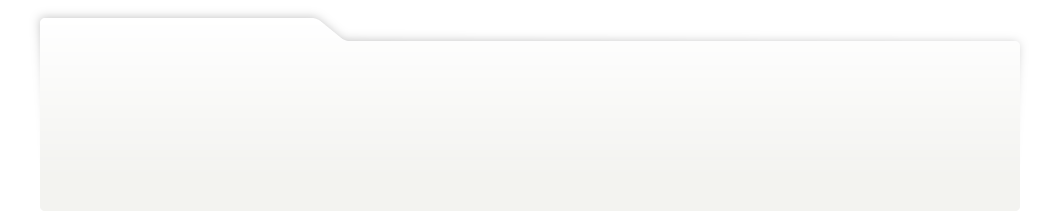
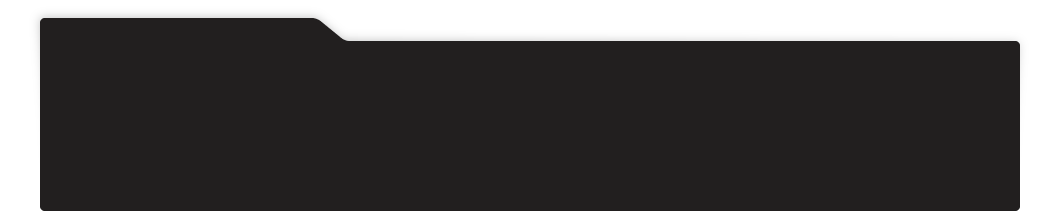
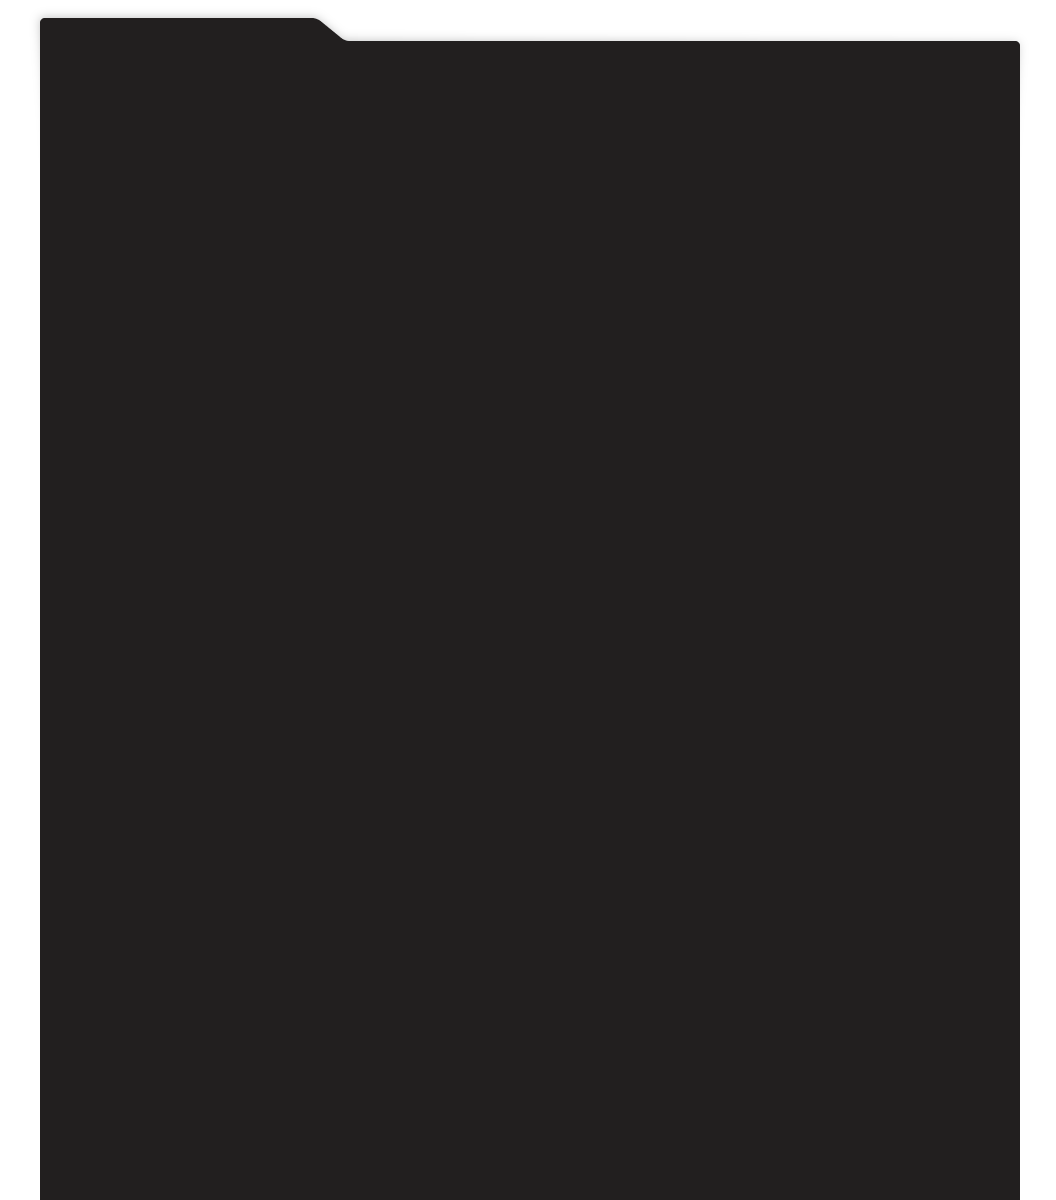
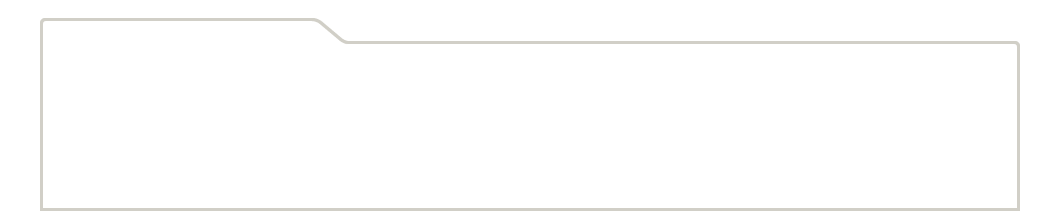
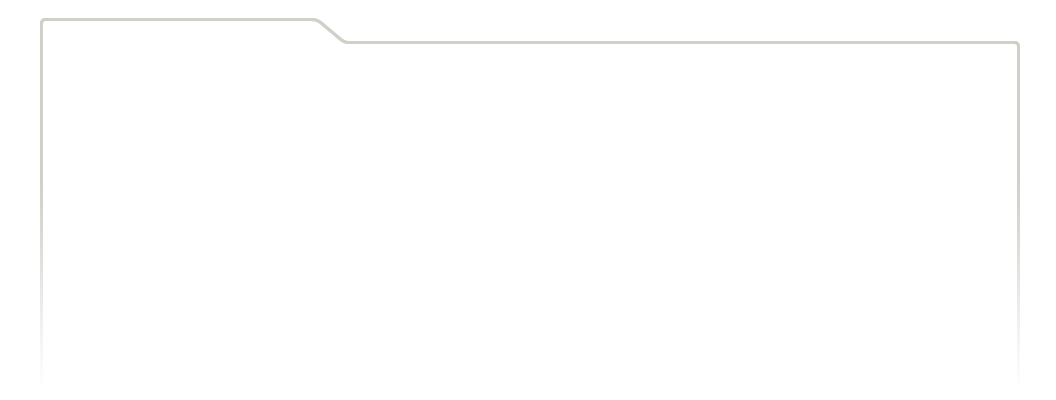
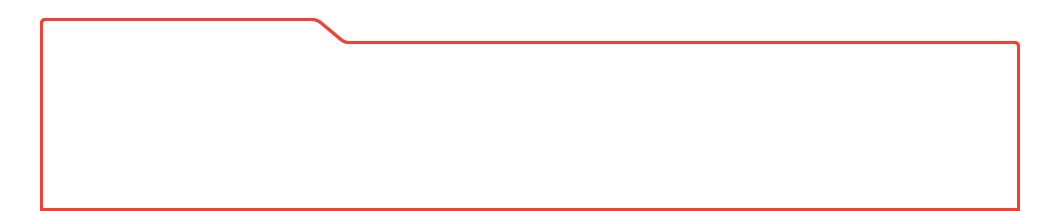
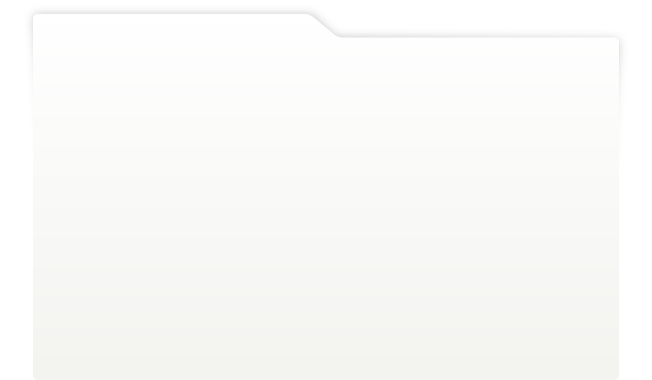
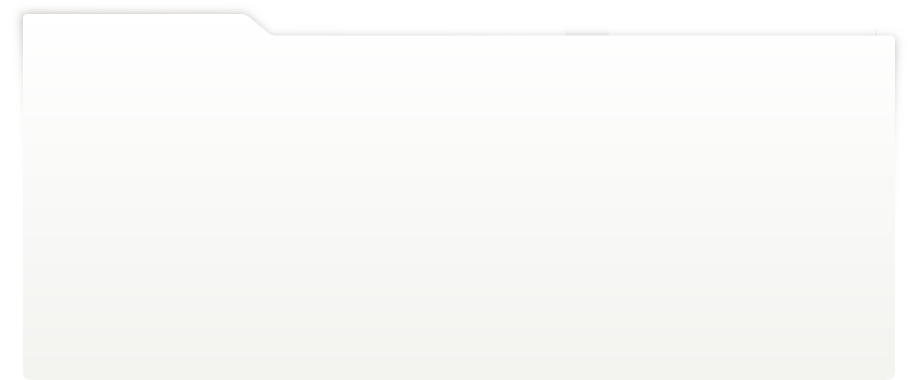
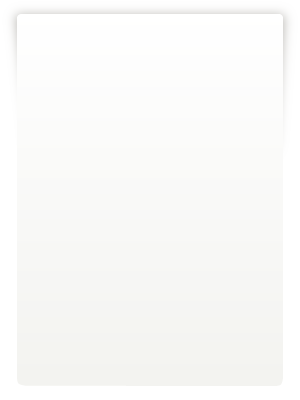
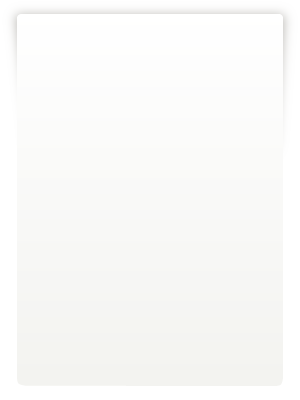
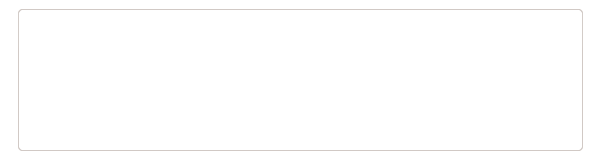
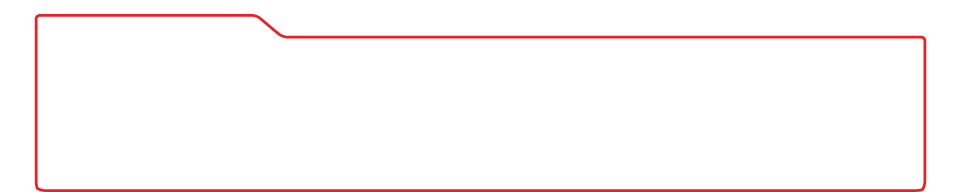
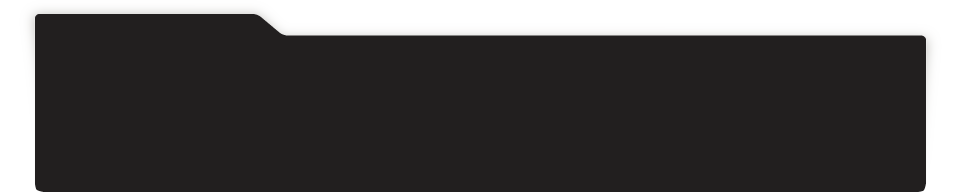
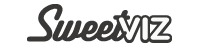
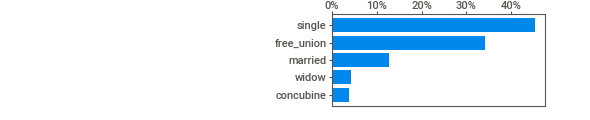
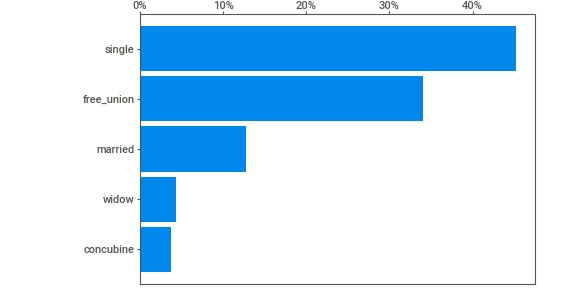
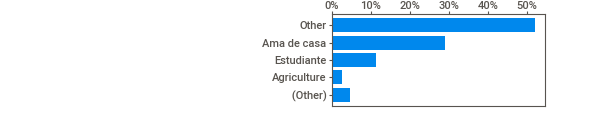
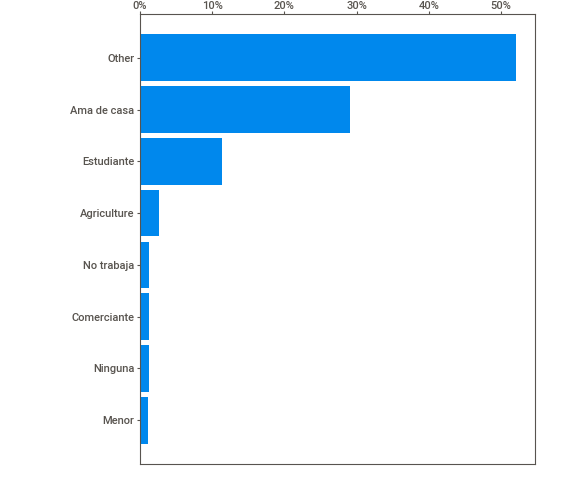
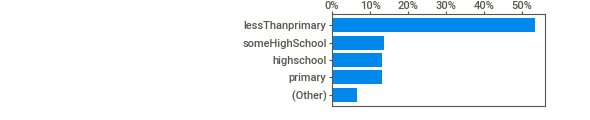
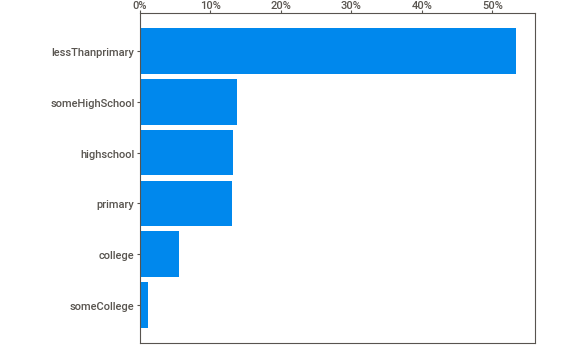
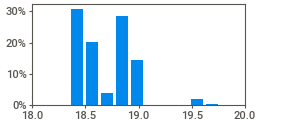
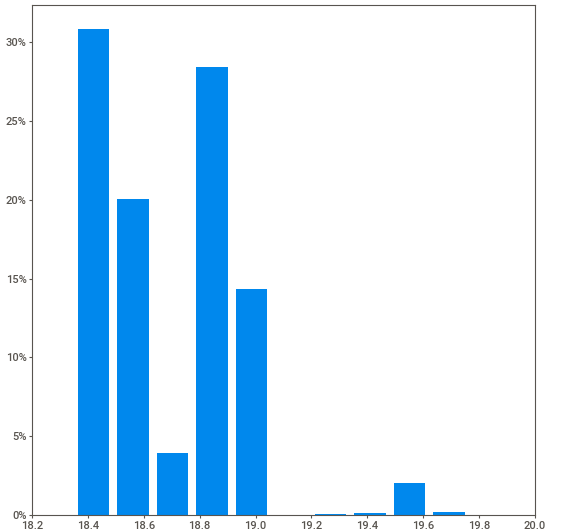
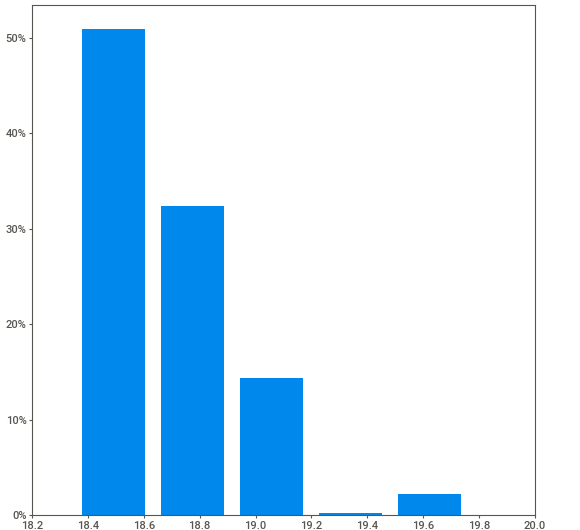
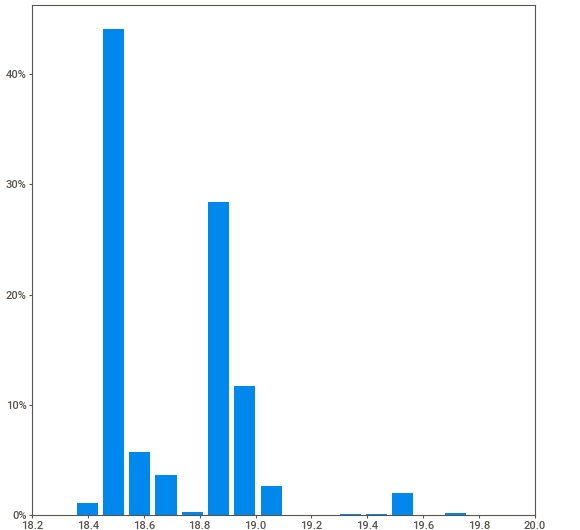
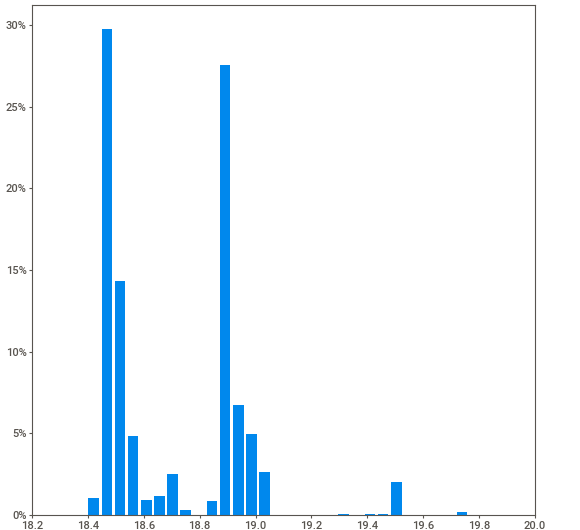
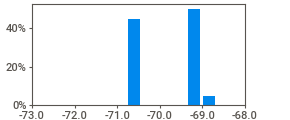
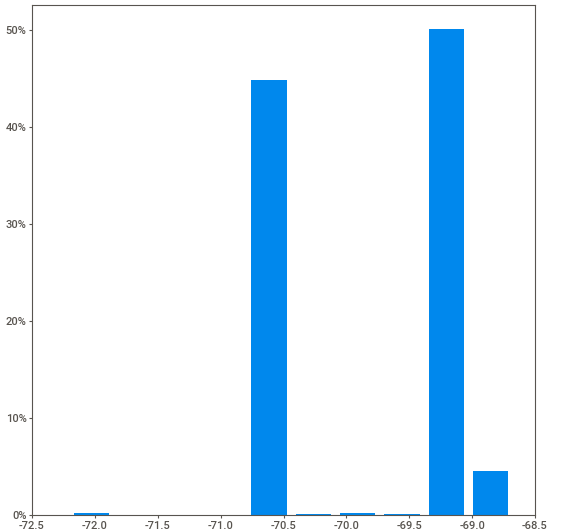
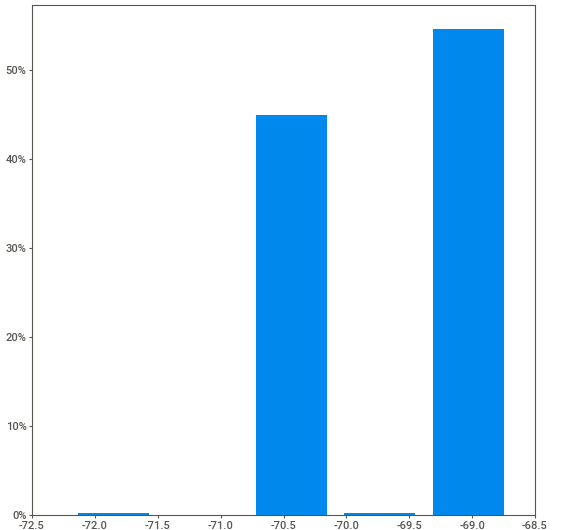
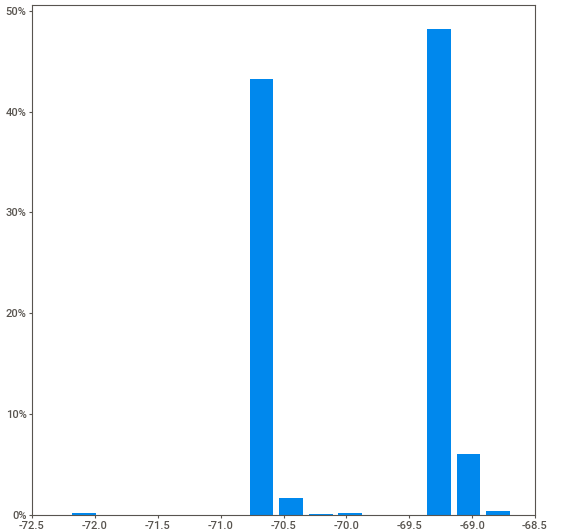
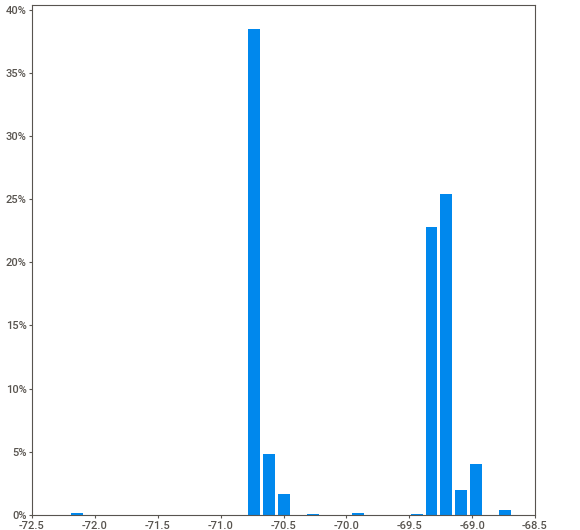
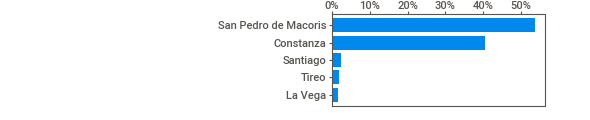
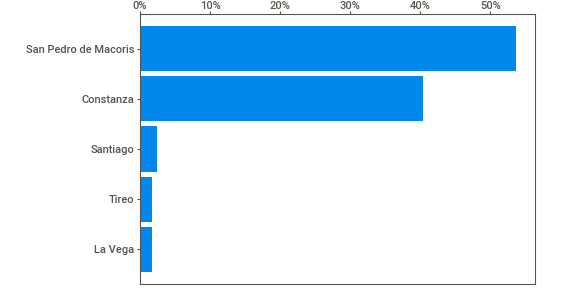
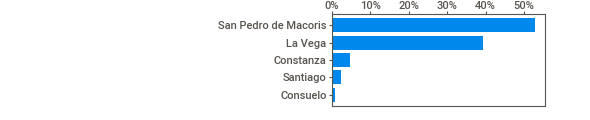
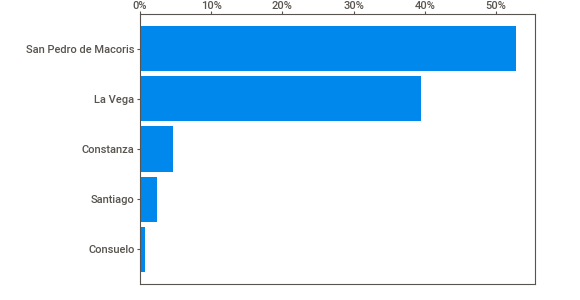
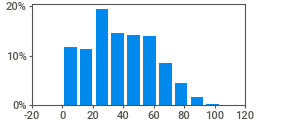
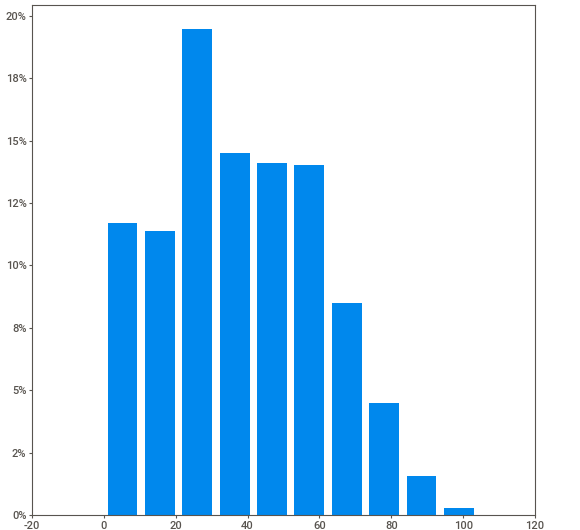
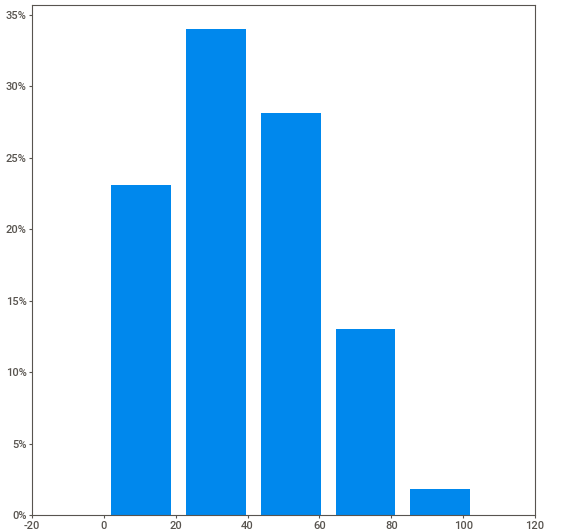
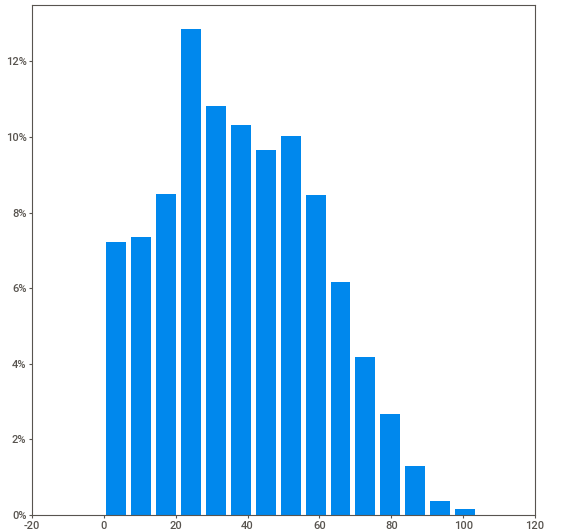
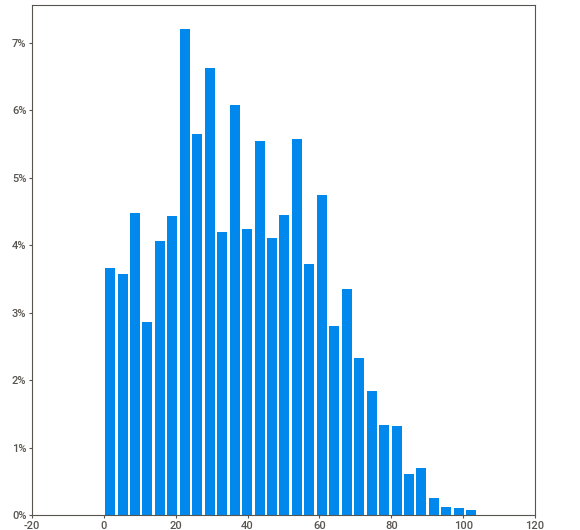
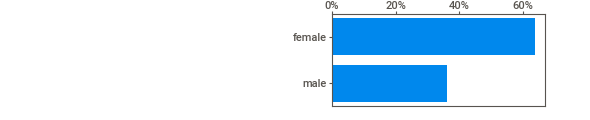
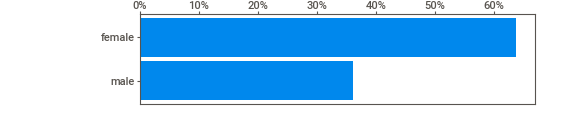
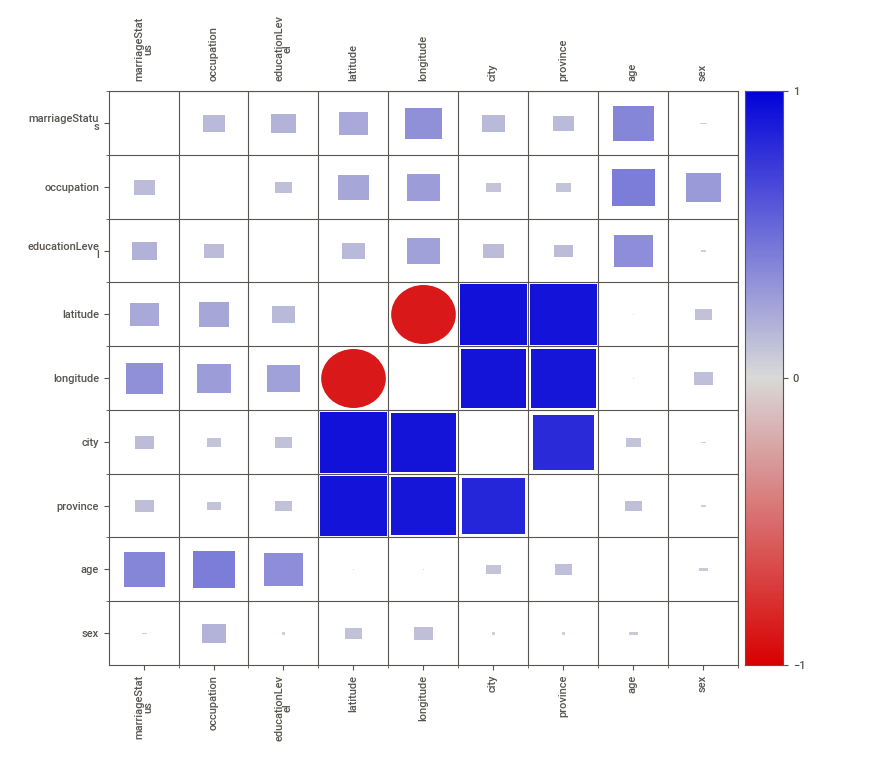
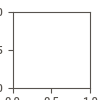

In [13]:
sv_report_survey_vitals = sv.analyze([survey_vitals, "Survey_vitals"])
sv_report_survey_vitals.show_notebook()

### 1.2 Eval_med


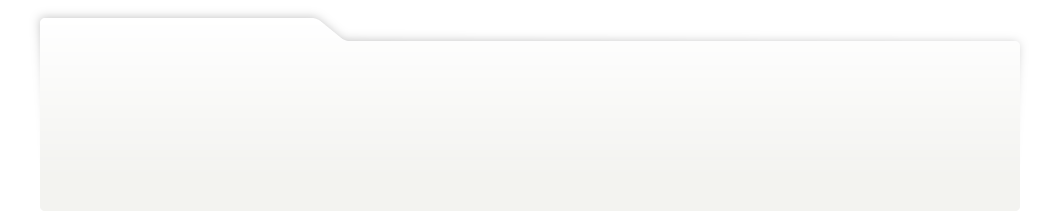
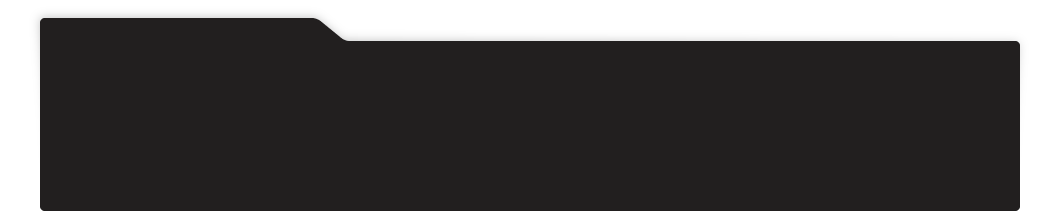
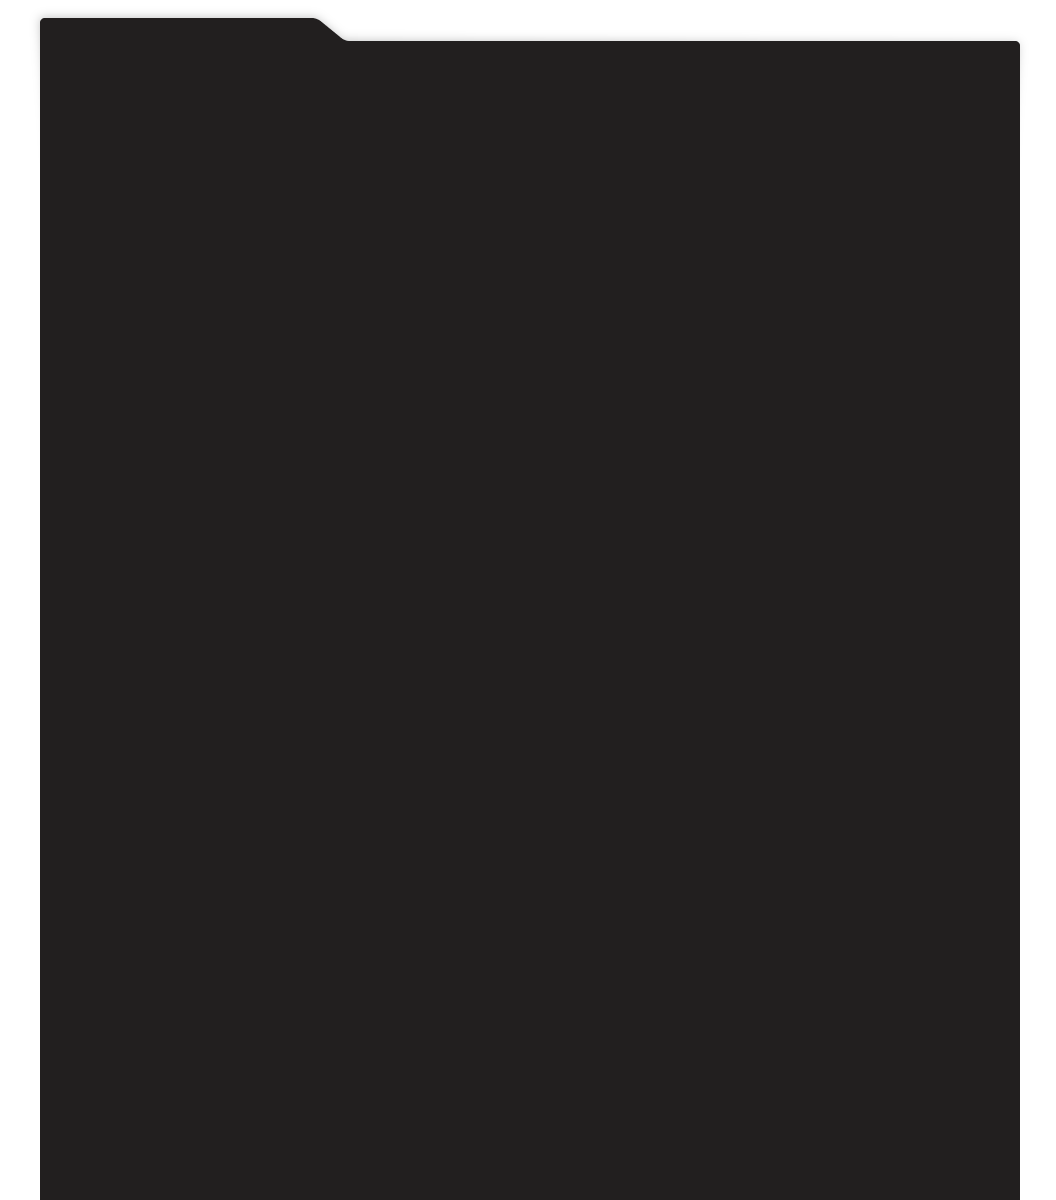
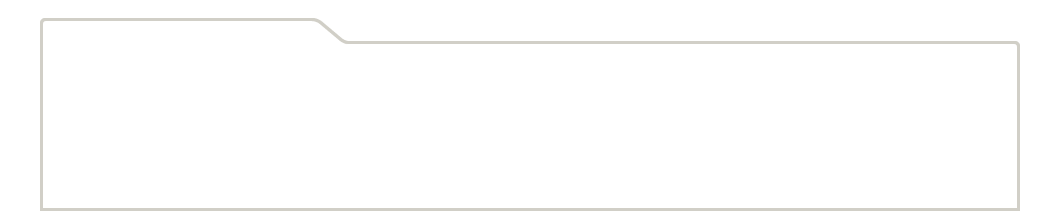
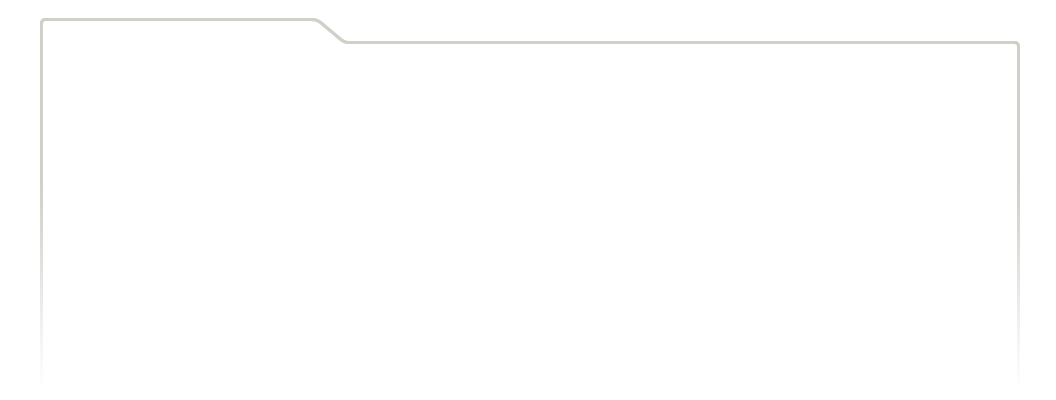
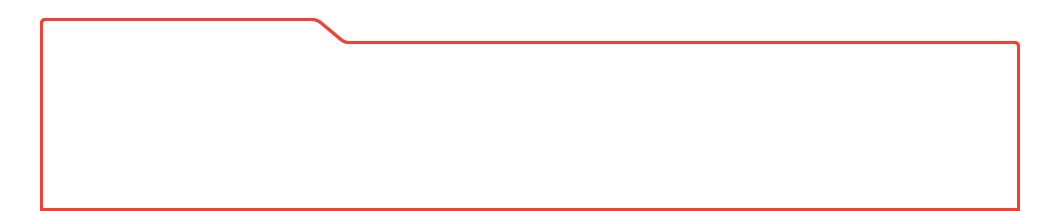
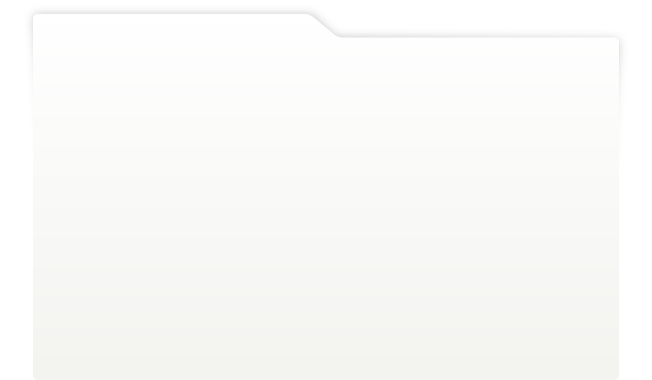
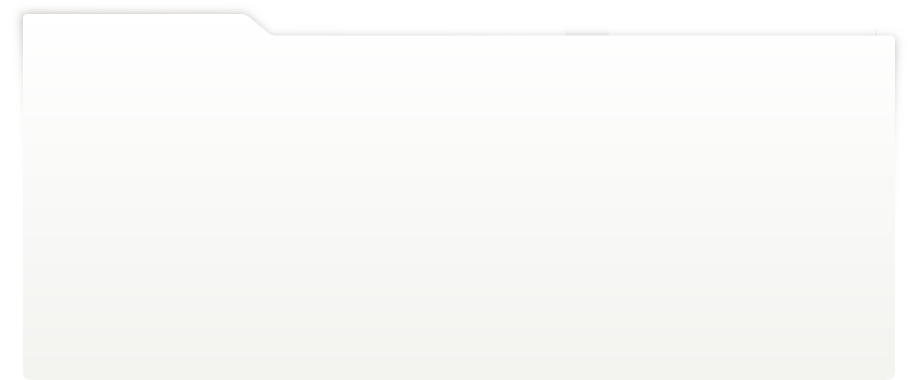
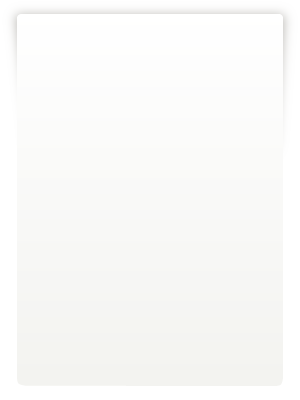
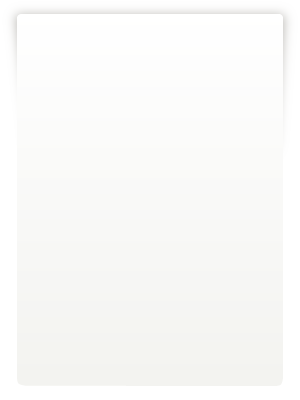
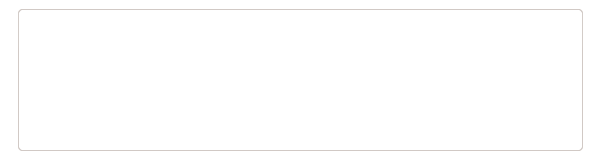
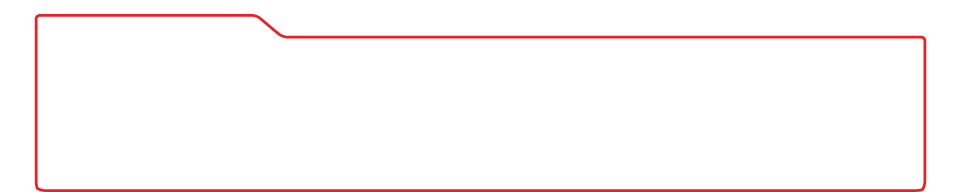
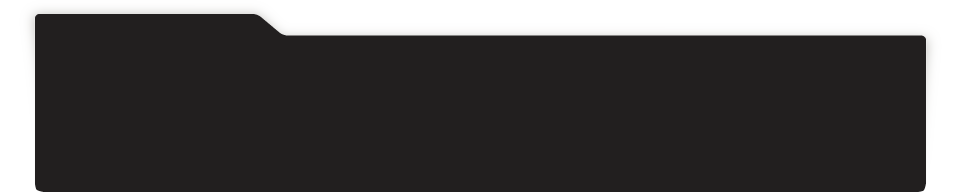
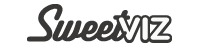
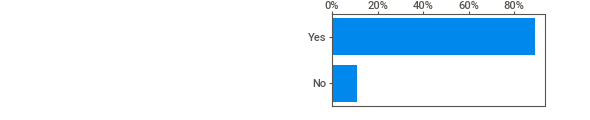
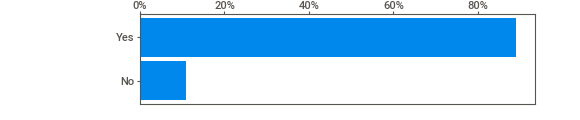
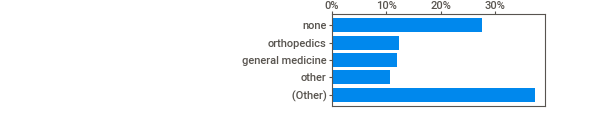
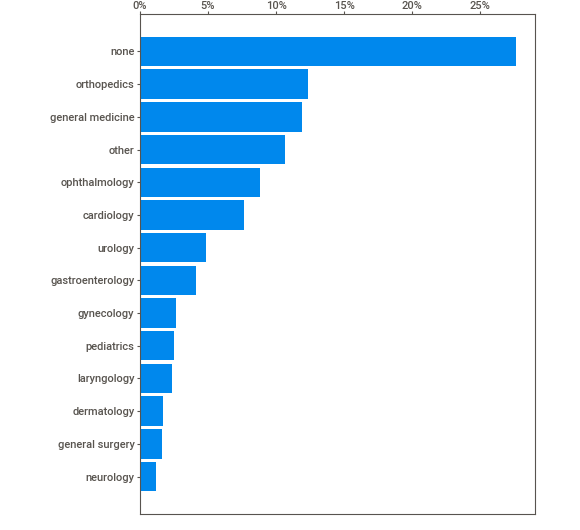
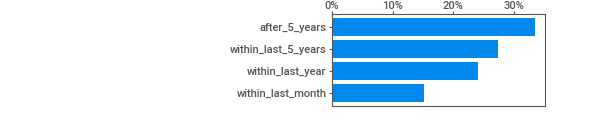
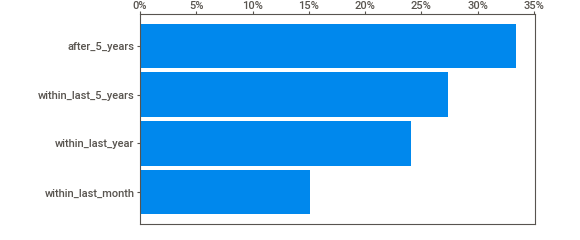
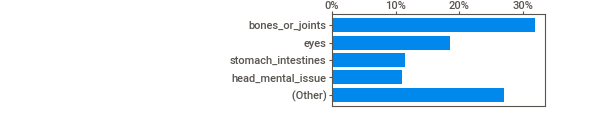
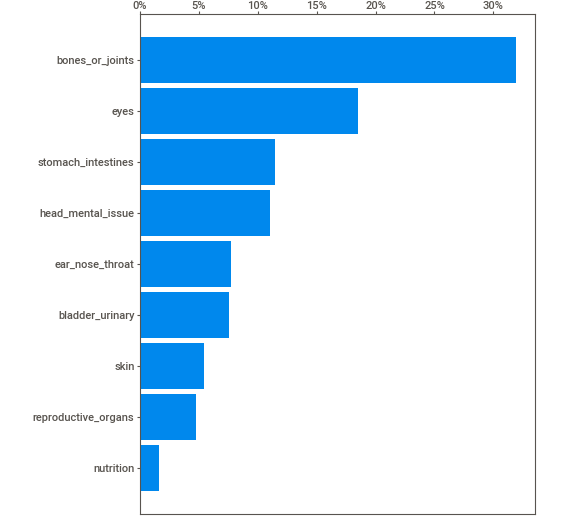
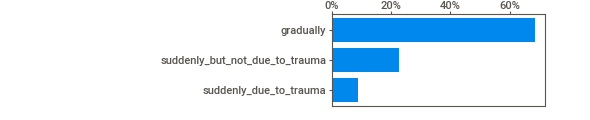
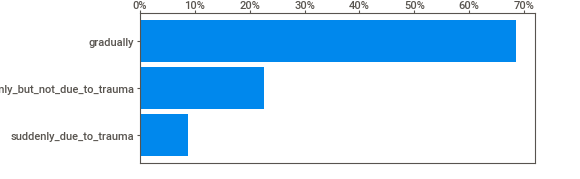
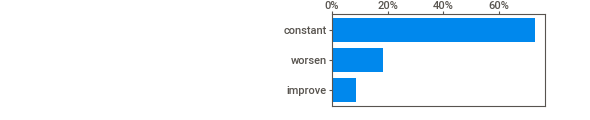
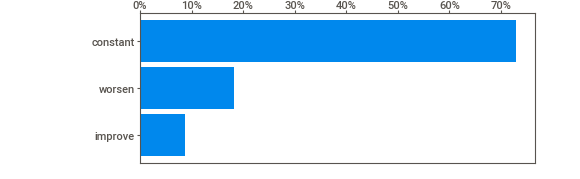
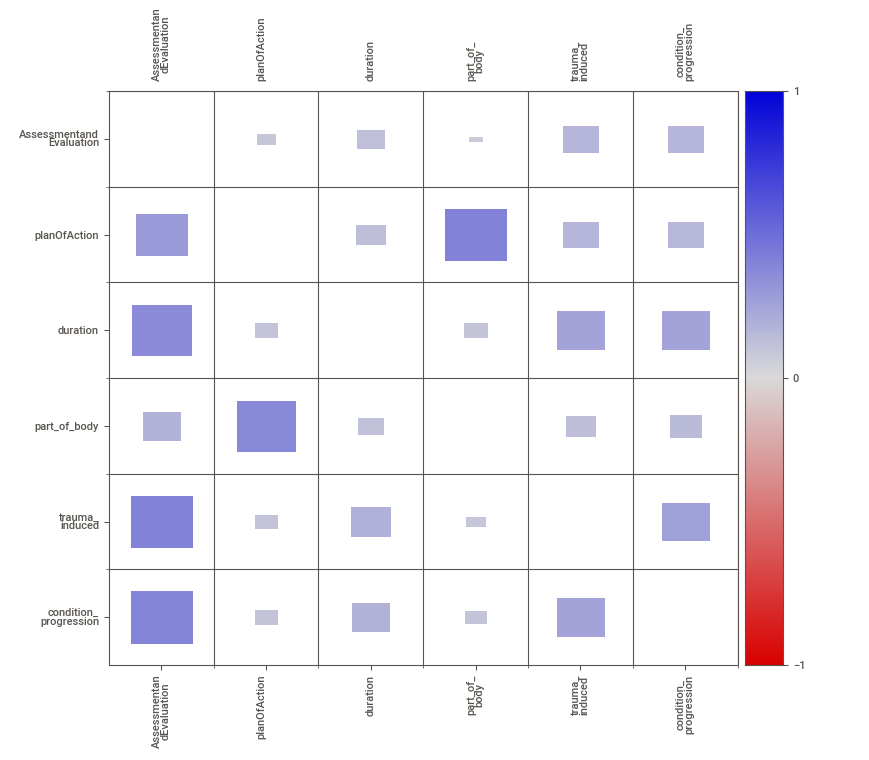
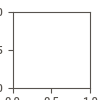

In [14]:
sv_report_eval_med = sv.analyze([eval_med, "Eval_med"])
sv_report_eval_med.show_notebook()

### 1.3 History_eval


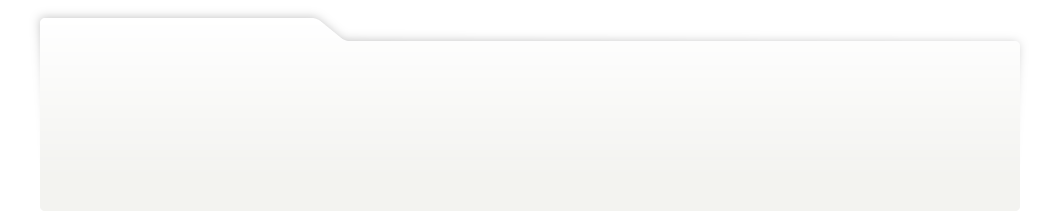
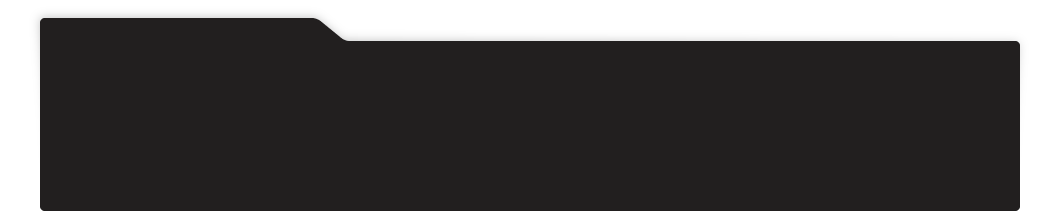
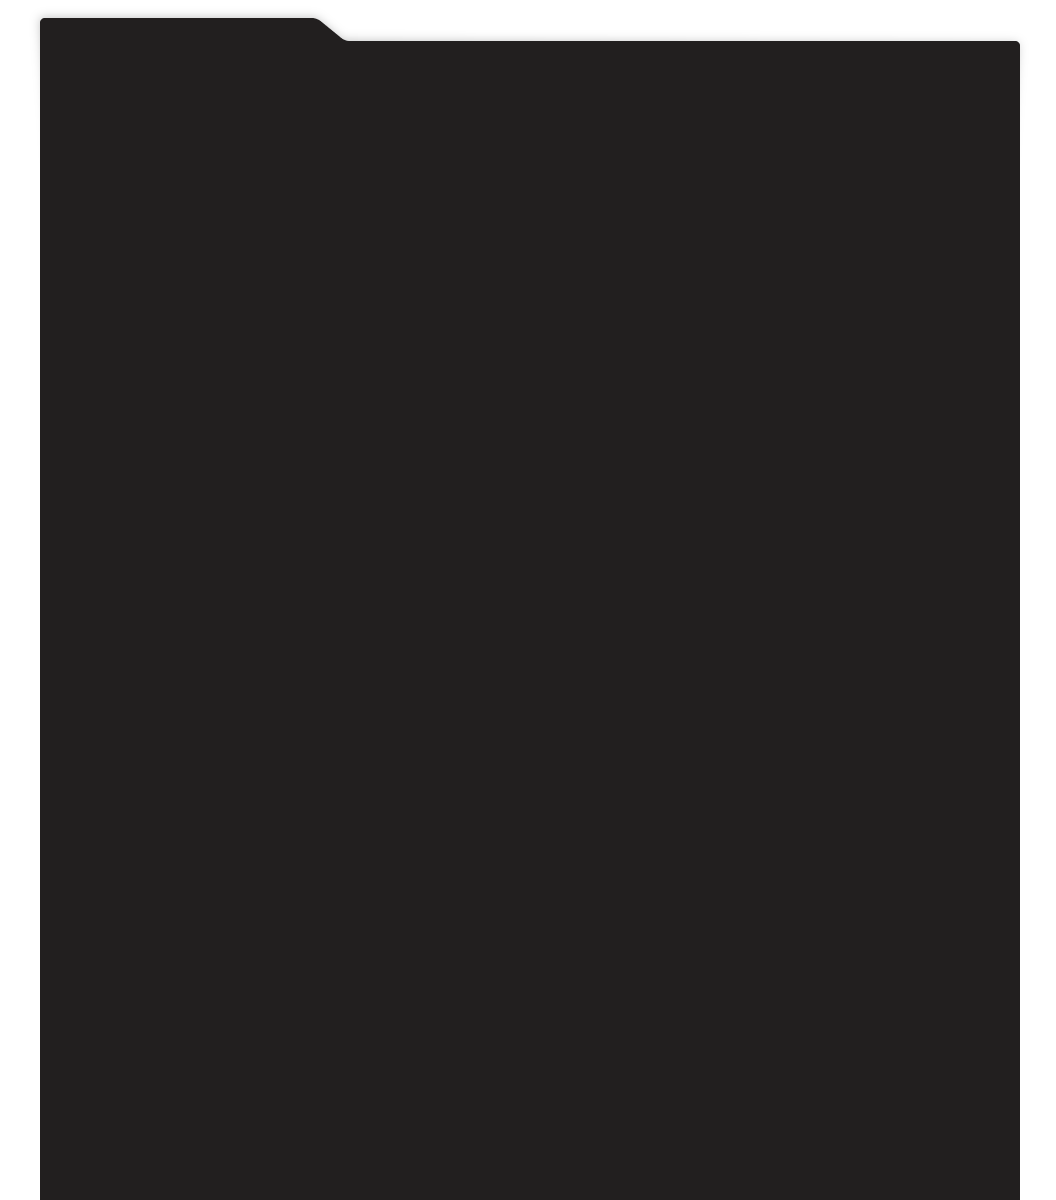
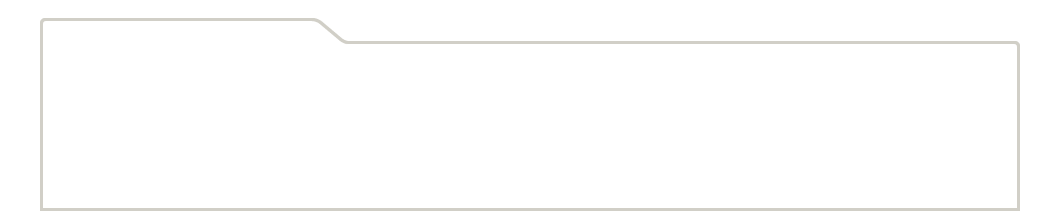
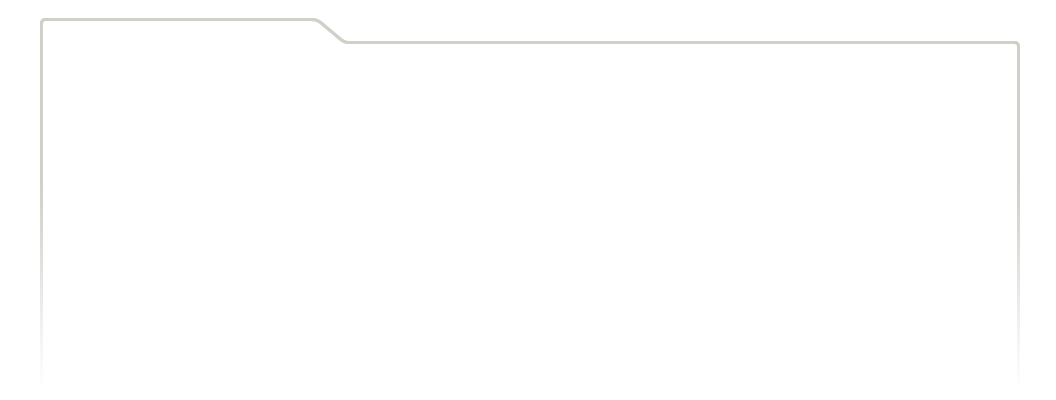
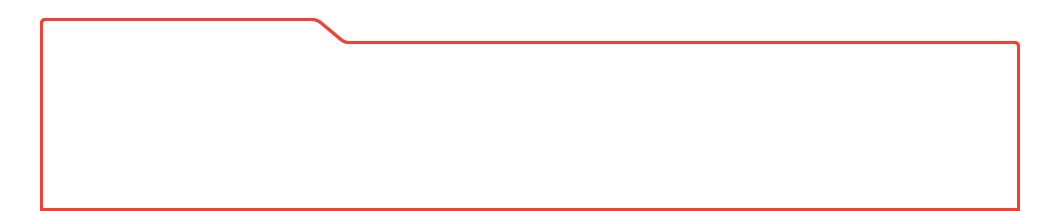
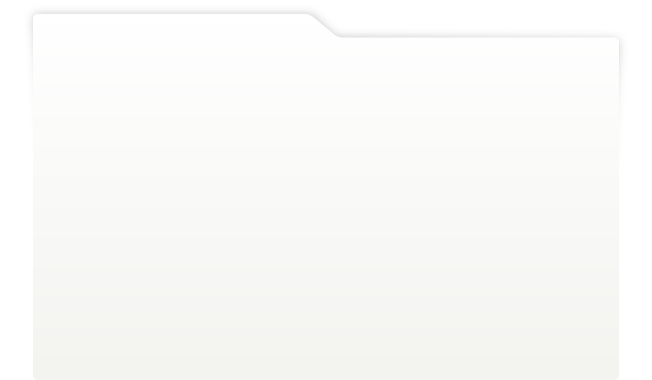
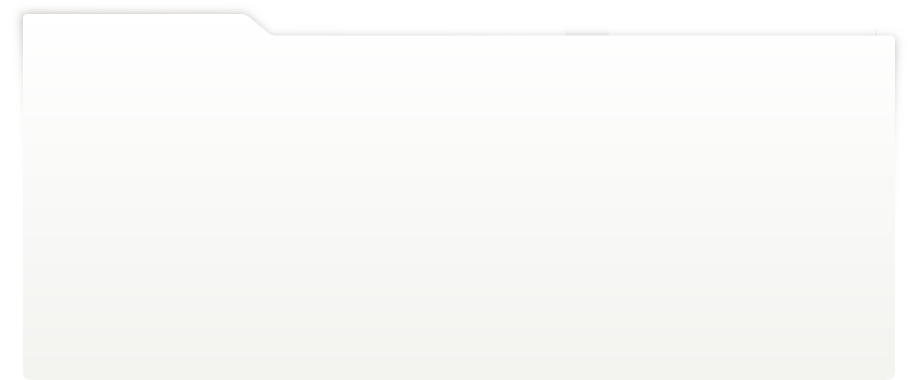
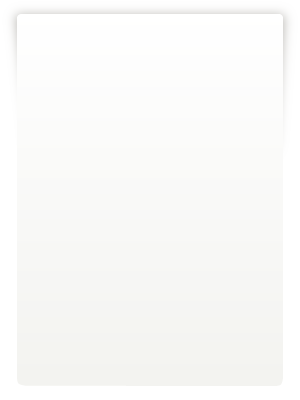
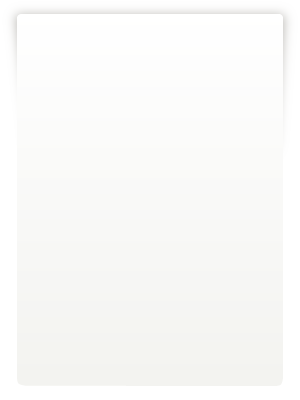
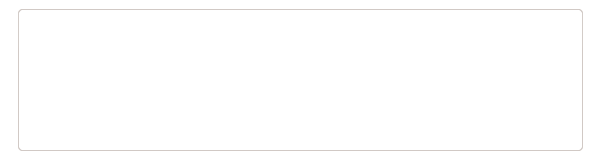
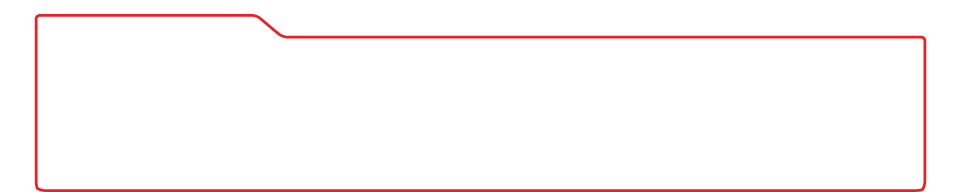
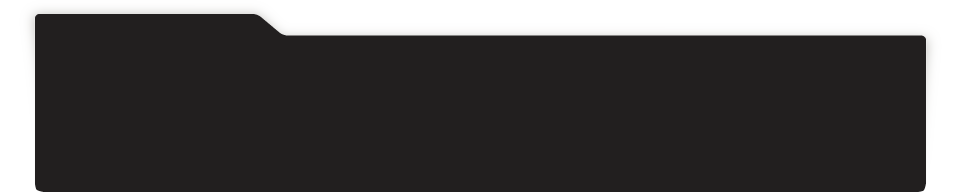
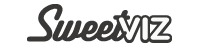
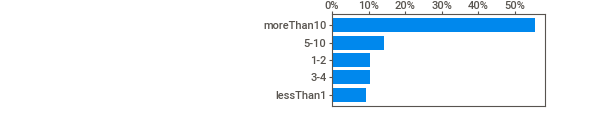
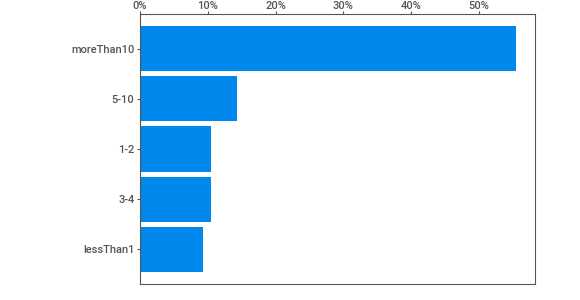
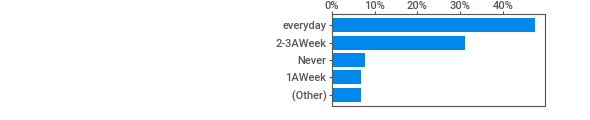
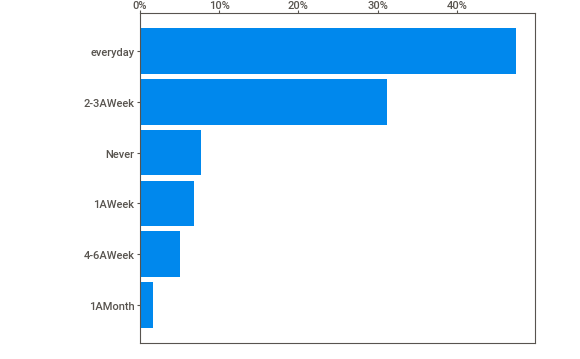
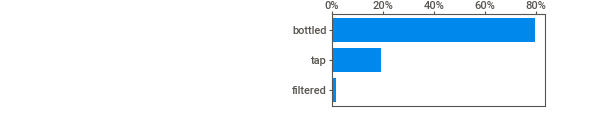
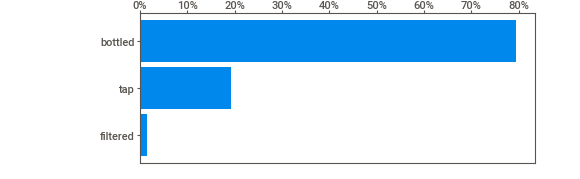
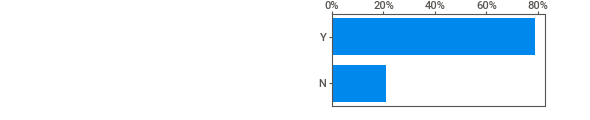
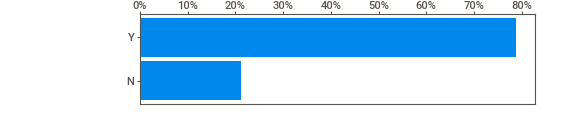
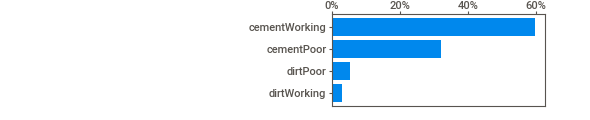
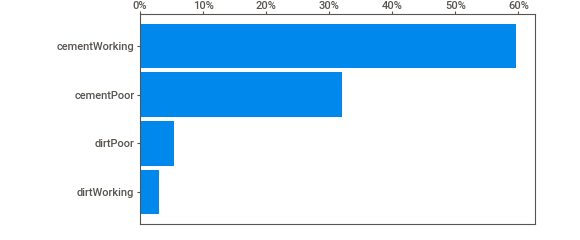
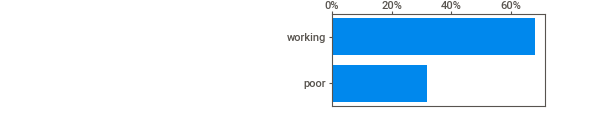
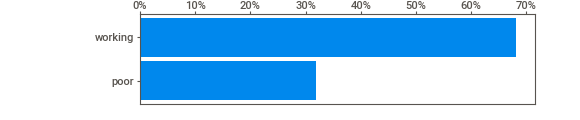
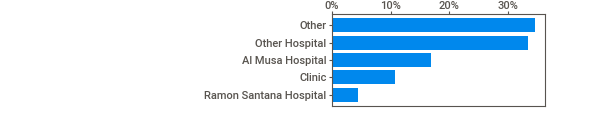
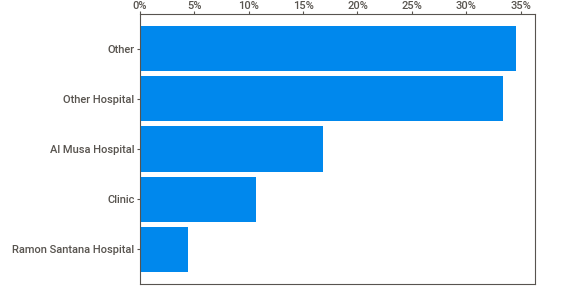
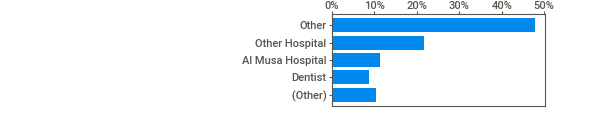
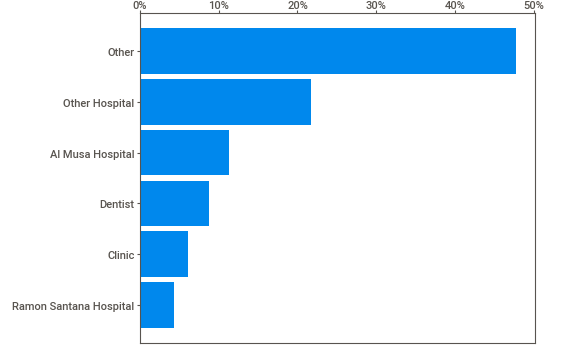
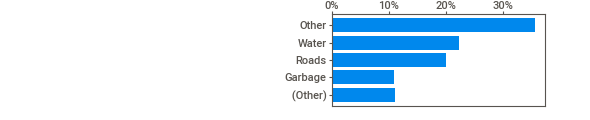
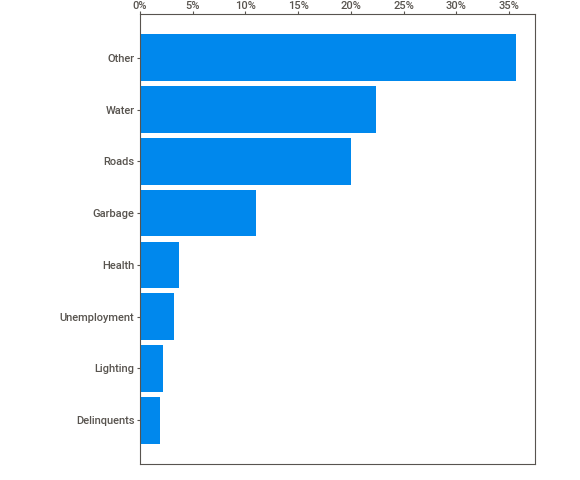
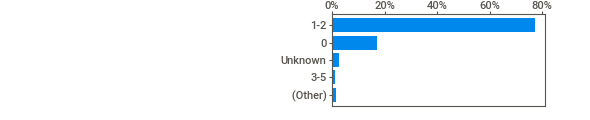
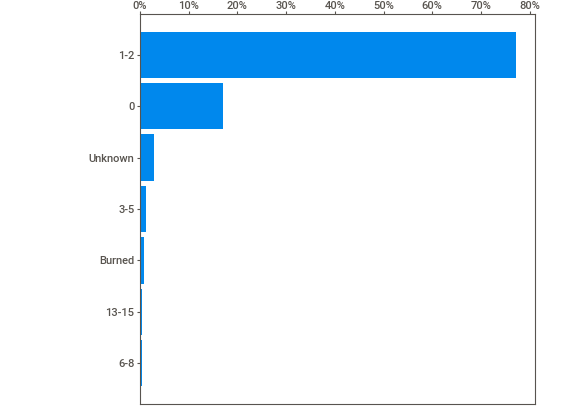
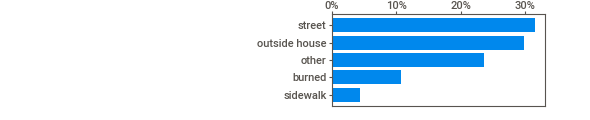
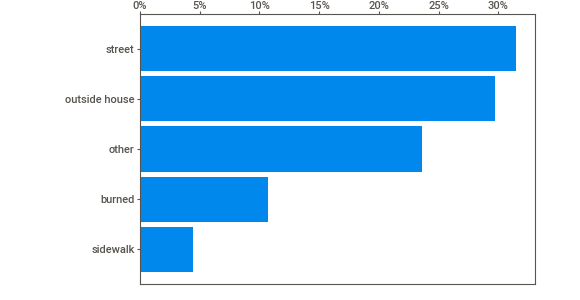
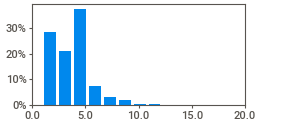
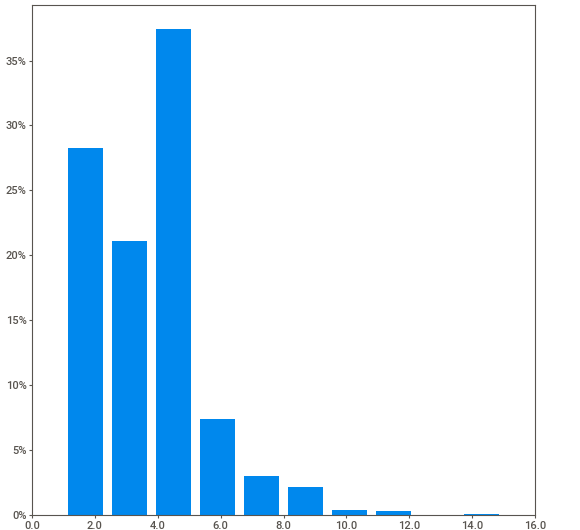
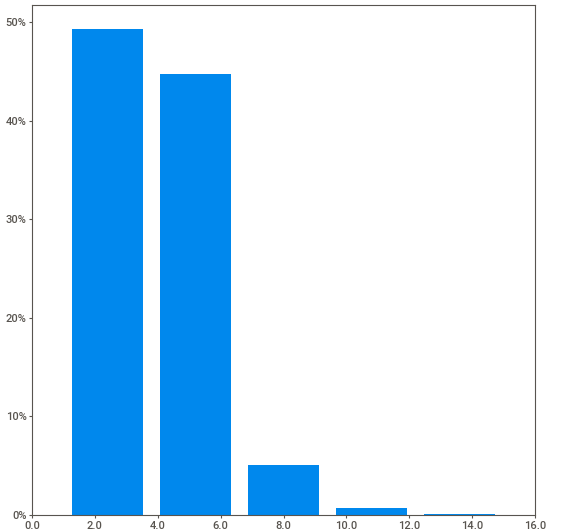
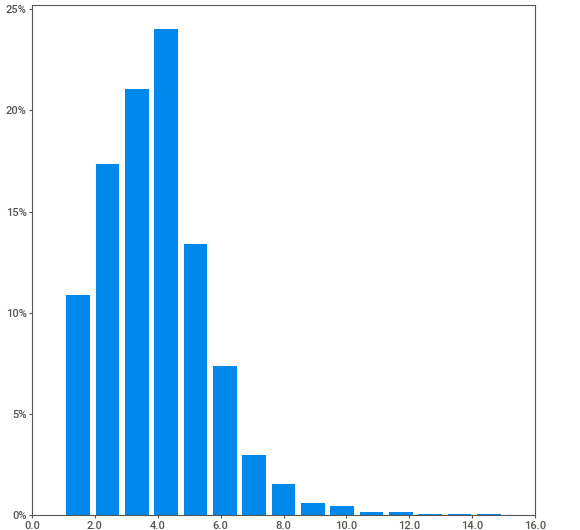
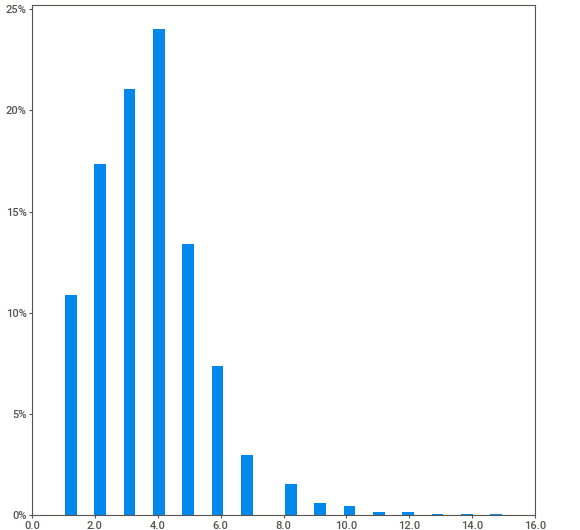
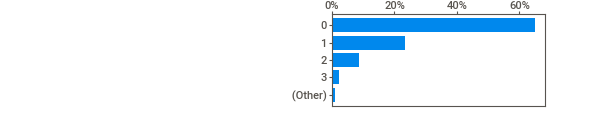
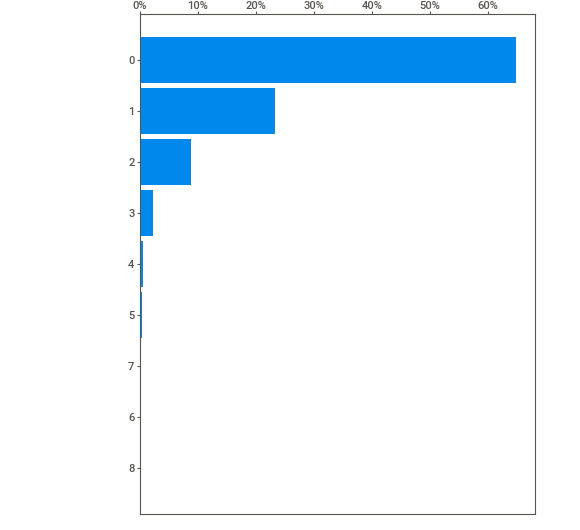
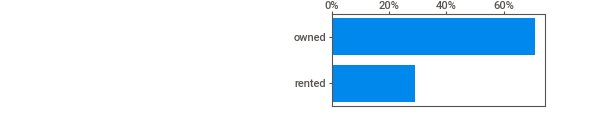
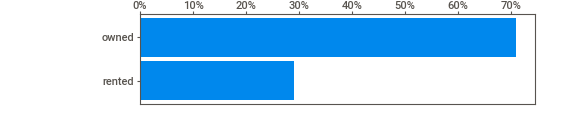
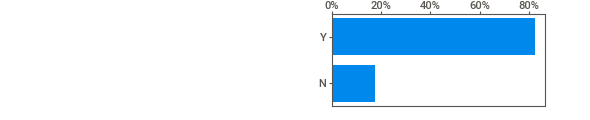
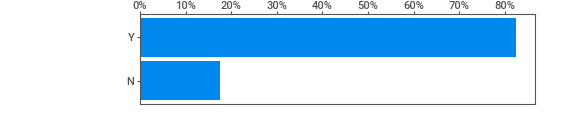
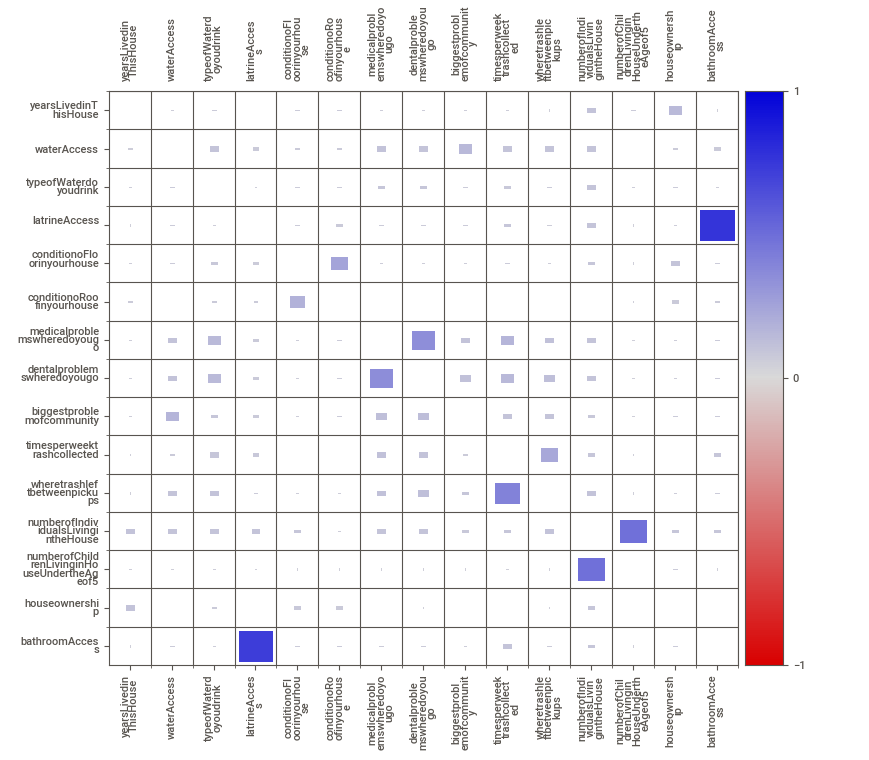
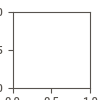

In [15]:
# converting numberofChildrenLivinginHouseUndertheAgeof5 data to string object
history_env["numberofChildrenLivinginHouseUndertheAgeof5"] = history_env["numberofChildrenLivinginHouseUndertheAgeof5"].astype(str) # converting numberofChildrenLivinginHouseUndertheAgeof5 data to string object
sv_report_history_env = sv.analyze([history_env, "History_env"])
sv_report_history_env.show_notebook()

# 2. Clustering Datapoints into Provinces Based on Geolocation Data (latitude, longitude)

We started off by clustering each datapoint in the survey_vitals dataset to four clusters (four DR provinces) because our task was to identify differnces between high need communities.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns
from sklearn.impute import SimpleImputer

In [17]:
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude city province   age     sex  
0 -70.743801  NaN      NaN  34.0  female  
1 -70.744104  NaN      NaN  52.0  female  
2 -70.744016  NaN      NaN  39.0    male  
3 -70.744557  NaN      NaN  39.0  female  
4 -70.745053  NaN      NaN  23.0    male

In [18]:
# choosing columns that are needed for a clustering algorithm 
geo_loc = survey_vitals.loc[:, ["latitude", "longitude"]]
scaler = StandardScaler()
transformed_geo = scaler.fit_transform(geo_loc) # transforming data for the algorithm

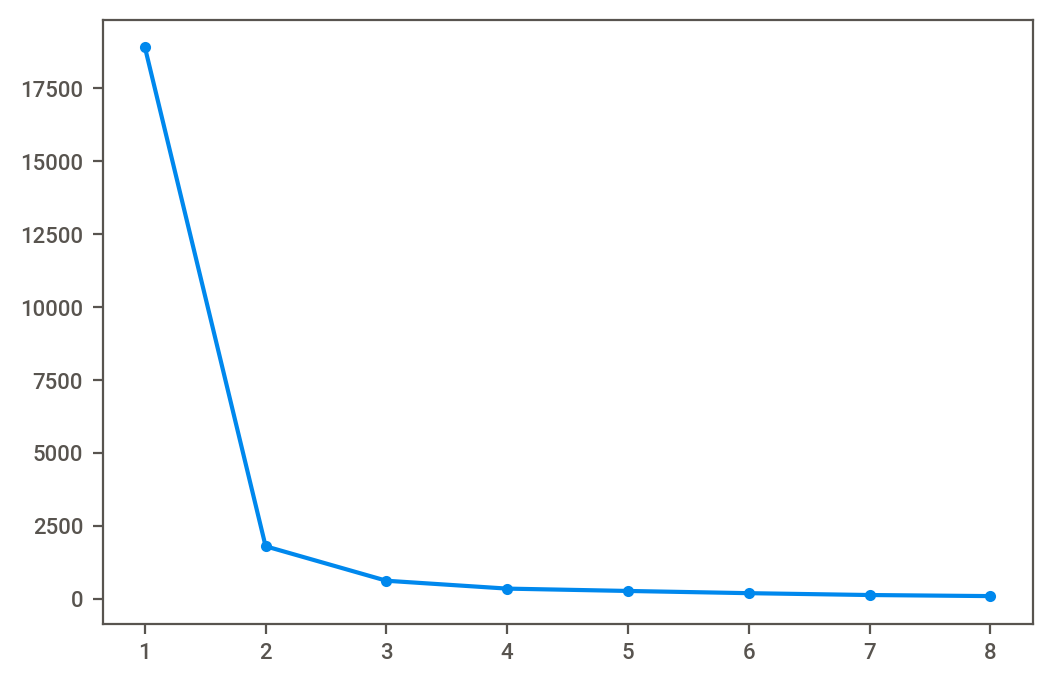

In [19]:
# finding the most efficient number of clusters
inertias = []
num_clusters = [1,2,3,4,5,6,7,8]
for k in num_clusters:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(transformed_geo)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, "-o")

In [20]:
# using clustering algorithm to assign each datapoint to a cluster
model_KMeans =  KMeans(n_clusters = 4, random_state = 42)
labels = model_KMeans.fit_predict(transformed_geo)
labels

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

In [21]:
survey_vitals["clustersByLoc"] = list(labels)
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude city province   age     sex  clustersByLoc  
0 -70.743801  NaN      NaN  34.0  female              1  
1 -70.744104  NaN      NaN  52.0  female              1  
2 -70.744016  NaN      NaN  39.0    male              1  
3 -70.744557  NaN      NaN  39.0  female              1  
4 -70.745053  NaN      NaN  23.0    male              1

In [22]:
# assigning each cluster to Dominican Republic provinces
def province_clean(cluster):
    if cluster == 0:
        return "San Pedro de Macoris"
    elif cluster == 1:
        return "La Vega"
    elif cluster == 2:
        return "Santiago"
    else:
        return "San Pedro de Macoris/North"

In [23]:
# dropping city and province (initially given in the dataset) columns because the columns had incorrect data
survey_vitals = survey_vitals.drop(columns = ["city", "province"], axis = 1)
survey_vitals["province"] = survey_vitals["clustersByLoc"].apply(province_clean) # adding a province (based on clustering) column

In [24]:
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude   age     sex  clustersByLoc province  
0 -70.743801  34.0  female              1  La Vega  
1 -70.744104  52.0  female              1  La Vega  
2 -70.744016  39.0    male              1  La Vega  
3 -70.744557  39.0  female              1  La Vega  
4 -70.745053  23.0    male              1  La Vega

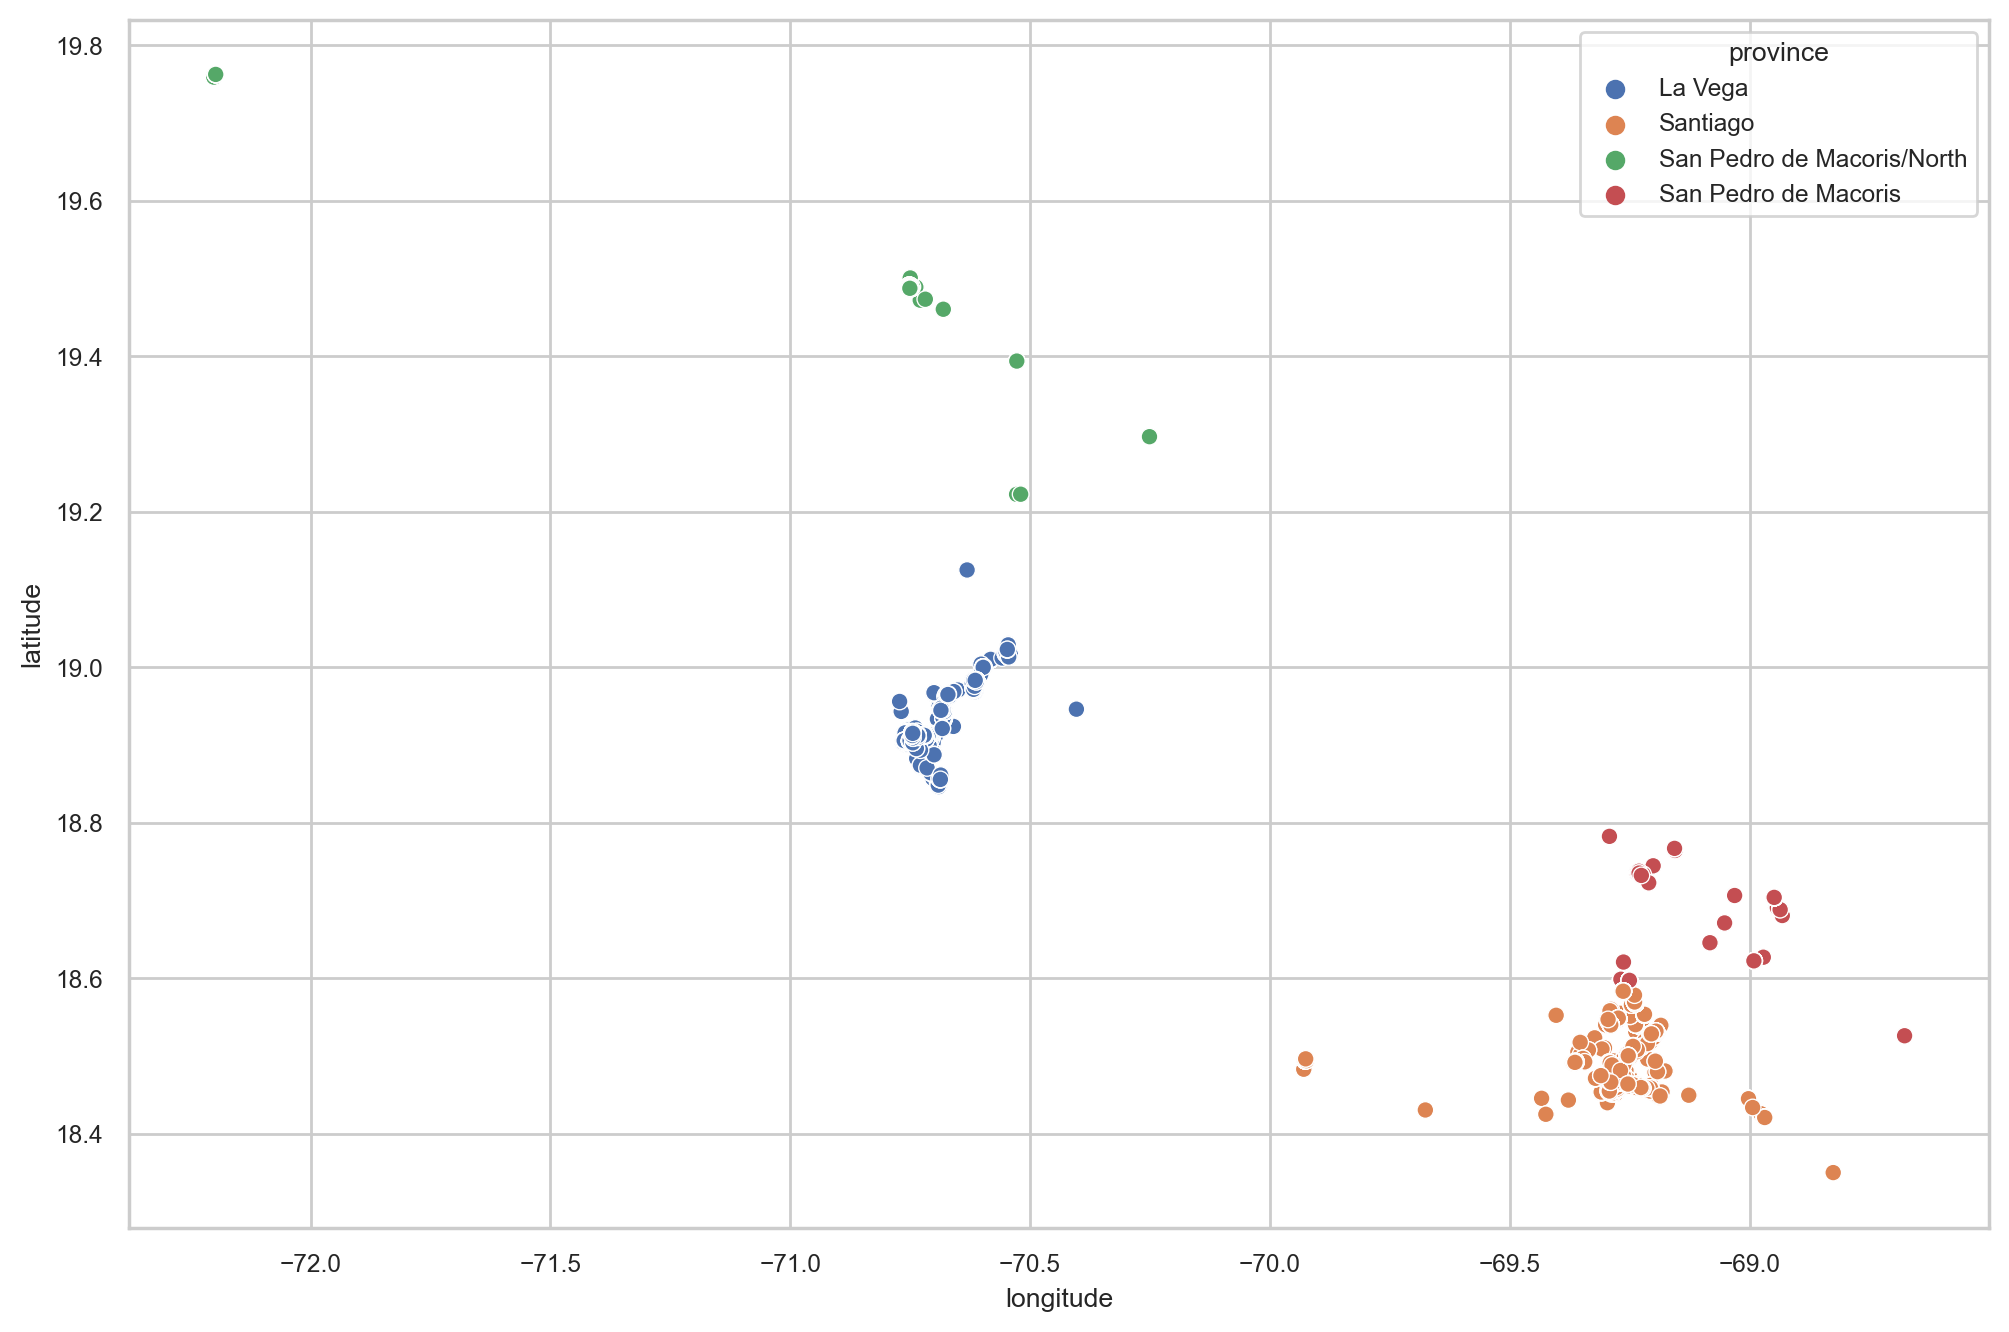

In [27]:
# graphing datapoints by provinces
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = survey_vitals, x = "longitude", y = "latitude", hue = "province", palette = "deep")

In [28]:
# number of respondents in each province
survey_vitals.province.value_counts()

Santiago                      4688
La Vega                       4044
San Pedro de Macoris           498
San Pedro de Macoris/North     228
Name: province, dtype: int64

In [29]:
# making a separate dataframe for each province
Lavega_survey = survey_vitals[(survey_vitals["province"] == "La Vega") & (survey_vitals["longitude"] < -70.45)]
sp_survey = survey_vitals[survey_vitals["province"] == "San Pedro de Macoris"]
sp_north_survey = survey_vitals[(survey_vitals["province"] == "San Pedro de Macoris/North") & (survey_vitals["longitude"] < -68.7)]
santiago_survey = survey_vitals[survey_vitals["province"] == "Santiago"]

Text(0.5, 1.0, "Respondents' location in Santiago")

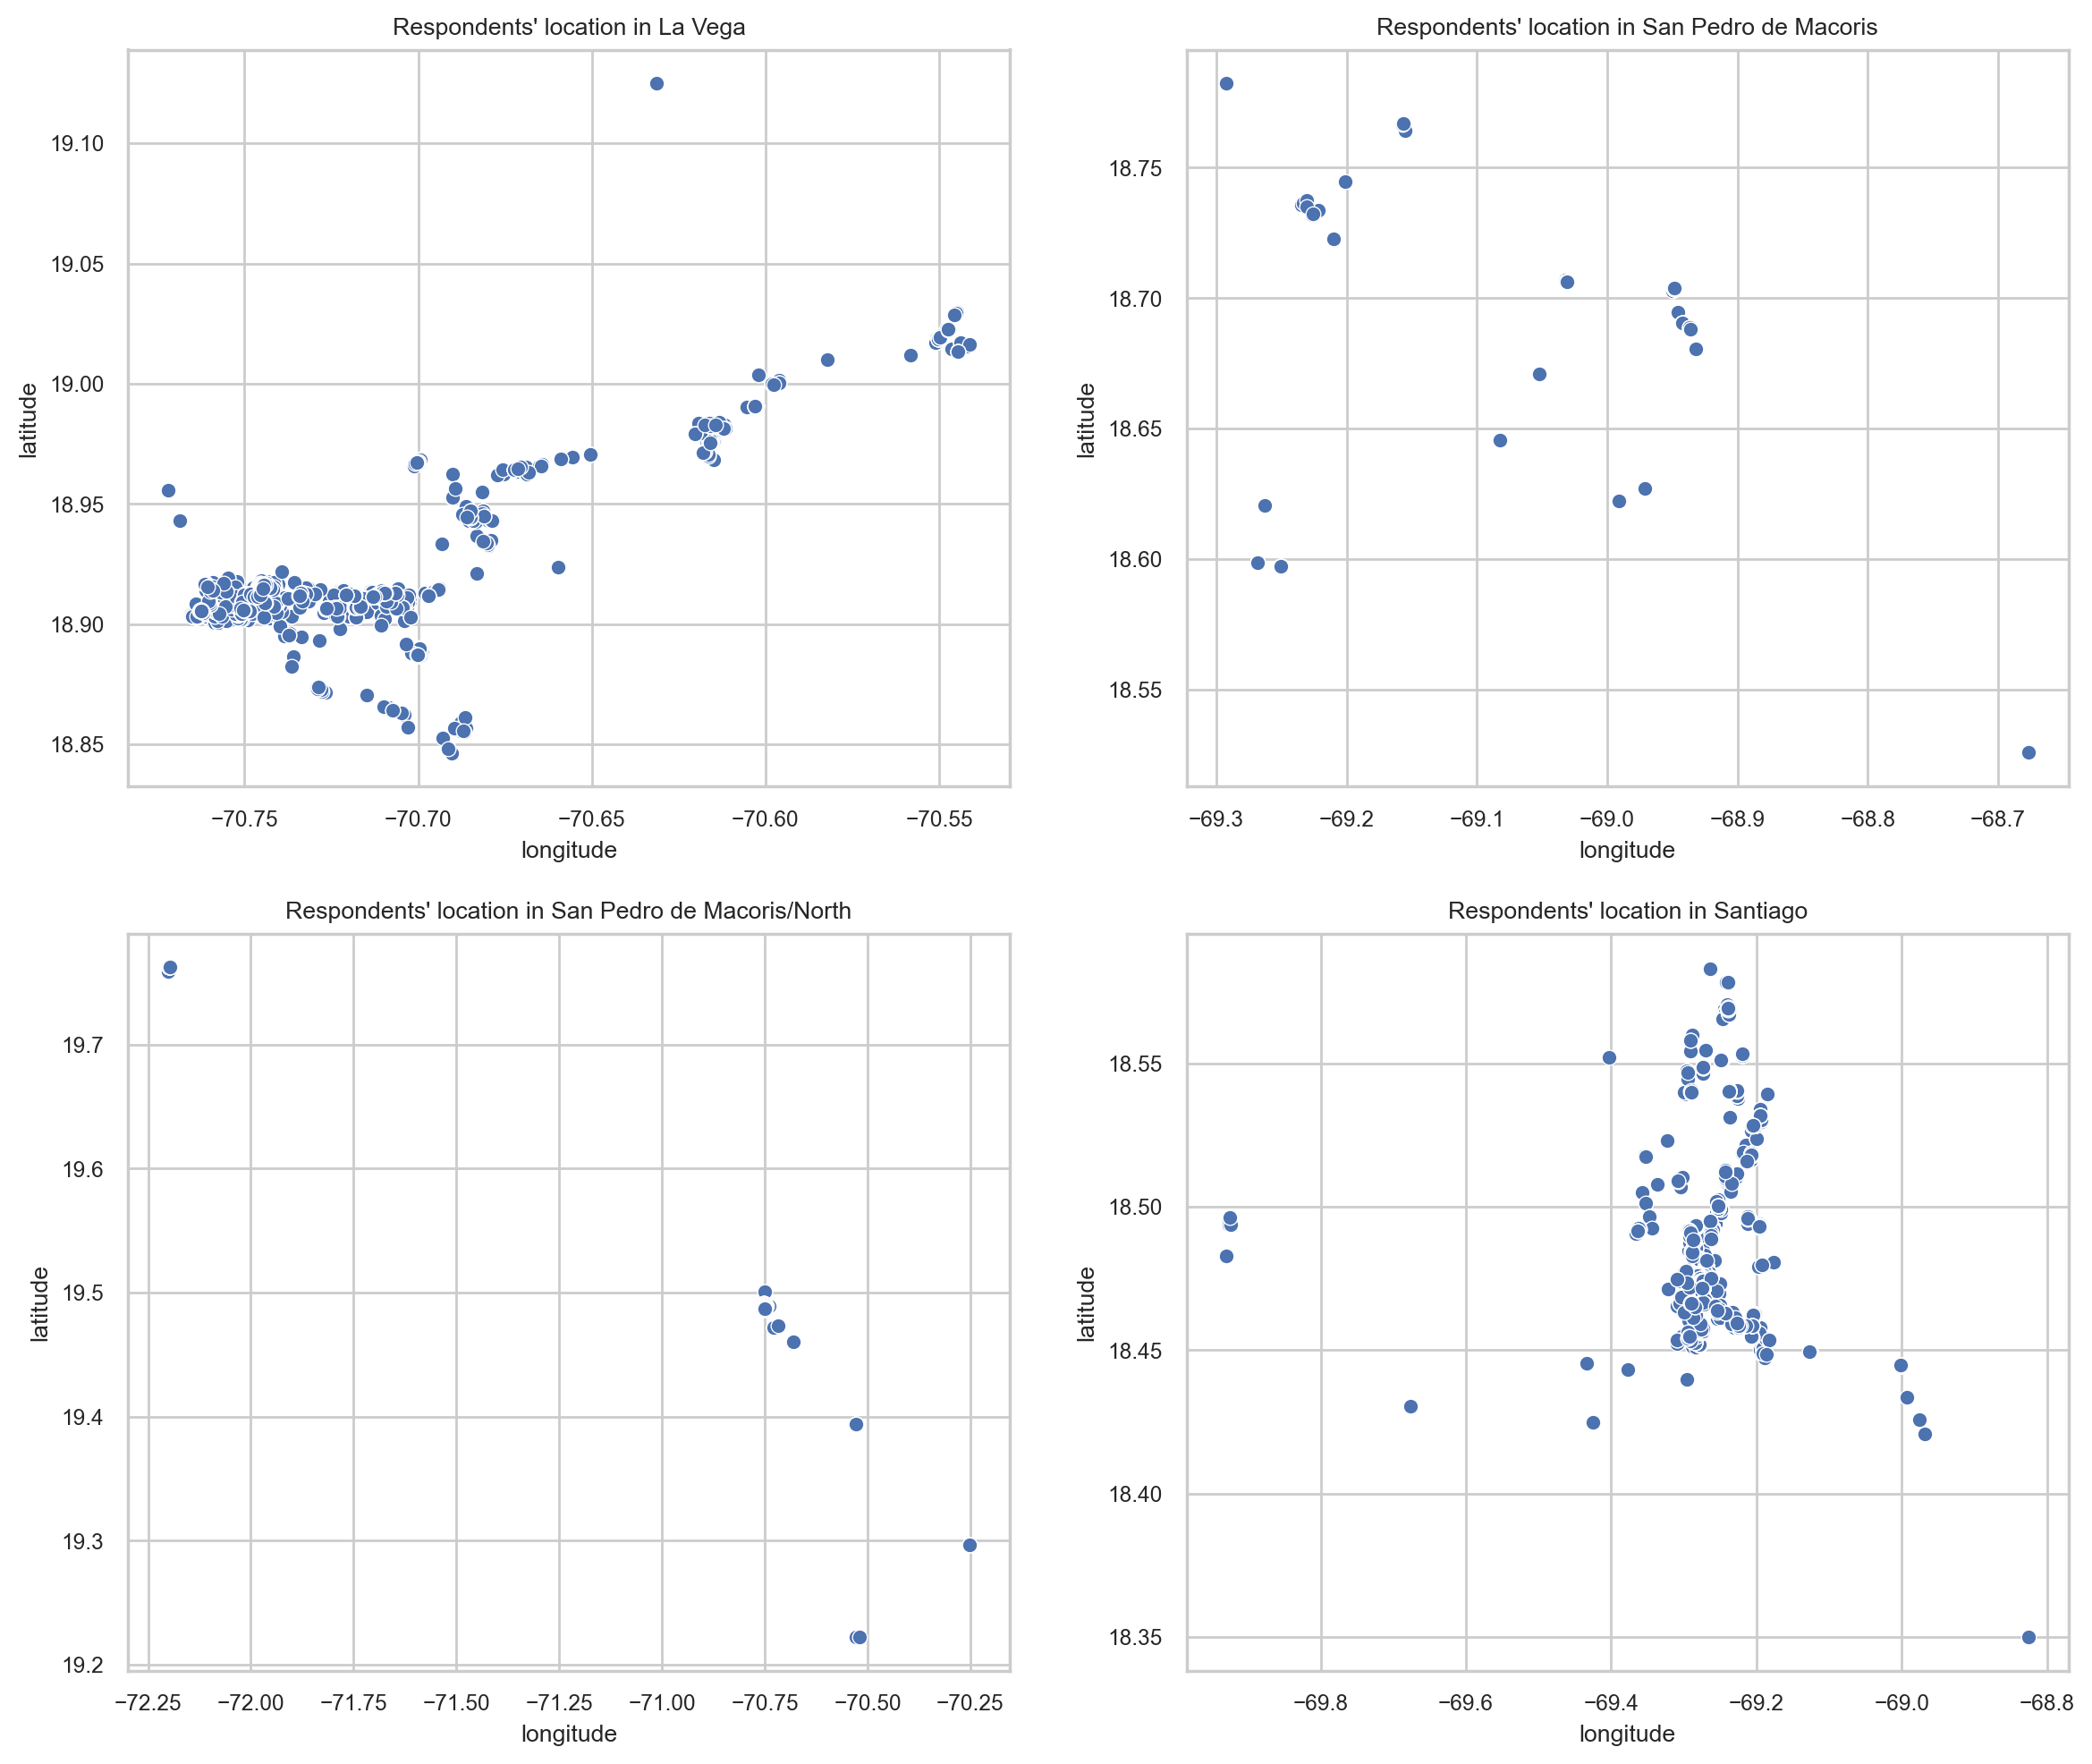

In [30]:
# graphing each cluster separately based on longitude and latitude data
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(14,12)
ax1 = sns.scatterplot(data = Lavega_survey, x = "longitude", y = "latitude", palette = "deep", ax = ax1)
ax1.set_title("Respondents' location in La Vega")
ax2 = sns.scatterplot(data = sp_survey, x = "longitude", y = "latitude", palette = "deep", ax = ax2)
ax2.set_title("Respondents' location in San Pedro de Macoris")
ax3 = sns.scatterplot(data = sp_north_survey, x = "longitude", y = "latitude", palette = "deep", ax = ax3)
ax3.set_title("Respondents' location in San Pedro de Macoris/North")
ax4 = sns.scatterplot(data = santiago_survey, x = "longitude", y = "latitude", palette = "deep", ax = ax4)
ax4.set_title("Respondents' location in Santiago")

# 3. Clustering Datapoints into Communities Based on Geolocation Data

After separating the data into four different sets based on geoloction data and newly created provinces, we decided to separate provinces into smaller communities. We understood that we would not be able to find community issues in smaller high need communities by conducting a province level analysis. 

In [31]:
# building a function that clusters each datapoints in each province to different smaller communities
def model_inertias(df):
    geo_loc = df.loc[:, ["latitude", "longitude"]]
    scaler = StandardScaler()
    transformed_geo = scaler.fit_transform(geo_loc)
    
    inertias = []
    num_clusters = [1,2,3,4,5,6,7,8]
    for k in num_clusters:
        model = KMeans(n_clusters = k, random_state = 42)
        model.fit(transformed_geo)
        inertias.append(model.inertia_)
        
    
    range_n_clusters = [2, 3, 4, 5, 6]
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(transformed_geo)
        silhouette_avg = silhouette_score(transformed_geo, cluster_labels)
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    plt.plot(num_clusters, inertias, "-v")
    return transformed_geo

In [32]:
# function that helps to choose the most efficient number of communities
def choosing_clusters(df, transformed_geo, nr_cluster):
    model_KMeans =  KMeans(n_clusters = nr_cluster, random_state = 42)
    labels = model_KMeans.fit_predict(transformed_geo)
    
    df["communityClusters"] = list(labels)
    
    plt.figure(figsize = (10,6))
    ax = sns.scatterplot(data = df, x = "longitude", y = "latitude", hue = "communityClusters", palette = "deep")
    return df

### 3.1 Creating Communities in La Vega Province

For n_clusters = 2 The average silhouette_score is : 0.7734999141517348
For n_clusters = 3 The average silhouette_score is : 0.7466225098727678
For n_clusters = 4 The average silhouette_score is : 0.7528365966398654
For n_clusters = 5 The average silhouette_score is : 0.7651403169759451
For n_clusters = 6 The average silhouette_score is : 0.6610802928055778


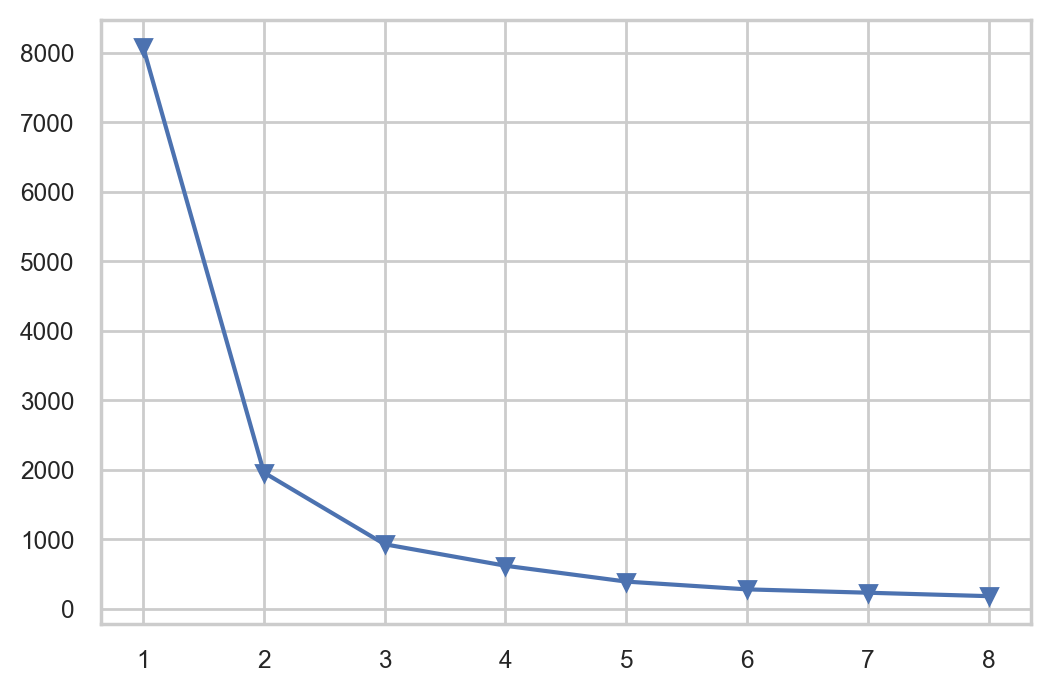

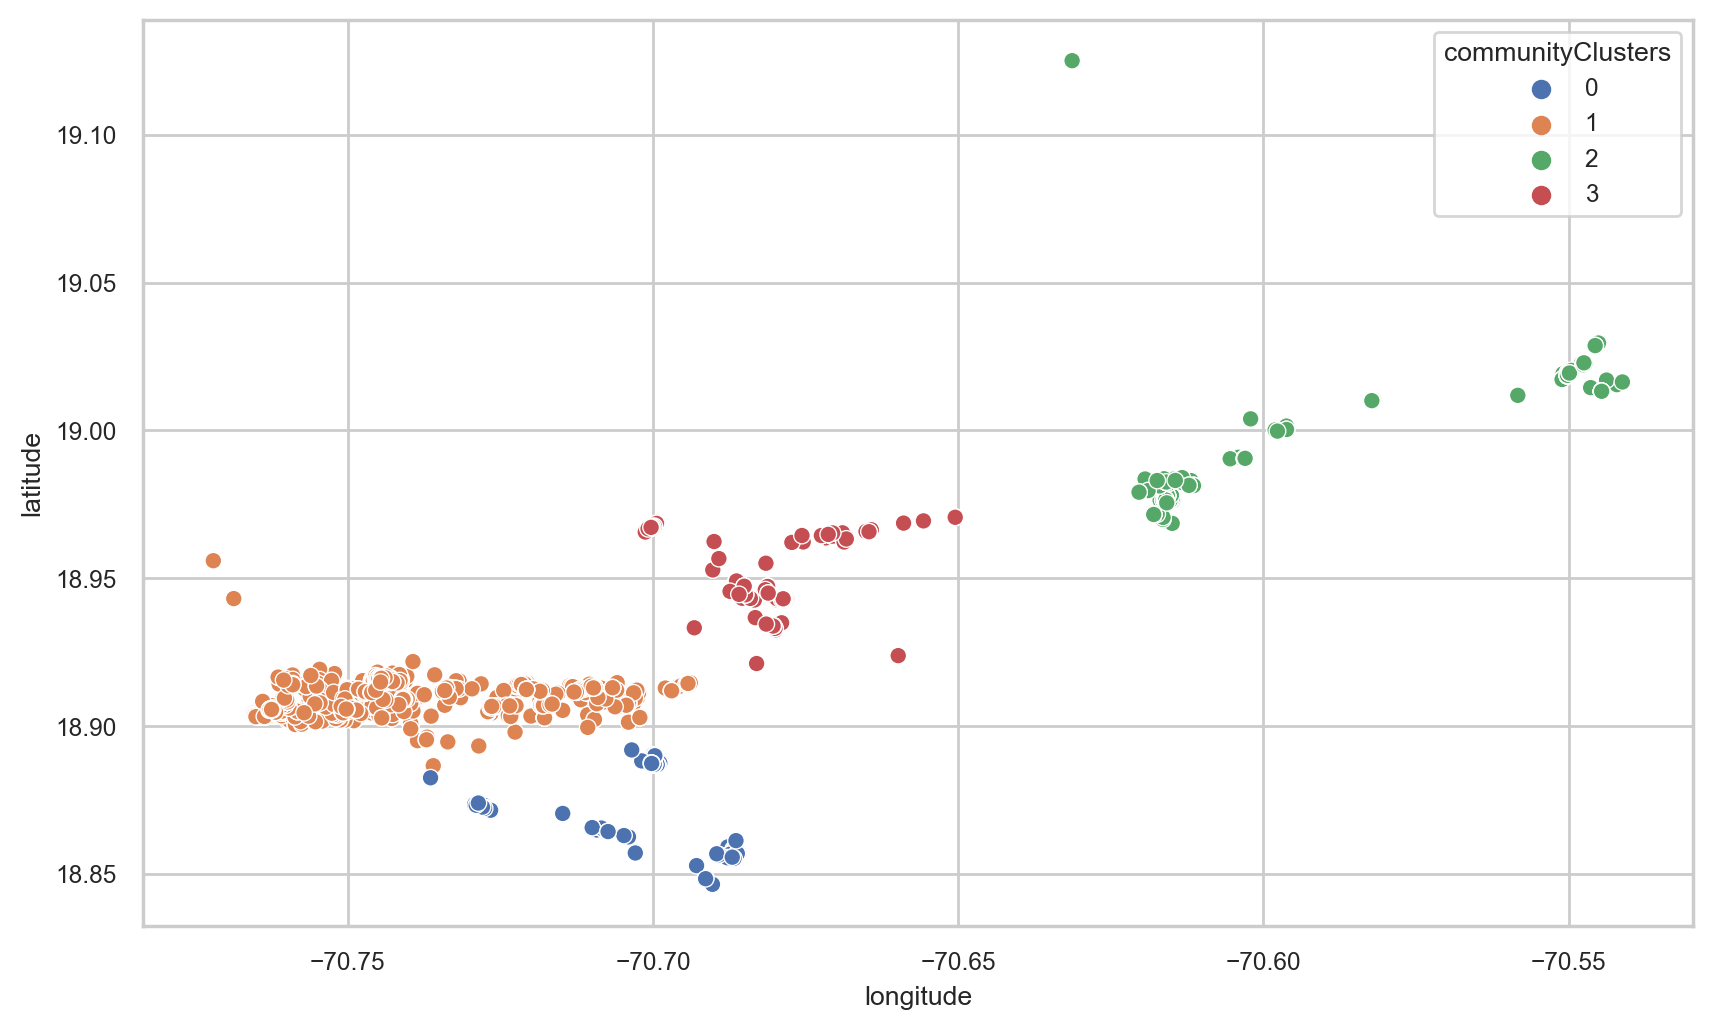

In [33]:
Lavega_trans = model_inertias(Lavega_survey)
Lavega_survey_clustered = choosing_clusters(Lavega_survey, Lavega_trans, 4)

In [34]:
# assigning culsters to community names
def Lavega_community(com):
    if com == 0:
        return "Col Hungara"
    elif com == 1:
        return "Constanza"
    elif com == 2:
        return "Arroyo Frio"
    else:
        return "Tireo"

In [35]:
Lavega_survey_clustered["community"] = Lavega_survey_clustered["communityClusters"].apply(Lavega_community)

In [36]:
Lavega_survey_clustered.community.value_counts()

Constanza      2957
Arroyo Frio     499
Tireo           434
Col Hungara     151
Name: community, dtype: int64

### 3.2 Creating Communities in San Pedro de Macoris Province

For n_clusters = 2 The average silhouette_score is : 0.7149467149353006
For n_clusters = 3 The average silhouette_score is : 0.5816817722863707
For n_clusters = 4 The average silhouette_score is : 0.6581979081097465
For n_clusters = 5 The average silhouette_score is : 0.734857442803802
For n_clusters = 6 The average silhouette_score is : 0.7908350872559945


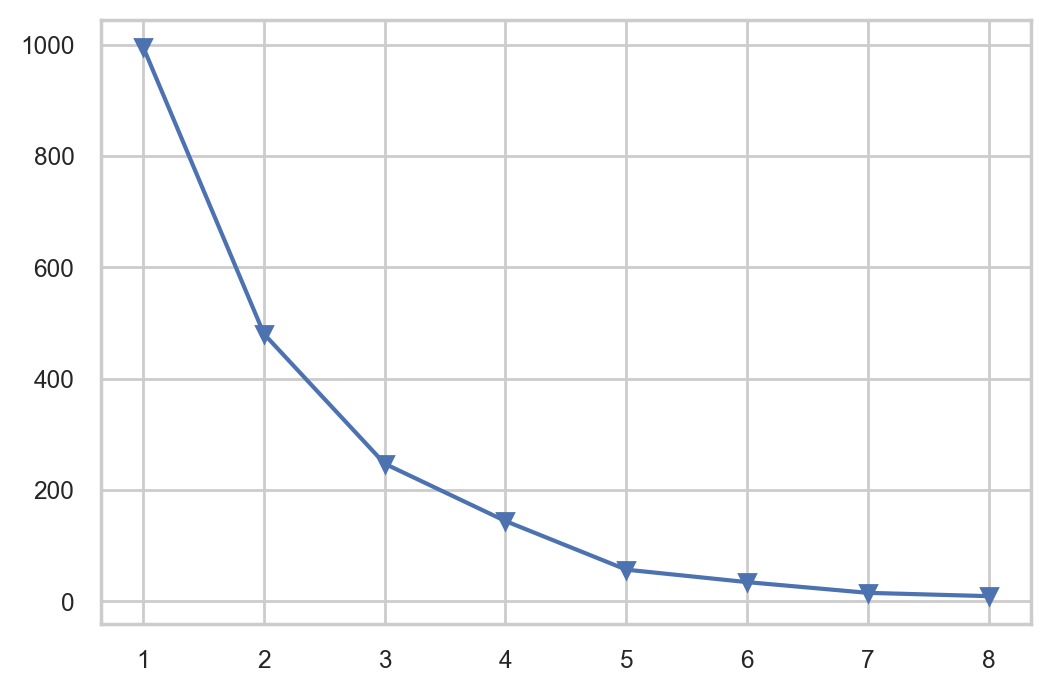

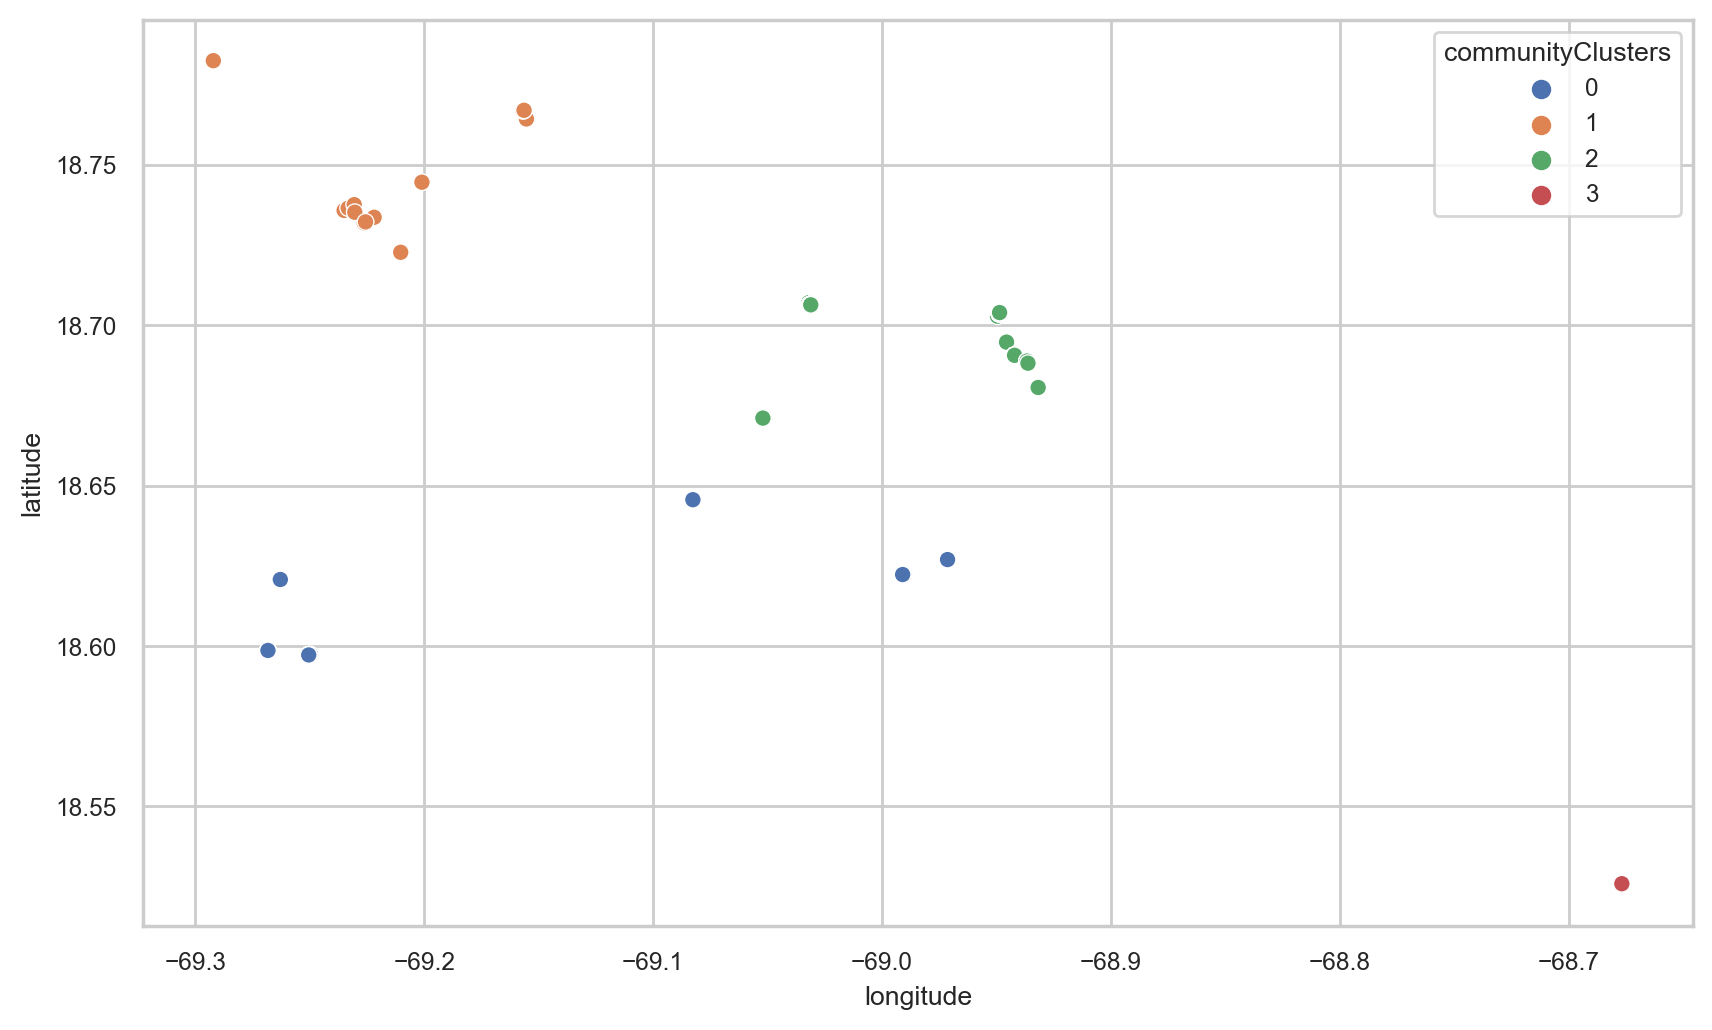

In [37]:
sp_trans = model_inertias(sp_survey)
sp_survey_clustered = choosing_clusters(sp_survey, sp_trans, 4)

In [38]:
def sp_community(com):
    if com == 0:
        return "San Pedro de Macoris"
    elif com == 1:
        return "Consuelo"
    elif com == 2:
        return "La Romana"
    else:
        return "Santo Domingo Norte"

In [39]:
sp_survey_clustered["community"] = sp_survey_clustered["communityClusters"].apply(sp_community)

In [40]:
sp_survey_clustered.community.value_counts()

La Romana               259
San Pedro de Macoris    170
Santo Domingo Norte      40
Consuelo                 29
Name: community, dtype: int64

### 3.3 Creating Communities in San Pedro de Macoris North Province

For n_clusters = 2 The average silhouette_score is : 0.9581726749129171
For n_clusters = 3 The average silhouette_score is : 0.9607897037587001
For n_clusters = 4 The average silhouette_score is : 0.9626910164402782
For n_clusters = 5 The average silhouette_score is : 0.9725976440871977
For n_clusters = 6 The average silhouette_score is : 0.9335091997093159


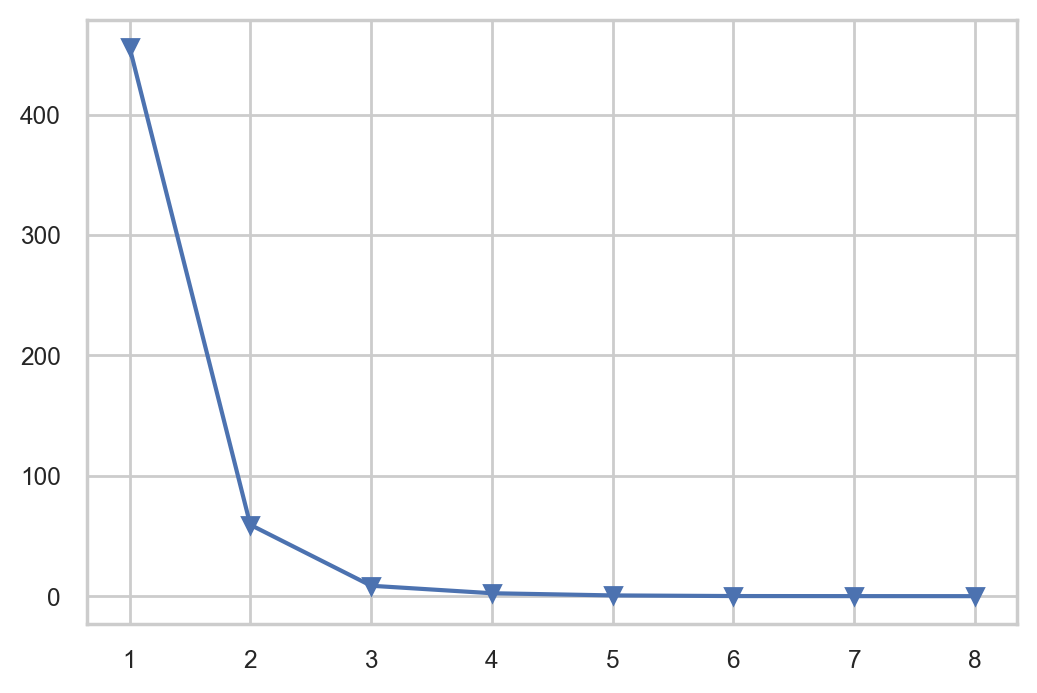

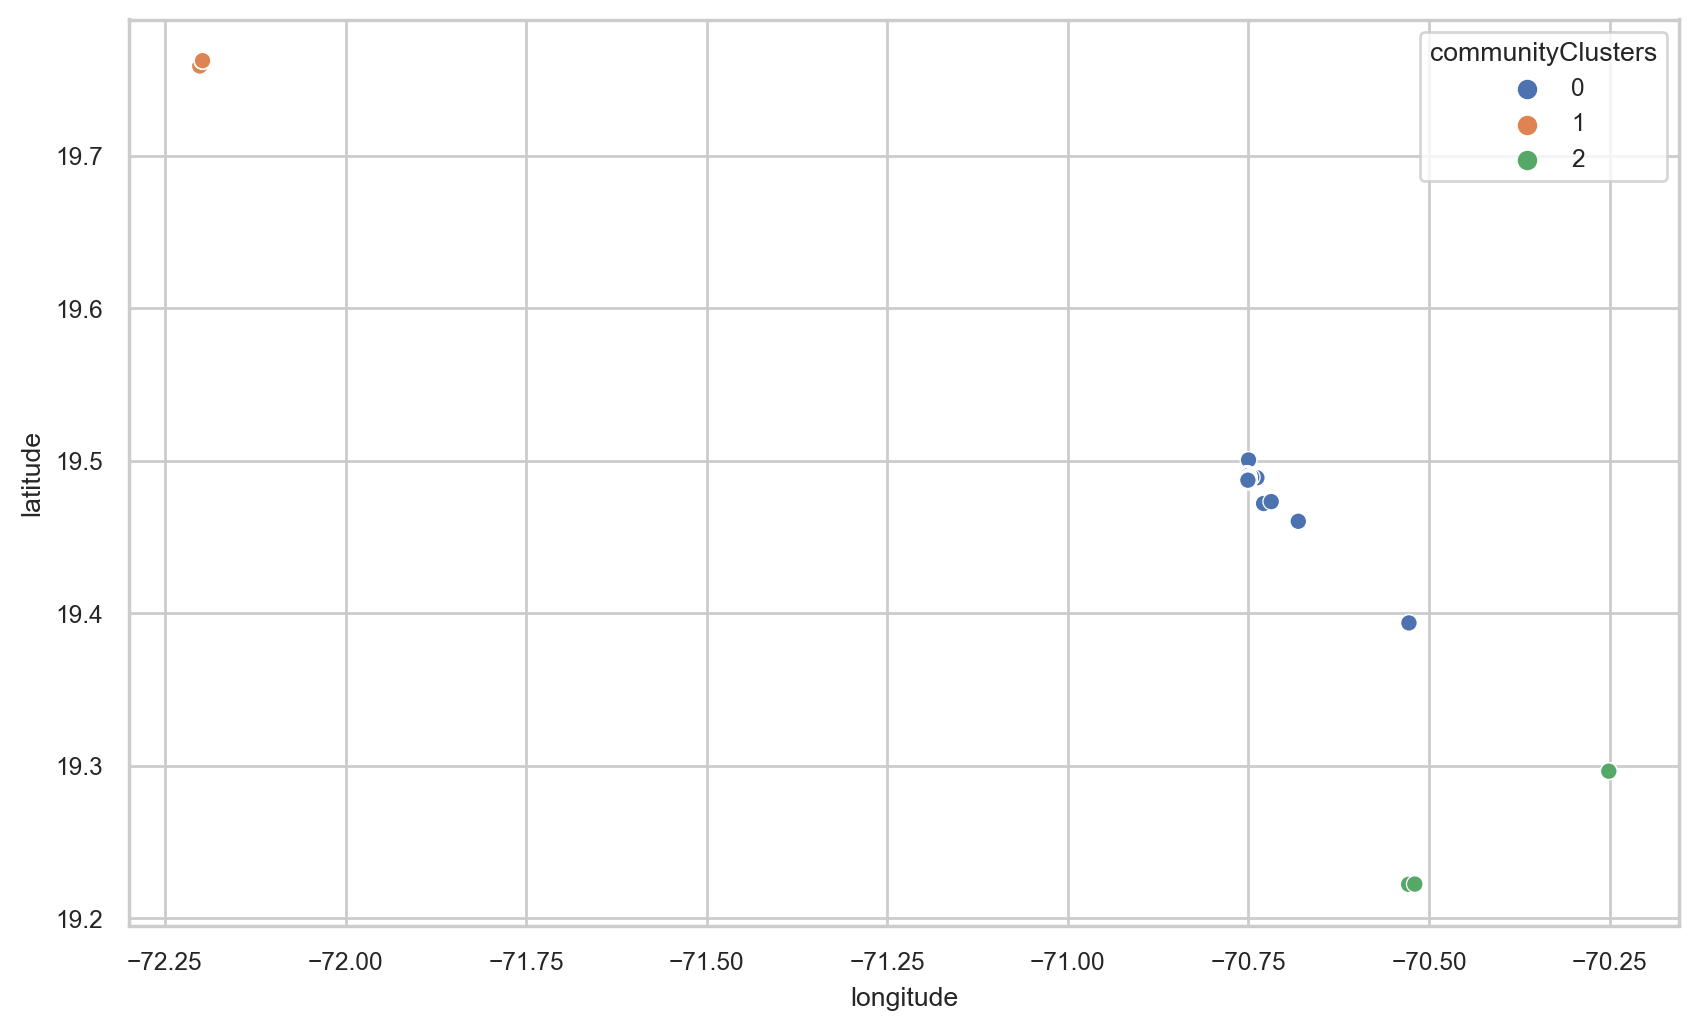

In [41]:
spn_trans = model_inertias(sp_north_survey)
spn_survey_clustered = choosing_clusters(sp_north_survey, spn_trans, 3)

In [42]:
def spn_community(com):
    if com == 0:
        return "Aleman"
    elif com == 1:
        return "Hato Mayor Del Rey"
    else:
        return "La Higuera"

In [43]:
spn_survey_clustered["community"] = spn_survey_clustered["communityClusters"].apply(spn_community)

In [44]:
spn_survey_clustered.community.value_counts()

Aleman                204
Hato Mayor Del Rey     17
La Higuera              7
Name: community, dtype: int64

### 3.4 Creating Communities in Santiago Province

For n_clusters = 2 The average silhouette_score is : 0.49752460326411535
For n_clusters = 3 The average silhouette_score is : 0.5701900017224654
For n_clusters = 4 The average silhouette_score is : 0.5845235265399303
For n_clusters = 5 The average silhouette_score is : 0.5624447753273712
For n_clusters = 6 The average silhouette_score is : 0.5860050492354654


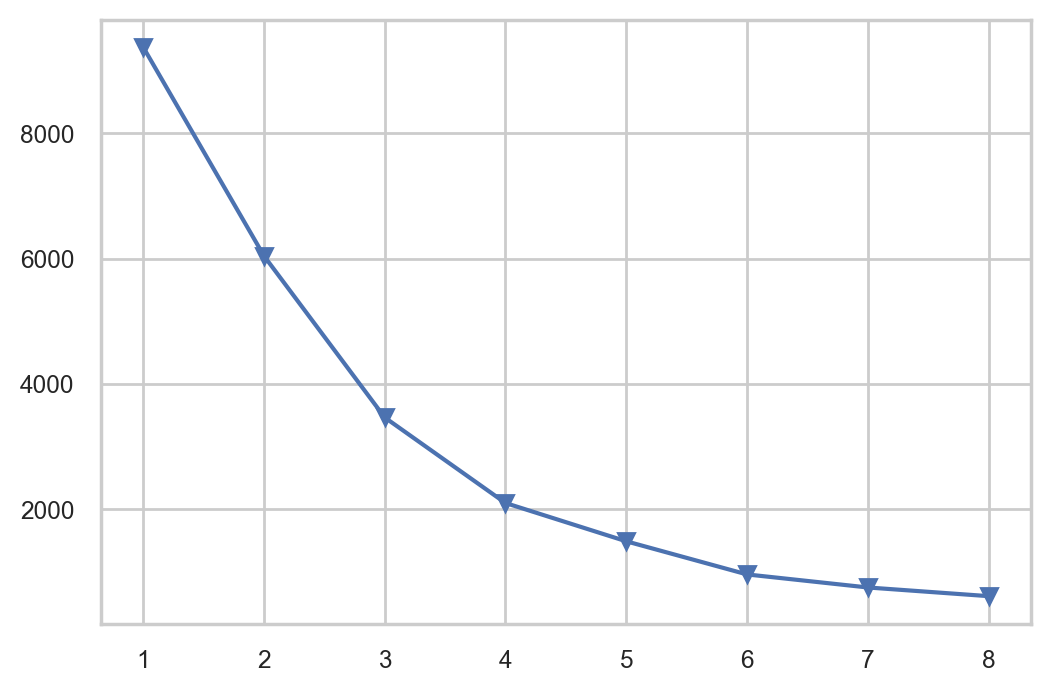

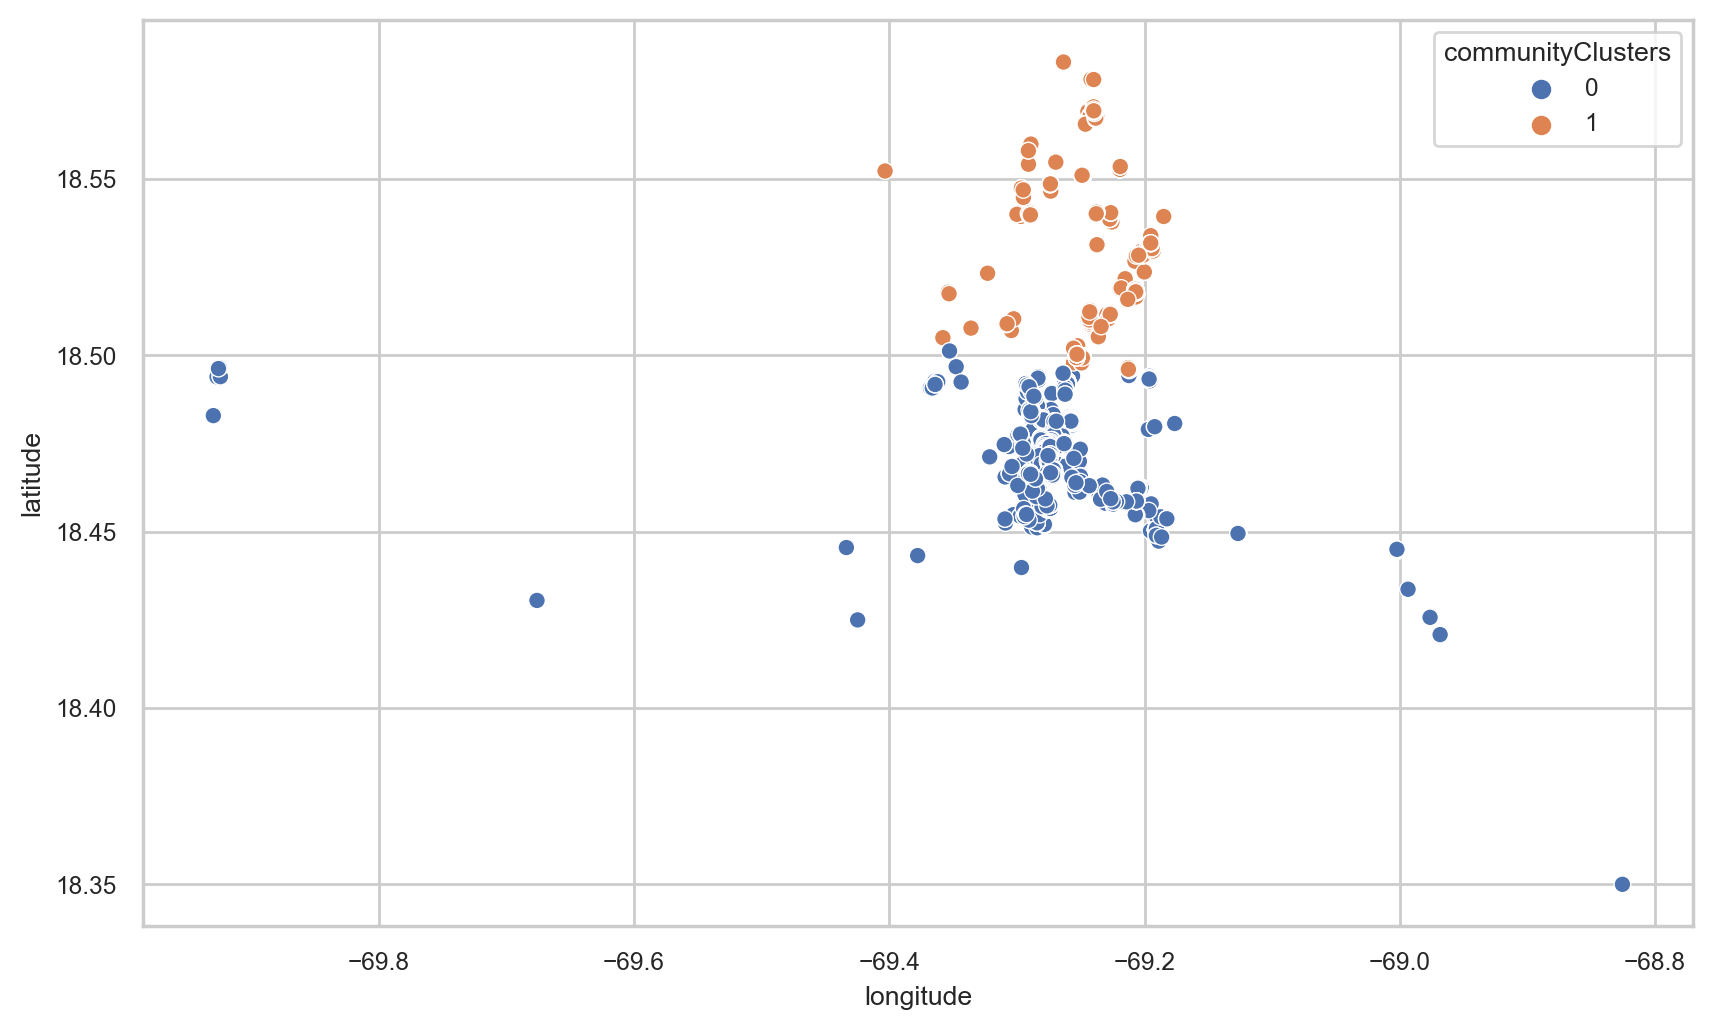

In [45]:
santiago_trans = model_inertias(santiago_survey)
santiago_survey_clustered = choosing_clusters(santiago_survey, santiago_trans, 2)

In [46]:
def santiago_community(com):
    if com == 0:
        return "Santiago De Los Caballeros"
    else:
        return "Cap-Haitien"

In [47]:
santiago_survey_clustered["community"] = santiago_survey_clustered["communityClusters"].apply(santiago_community)

In [48]:
santiago_survey_clustered.community.value_counts()

Santiago De Los Caballeros    3054
Cap-Haitien                   1634
Name: community, dtype: int64

### 3.5 Concating Province Dataframes into One Dataframe

In [49]:
survey_clustered = pd.concat([Lavega_survey_clustered, sp_survey_clustered, spn_survey_clustered, santiago_survey_clustered]).drop(columns = ["communityClusters", "clustersByLoc"])
survey_clustered.isna().sum()

objectId             0
marriageStatus    1596
occupation           0
educationLevel    1483
latitude             0
longitude            0
age                482
sex                  0
province             0
community            0
dtype: int64

# 4. Data Analysis

### 4.1 Merging History_env and Survey_vitals Datasets

We merged Survey_vitals and Histroy_env datasets in order to find the biggest environmental issues in DR communities. Hirstory_env has environmental data and Survey_vitals dataset includes province and community data. The resulting dataframe enables us to analyse distributions of environmental data in DR communities. 

In [50]:
survey_environ = survey_clustered.merge(history_env, how = "inner", on = "objectId")
survey_environ.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  lLkC5HGPOC          widow  Ama de casa  lessThanprimary  18.914416   
1  gIoG2SAL99          widow        Other  lessThanprimary  18.914196   
2  GiArohoFUo        married        Other          college  18.910474   
3  rnNw8AxEix         single  Ama de casa          primary  18.910484   
4  YBLTPHNqsH      concubine        Other  lessThanprimary  18.915163   

   longitude   age     sex province  community  ... conditionoRoofinyourhouse  \
0 -70.745642  67.0  female  La Vega  Constanza  ...                   working   
1 -70.746286  80.0    male  La Vega  Constanza  ...                      poor   
2 -70.747658  41.0  female  La Vega  Constanza  ...                       NaN   
3 -70.747650  40.0  female  La Vega  Constanza  ...                   working   
4 -70.741626  59.0    male  La Vega  Constanza  ...                   working   

  medicalproblemswheredoyougo dentalproblemswheredoyougo  \
0              Other Hospital             Other Hospital   
1              Other Hospital                    Dentist   
2                       Other                     Clinic   
3              Other Hospital                      Other   
4                      Clinic                      Other   

  biggestproblemofcommunity timesperweektrashcollected  \
0                     Roads                        1-2   
1                     Roads                        1-2   
2                     Other                        3-5   
3                     Water                        1-2   
4                     Other                        1-2   

  wheretrashleftbetweenpickups numberofIndividualsLivingintheHouse  \
0                        other                                   1   
1                        other                                   5   
2                        other                                   4   
3                        other                                   4   
4                       street                                   4   

  numberofChildrenLivinginHouseUndertheAgeof5 houseownership bathroomAccess  
0                                           0         rented            NaN  
1                                           0          owned            NaN  
2                                           0            NaN            NaN  
3                                           0            NaN            NaN  
4                                           0            NaN            NaN  

[5 rows x 25 columns]

In [51]:
# distribution of respondents by provinces
survey_environ.province.value_counts()

La Vega                       2623
Santiago                      2555
San Pedro de Macoris/North     211
San Pedro de Macoris            34
Name: province, dtype: int64

### 4.2 Province Level Environmental Data Analysis

In [52]:
# building a function that enables to see distributions of different features by provinces
def by_province(df, feature):
    sns.set(font_scale = 0.8, font="Roboto")
    sns.set_style("whitegrid", {'font.family':'Roboto'})
    res_df = pd.crosstab(index = df[feature], columns = df["province"]).reset_index()
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    fig.set_size_inches(8,8)
    plt.tight_layout(pad=0.4, w_pad=5.0, h_pad=7.0)
    ax1 = sns.barplot(x = feature, y = "La Vega", data = res_df, ax = ax1, color="#FFE680")
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, horizontalalignment='right', wrap=True)
    ax1.set_title("Distribution of " + feature + "\n Types in La Vega", fontsize = 11, wrap=True)
    ax1.set_ylabel("Count", fontsize = 10)

    
    ax2 = sns.barplot(x = feature, y = "Santiago", data = res_df, ax = ax2, color="#3D80FC")
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize = 10, wrap=True)
    ax2.set_title("Distribution of " + feature + "\n Types in Santiago", fontsize = 11, wrap=True)    
    ax2.set_ylabel("Count", fontsize = 10)
    
    ax3 = sns.barplot(x = feature, y = "San Pedro de Macoris", data = res_df, ax = ax3, color="#3D80FC")
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize = 10, wrap=True)
    ax3.set_title("Distribution of " + feature + "\n Types in San Pedro", fontsize = 11, wrap=True)      
    ax3.set_ylabel("Count", fontsize = 10)
    
    ax4 = sns.barplot(x = feature, y = "San Pedro de Macoris/North", data = res_df, ax = ax4, color="#FFE680")
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize = 10, wrap=True)
    ax4.set_title("Distribution of " + feature + "\n Types in San Pedro/North", fontsize = 11, wrap=True)
    ax4.set_ylabel("Count", fontsize = 10)

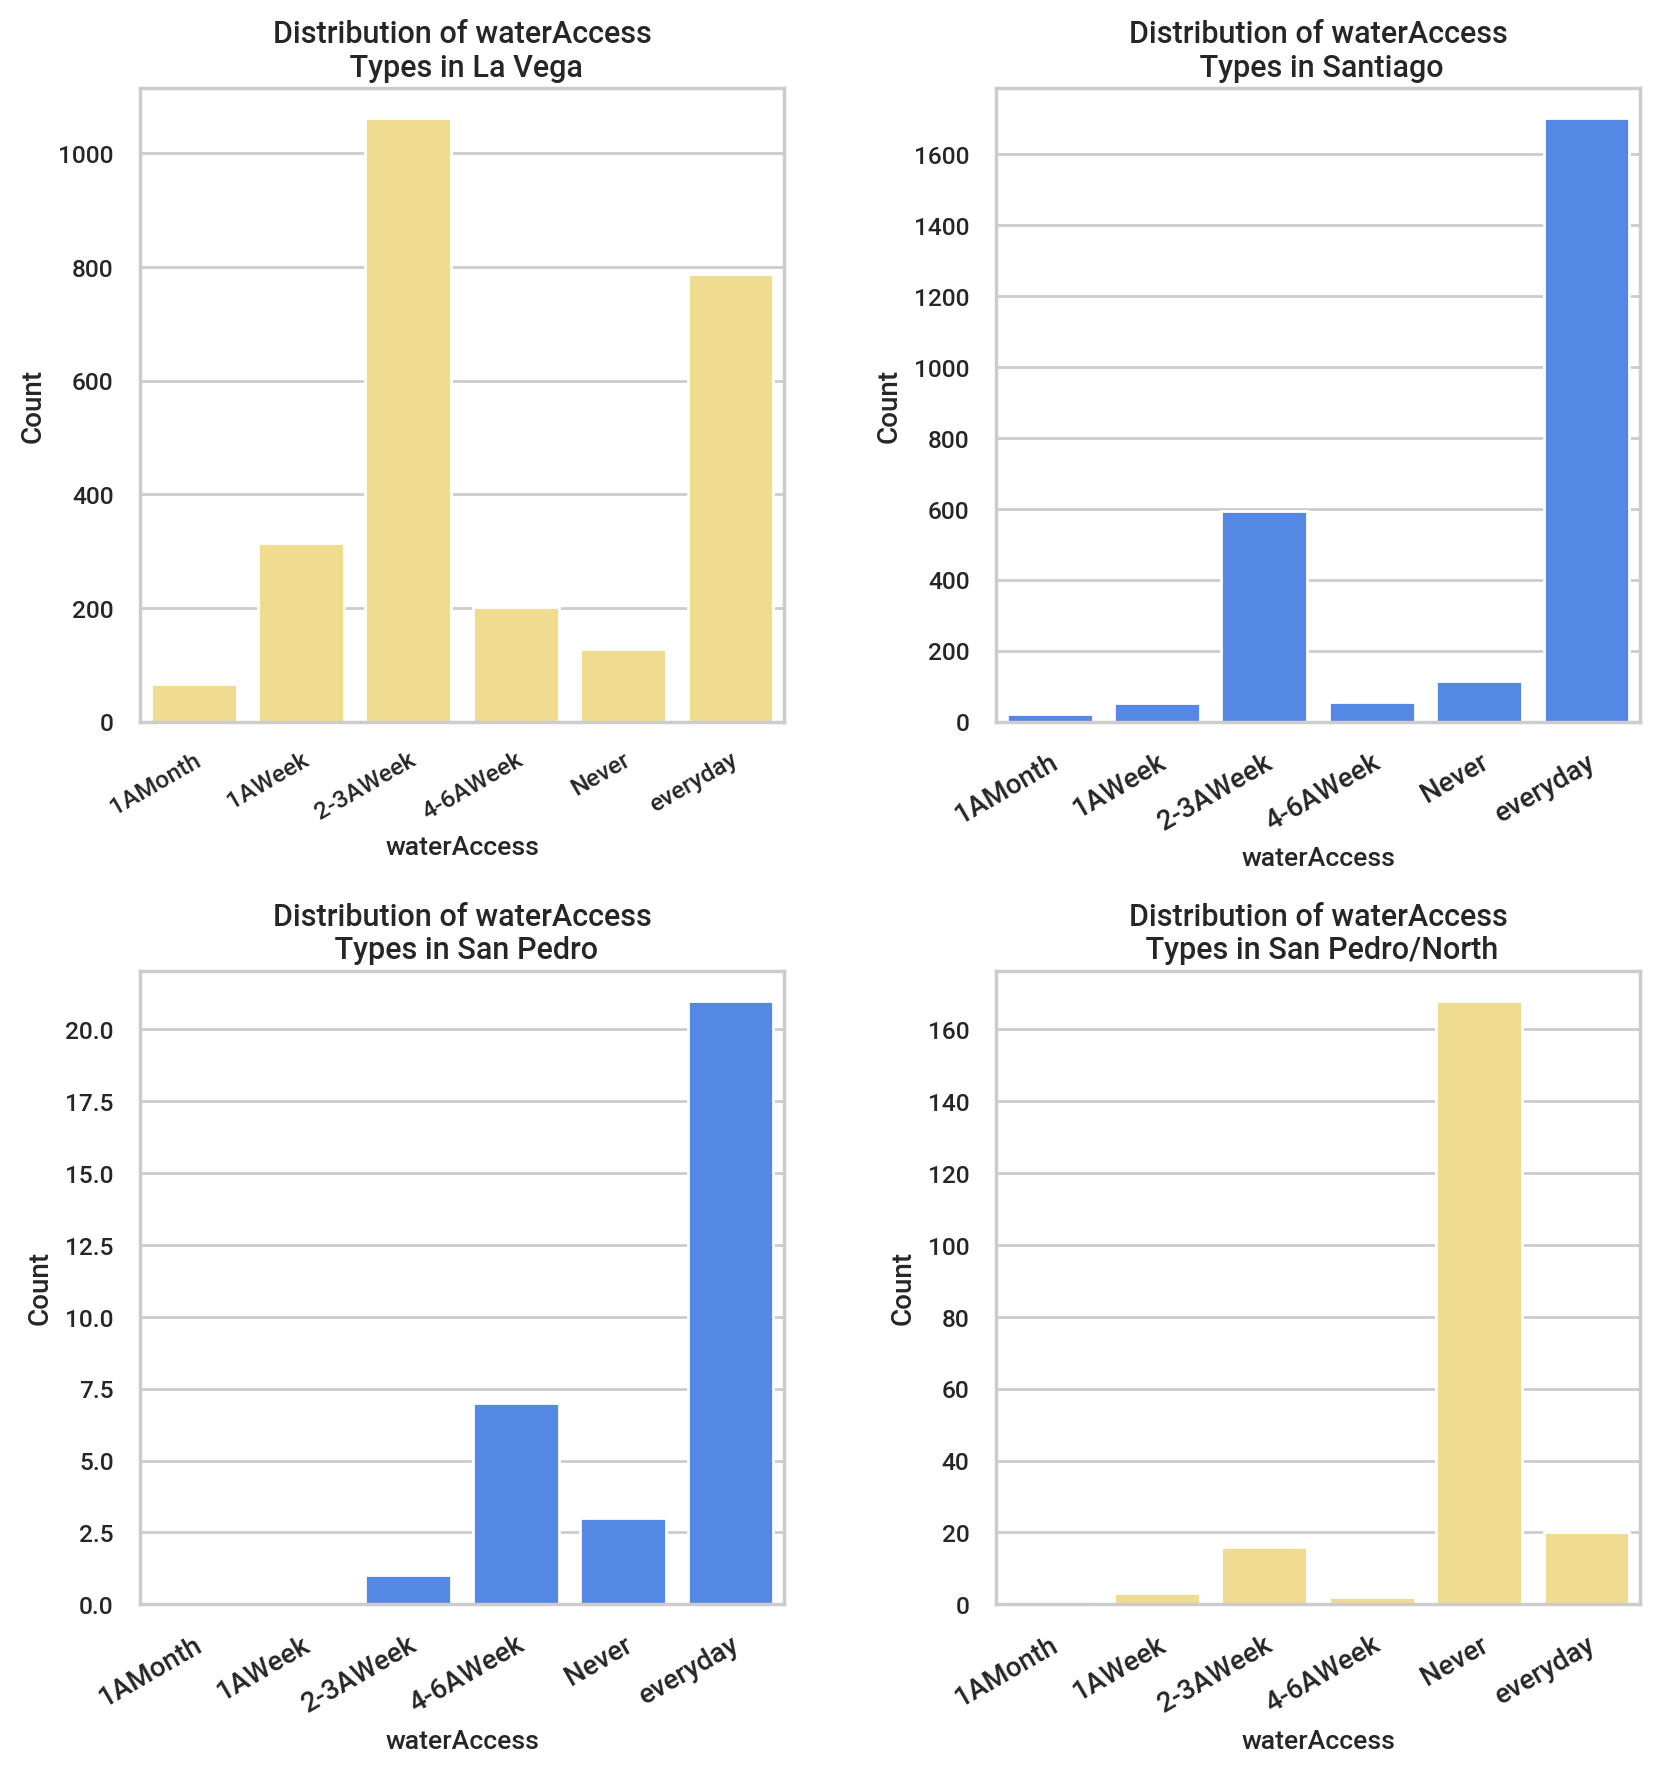

In [53]:
# ex. waterAccess distribution by provinces
by_province(survey_environ, "waterAccess")

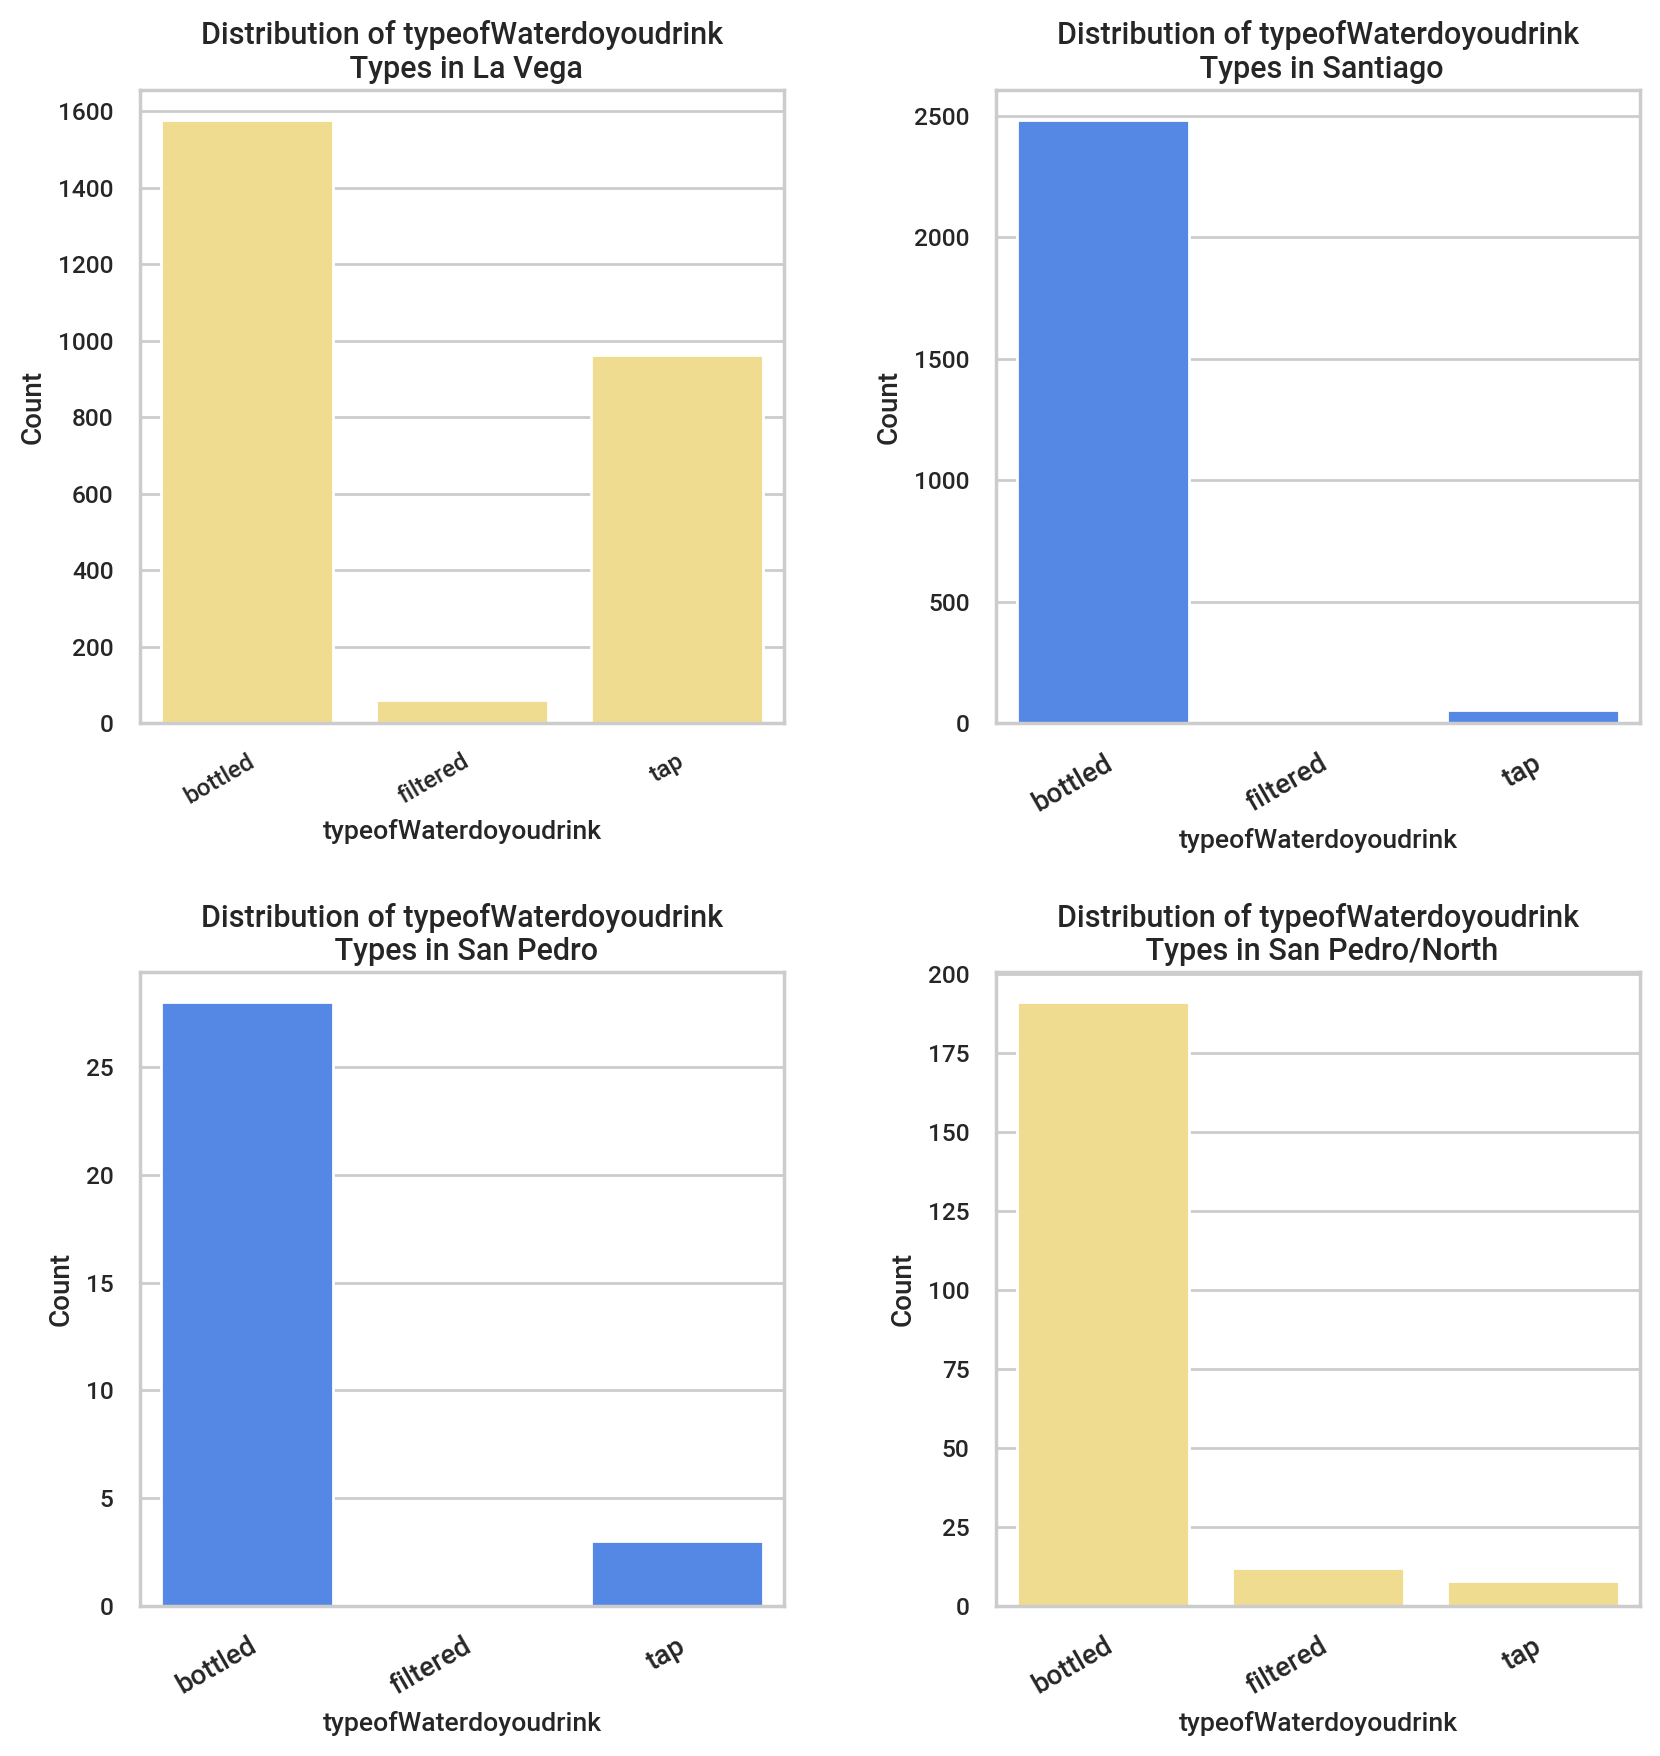

In [54]:
# ex. typeofWaterdoyoudrink distribution by provinces
by_province(survey_environ, "typeofWaterdoyoudrink")

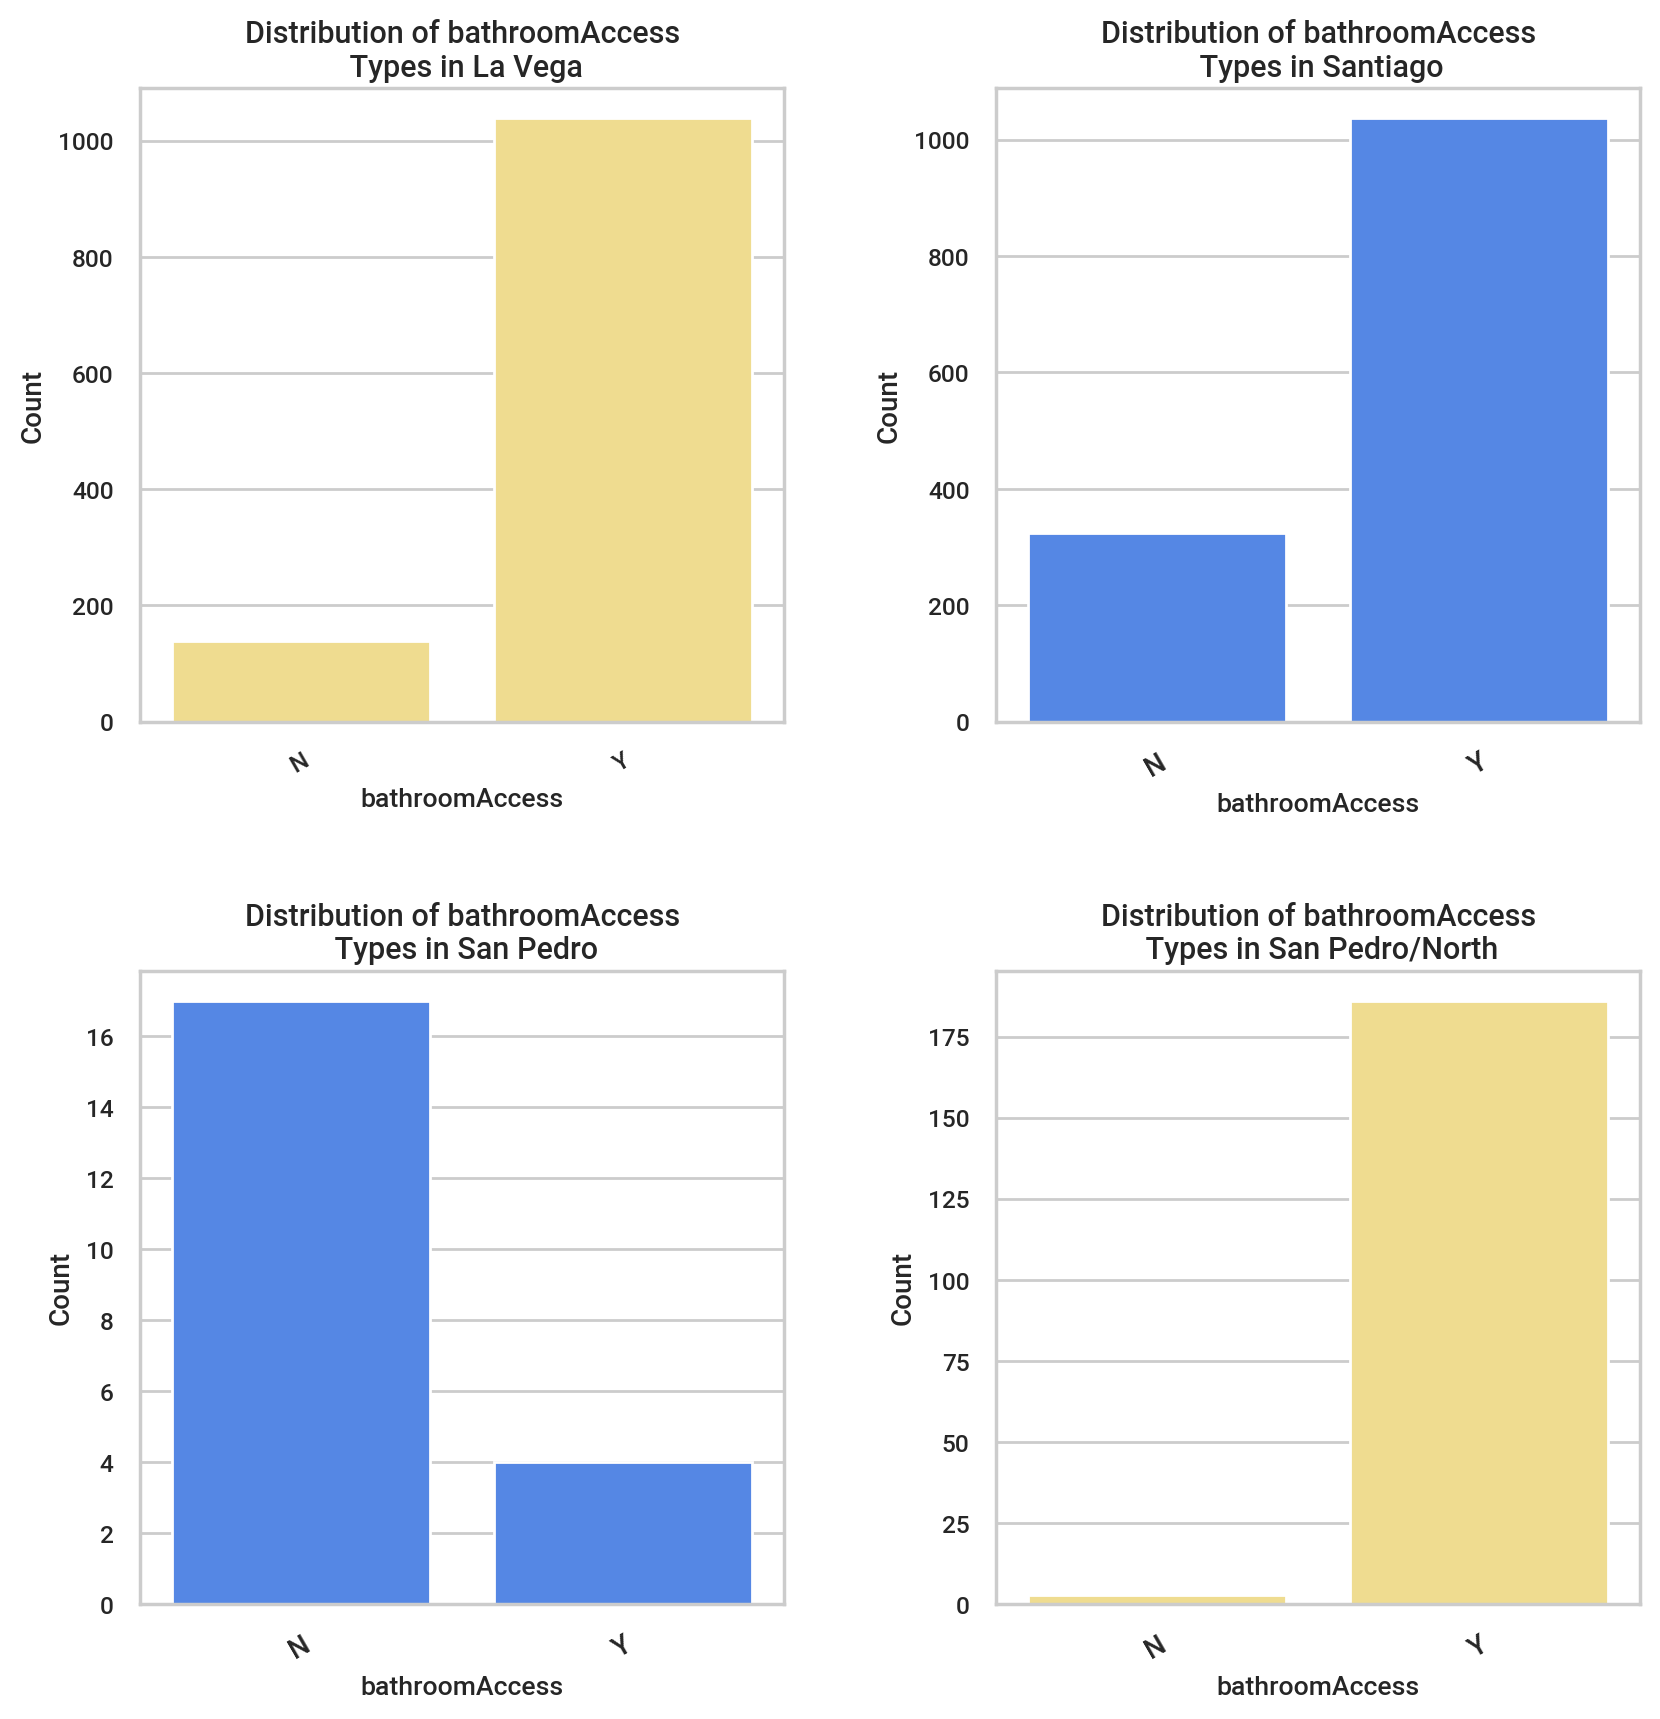

In [55]:
# ex. bathroomAccess distribution by provinces
by_province(survey_environ, "bathroomAccess")

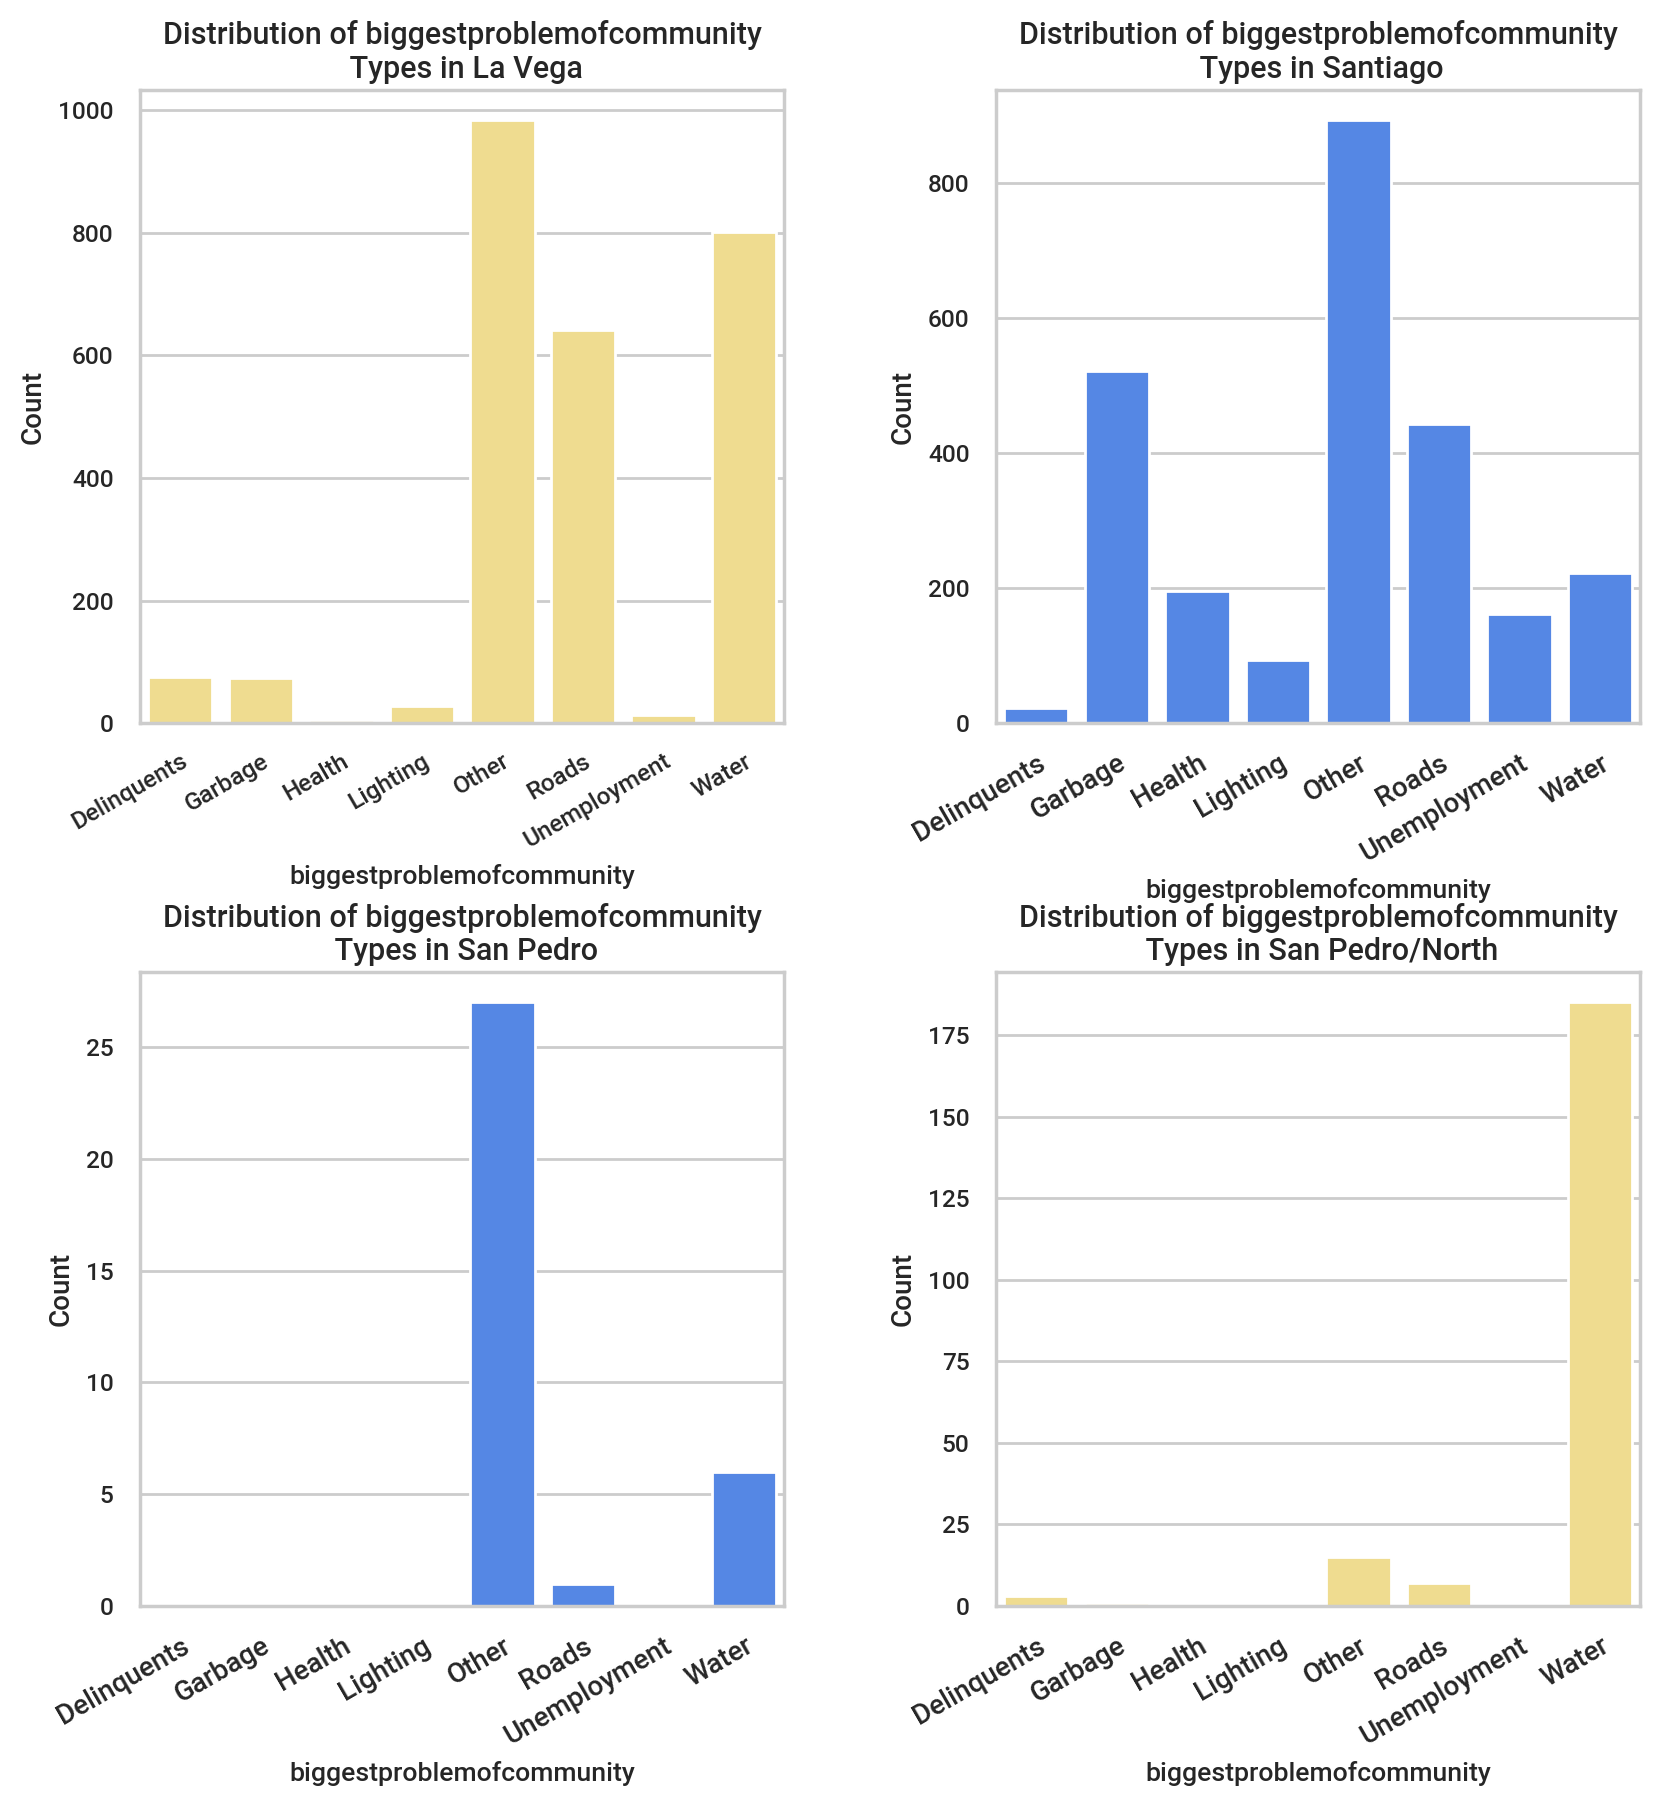

In [56]:
# ex. biggestproblemofcommunity distribution by provinces
by_province(survey_environ, "biggestproblemofcommunity")

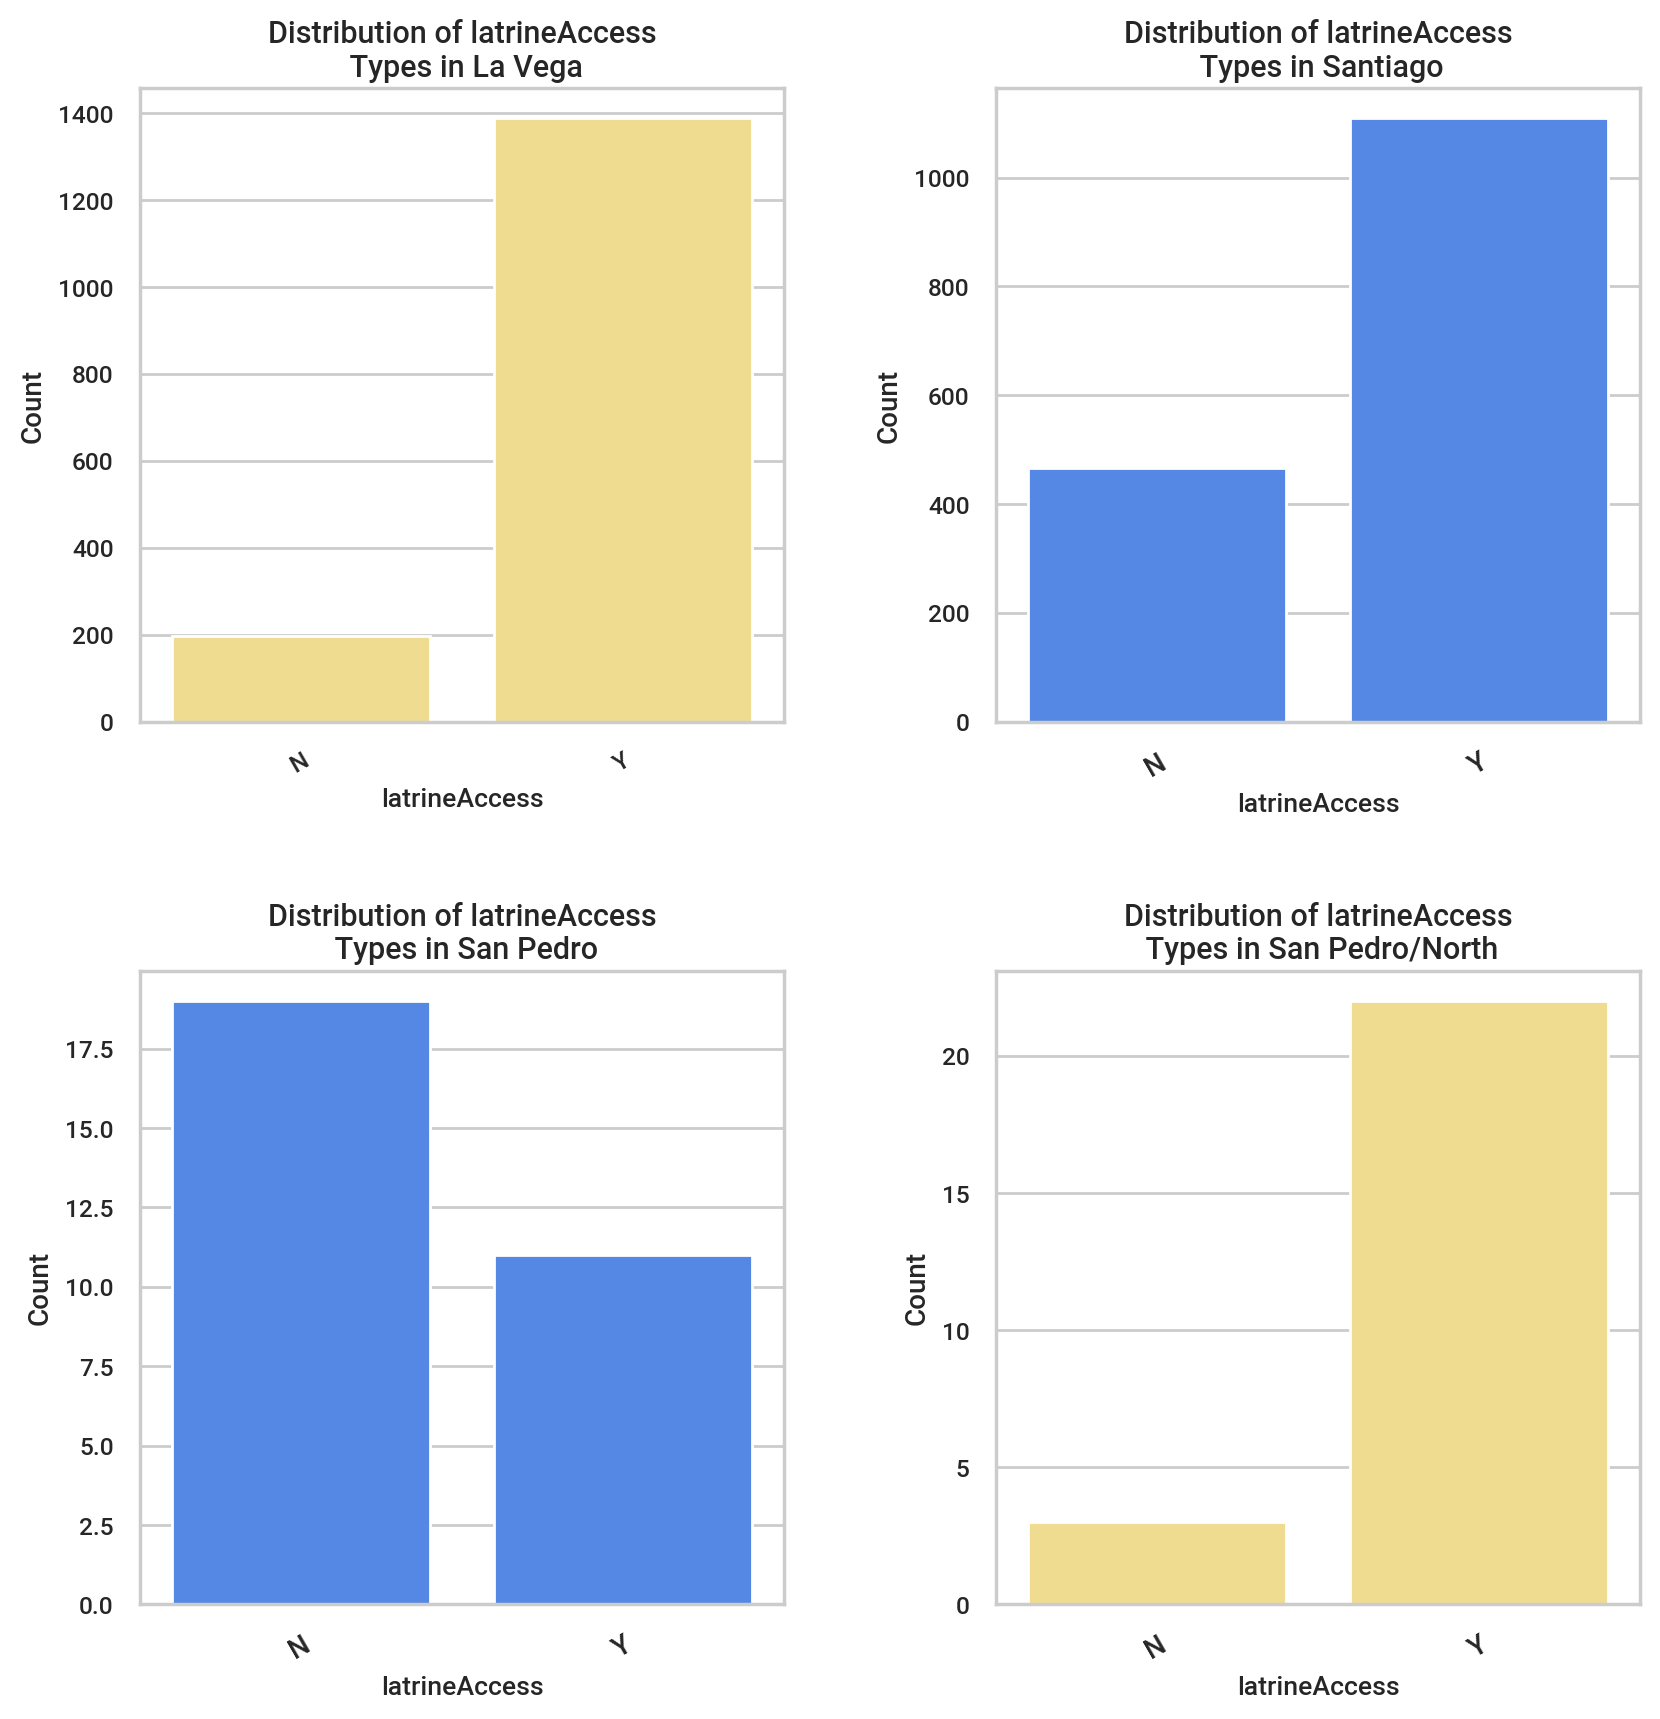

In [57]:
# ex. latrineAccess distribution by provinces
by_province(survey_environ, "latrineAccess")

### 4.3 Community Level Environmental Data Analysis

In [58]:
# building a function that enables to see distributions of different features by communities in each province
def env_by_community(feature):
        
         for province in list(survey_environ.province.unique()):

            df = survey_environ[survey_environ["province"] == province]
            df_env = pd.crosstab(index = df[feature], columns = df["community"])
            comm_list = list(df_env.columns)

            if len(comm_list) == 4:
                fig, axes = plt.subplots(2,2, constrained_layout=True)
                fig.set_size_inches(10,8)
        
            elif len(comm_list) == 3:
                fig, axes = plt.subplots(2,2, constrained_layout=True)
                fig.set_size_inches(10,8)
            else:
                fig, axes = plt.subplots(1,2, constrained_layout=True)
                fig.set_size_inches(10,4)
    
            plt.tight_layout(pad=0.4, w_pad=5.0, h_pad=6.0)

            for (comm, ax) in zip(comm_list, axes.flatten()[:len(comm_list)]):
                sns.set_style("whitegrid", {'font.family':'Roboto'})
                sns.barplot(x = df_env.index, y = comm, data = df_env, ax = ax, color="#FFE680")
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
                ax.set_title("Distribution of " + feature + " Types in " + comm + "\n" + province, fontsize = 11)
                ax.set_ylabel("Count", fontsize=10)

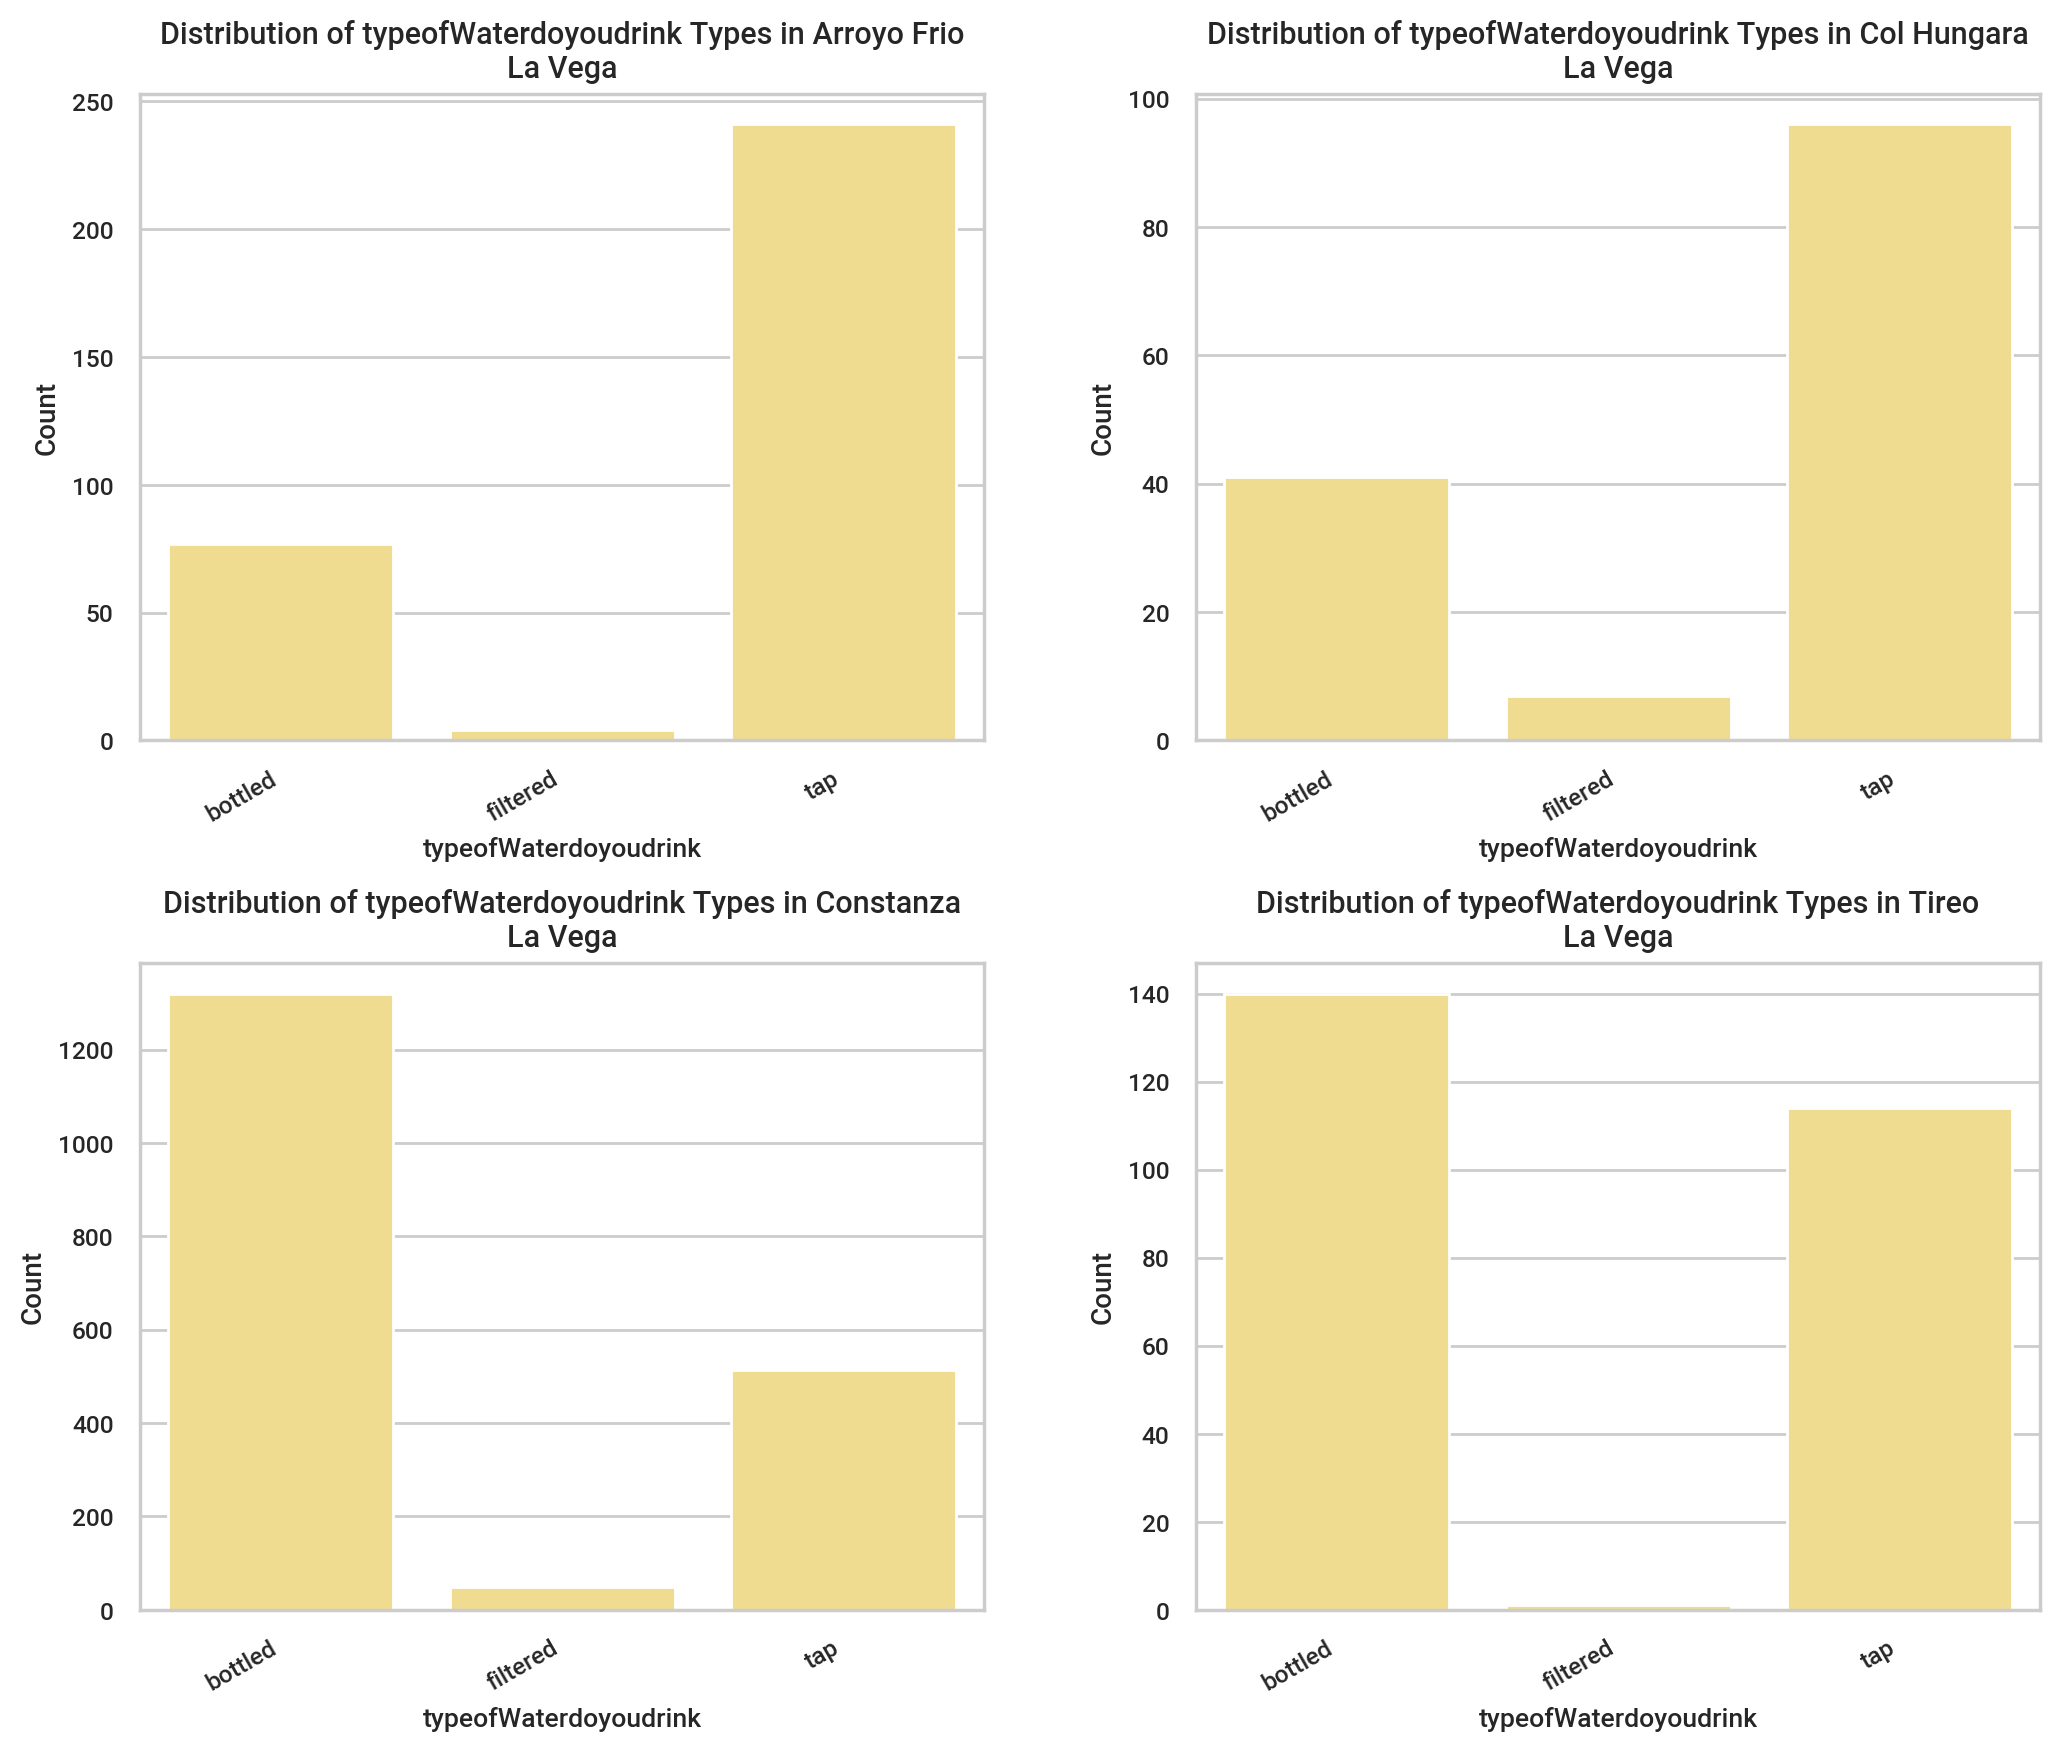

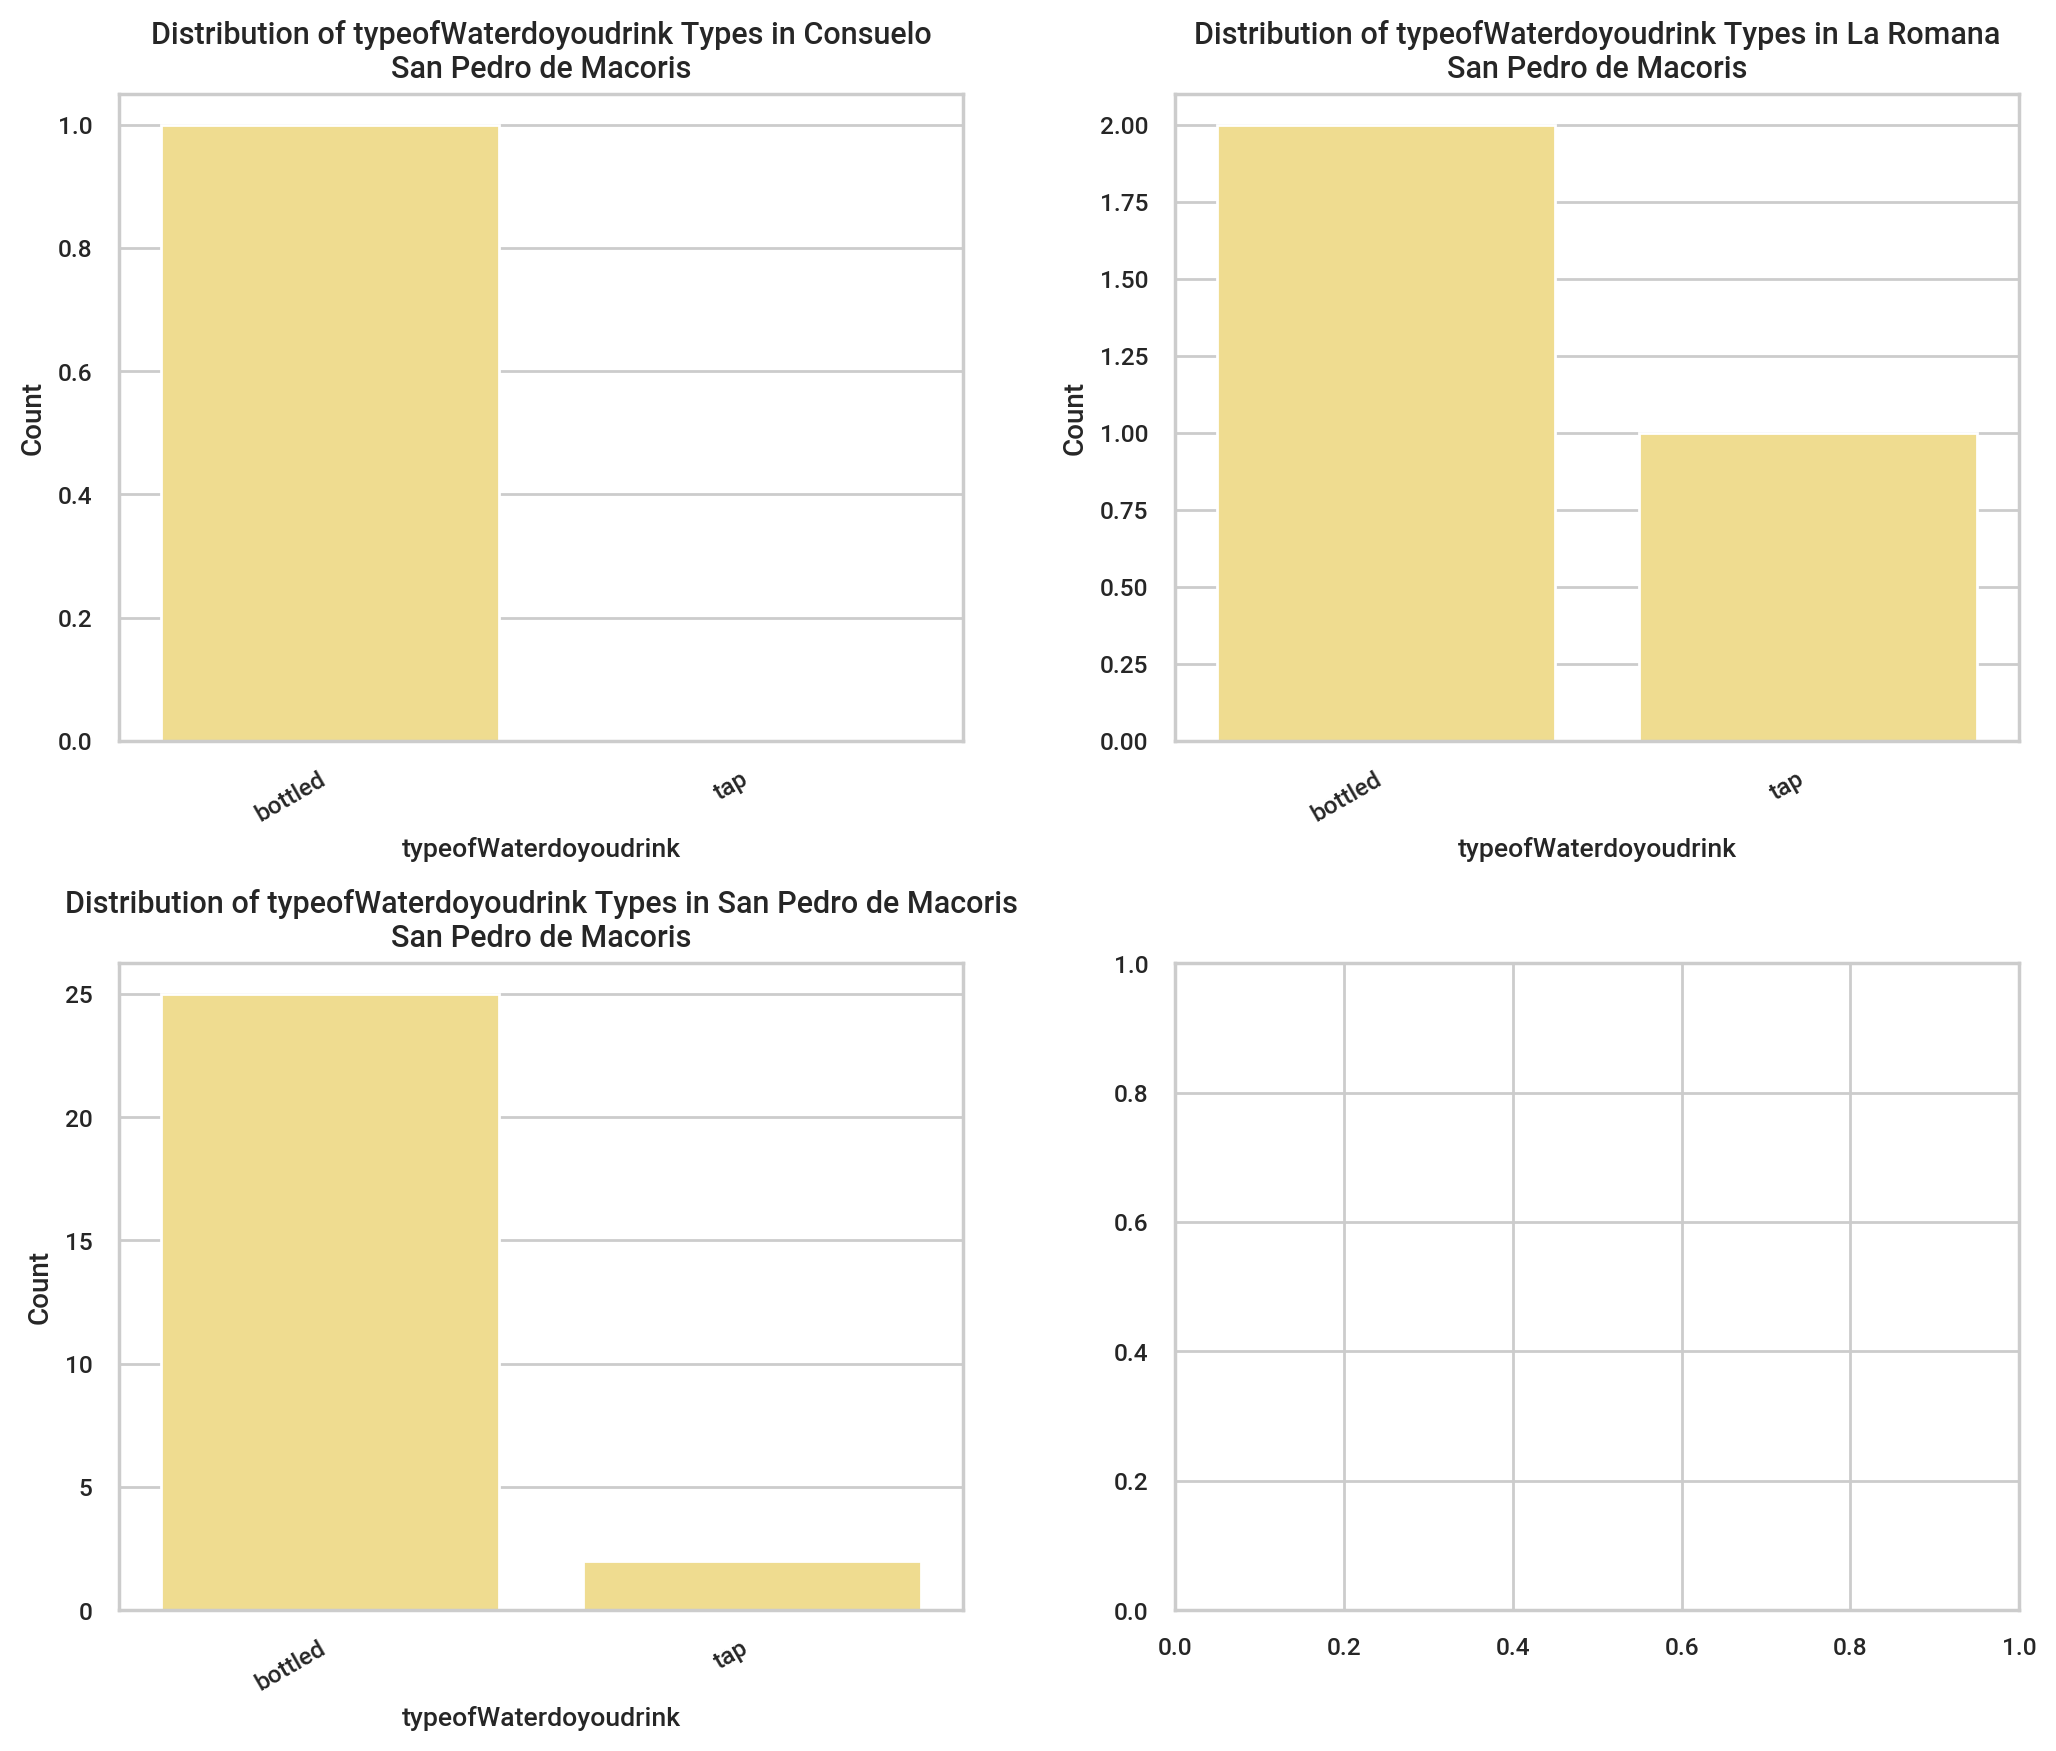

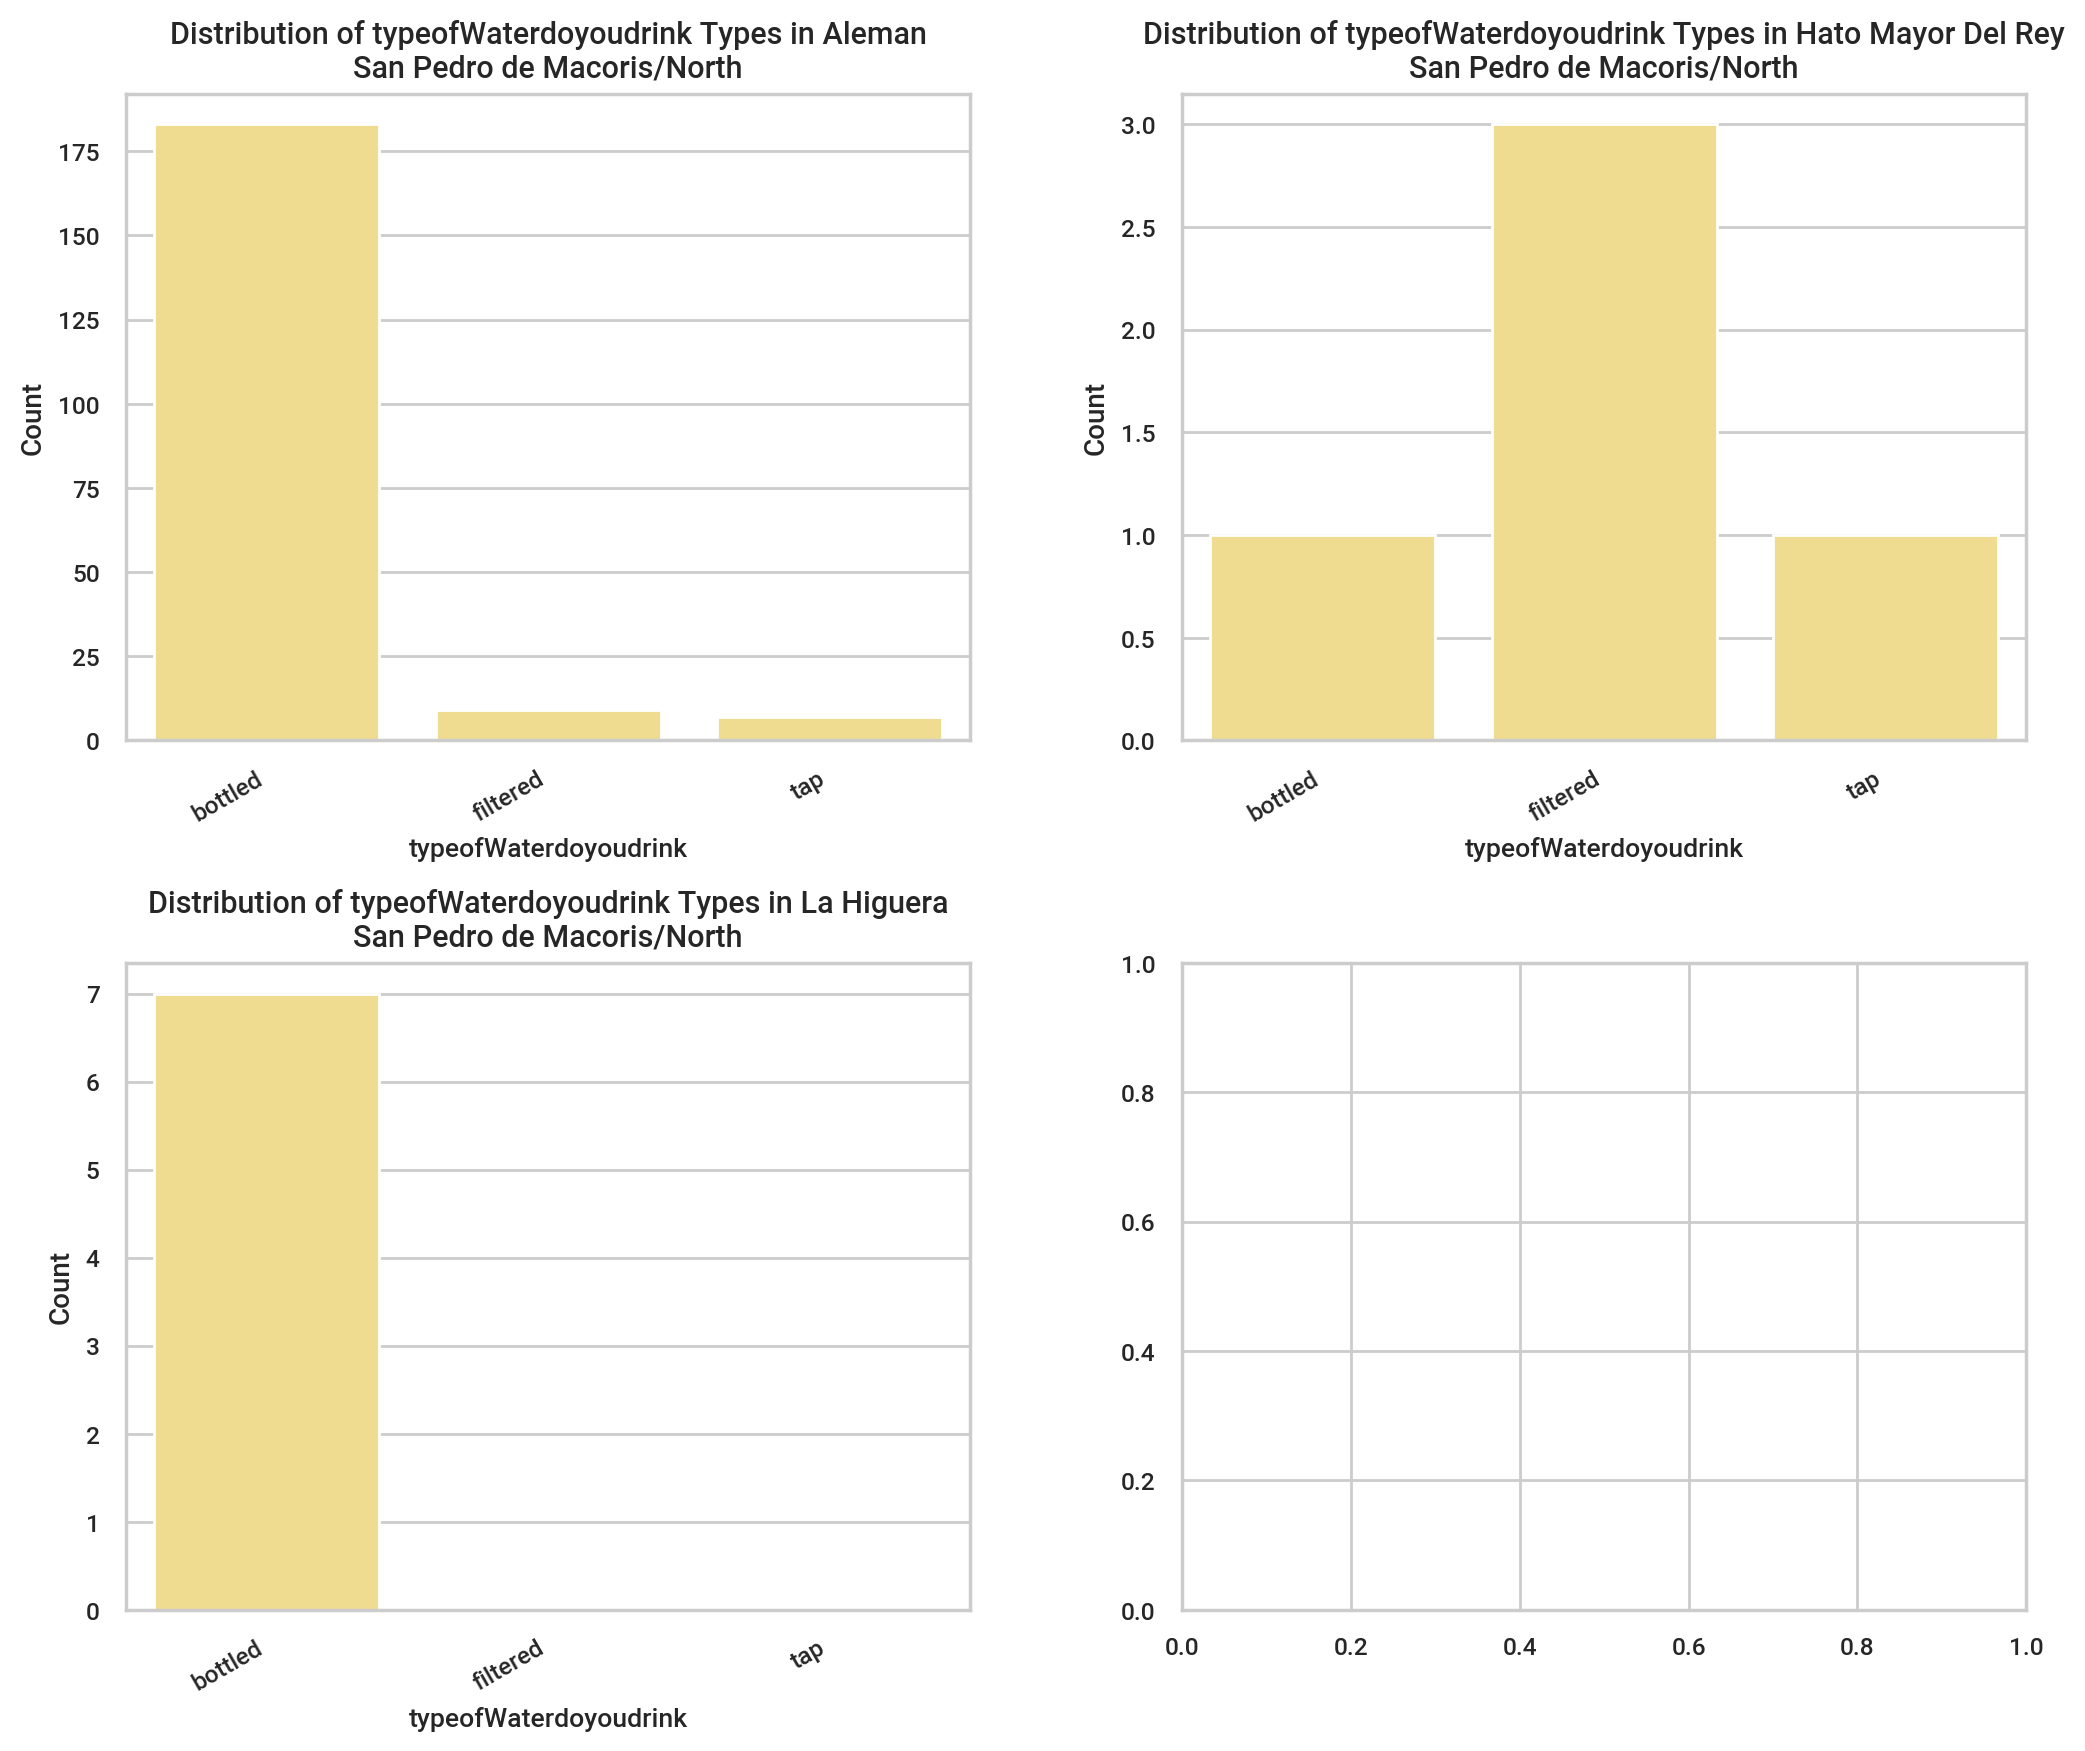

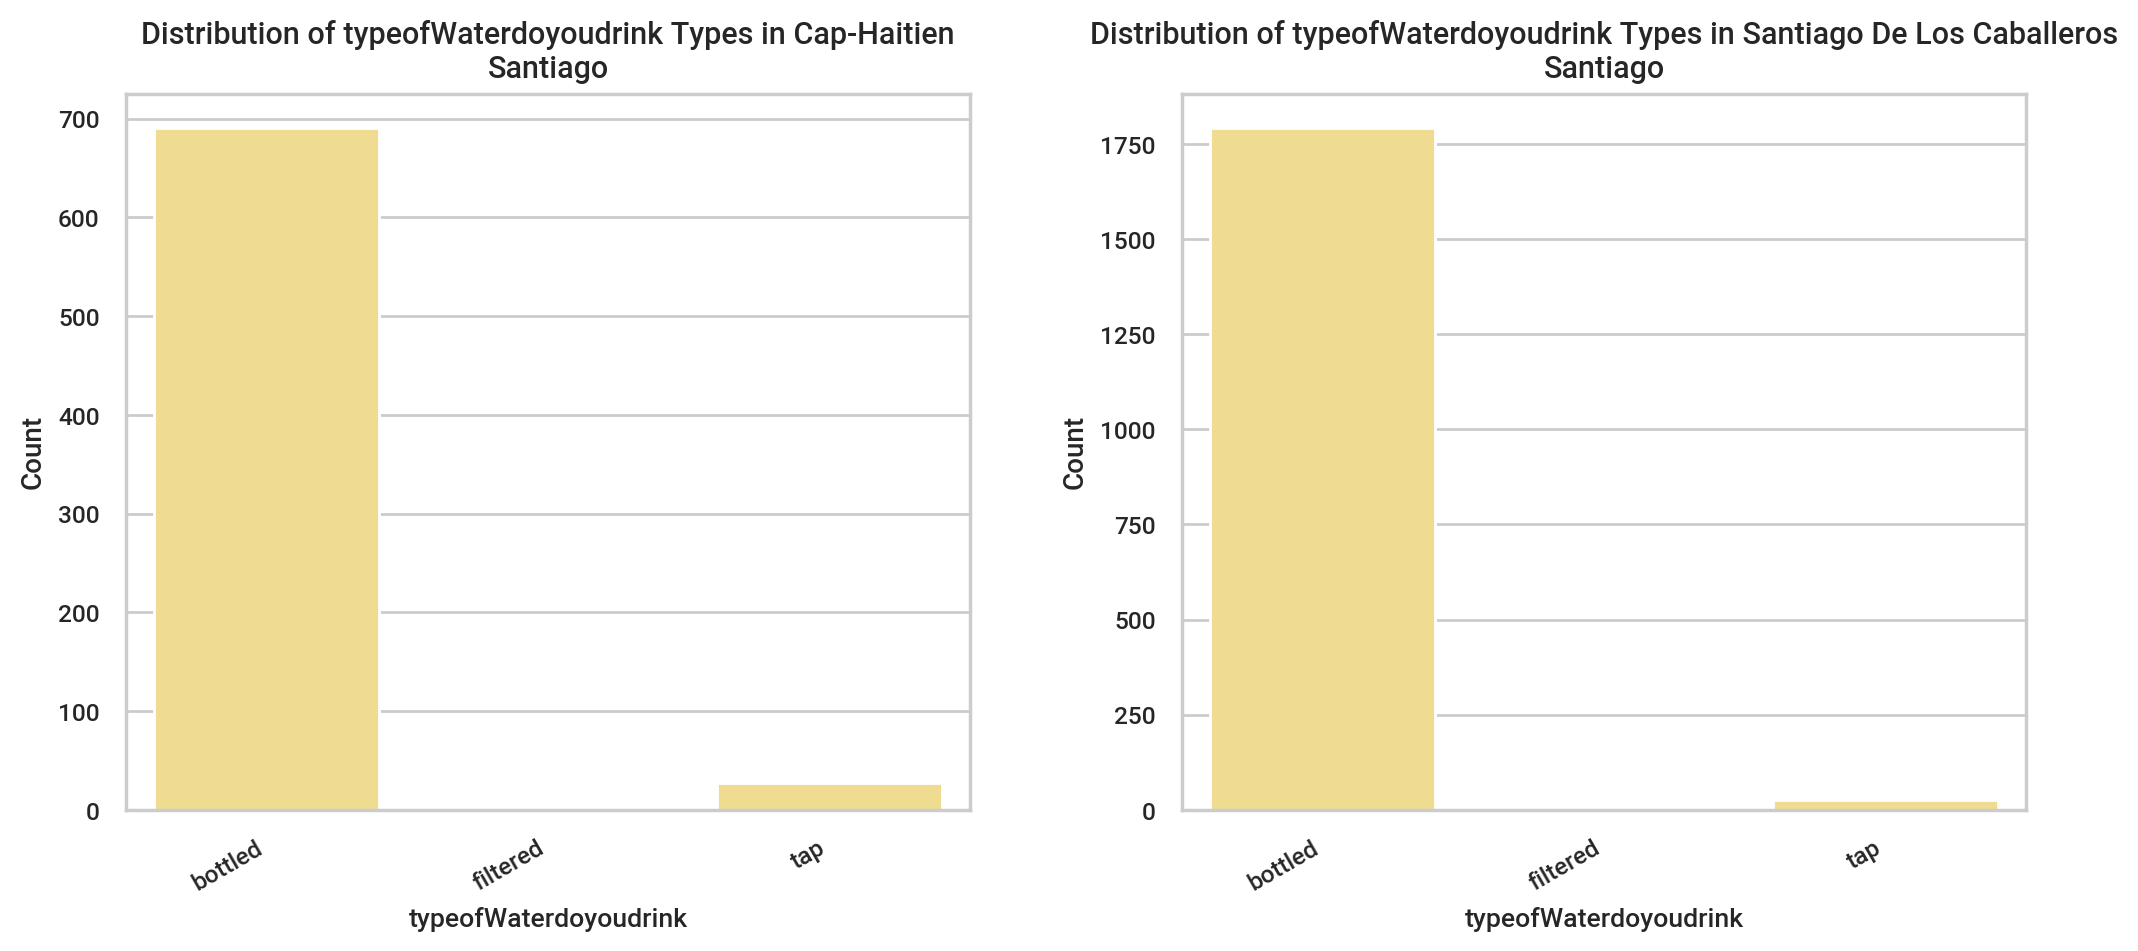

In [59]:
# ex. typeofWaterdoyoudrink distribution by communities in each province
# one subgraph is empty because there are only three (not four) communities in San Pedro De Macoris/North province
env_by_community('typeofWaterdoyoudrink')

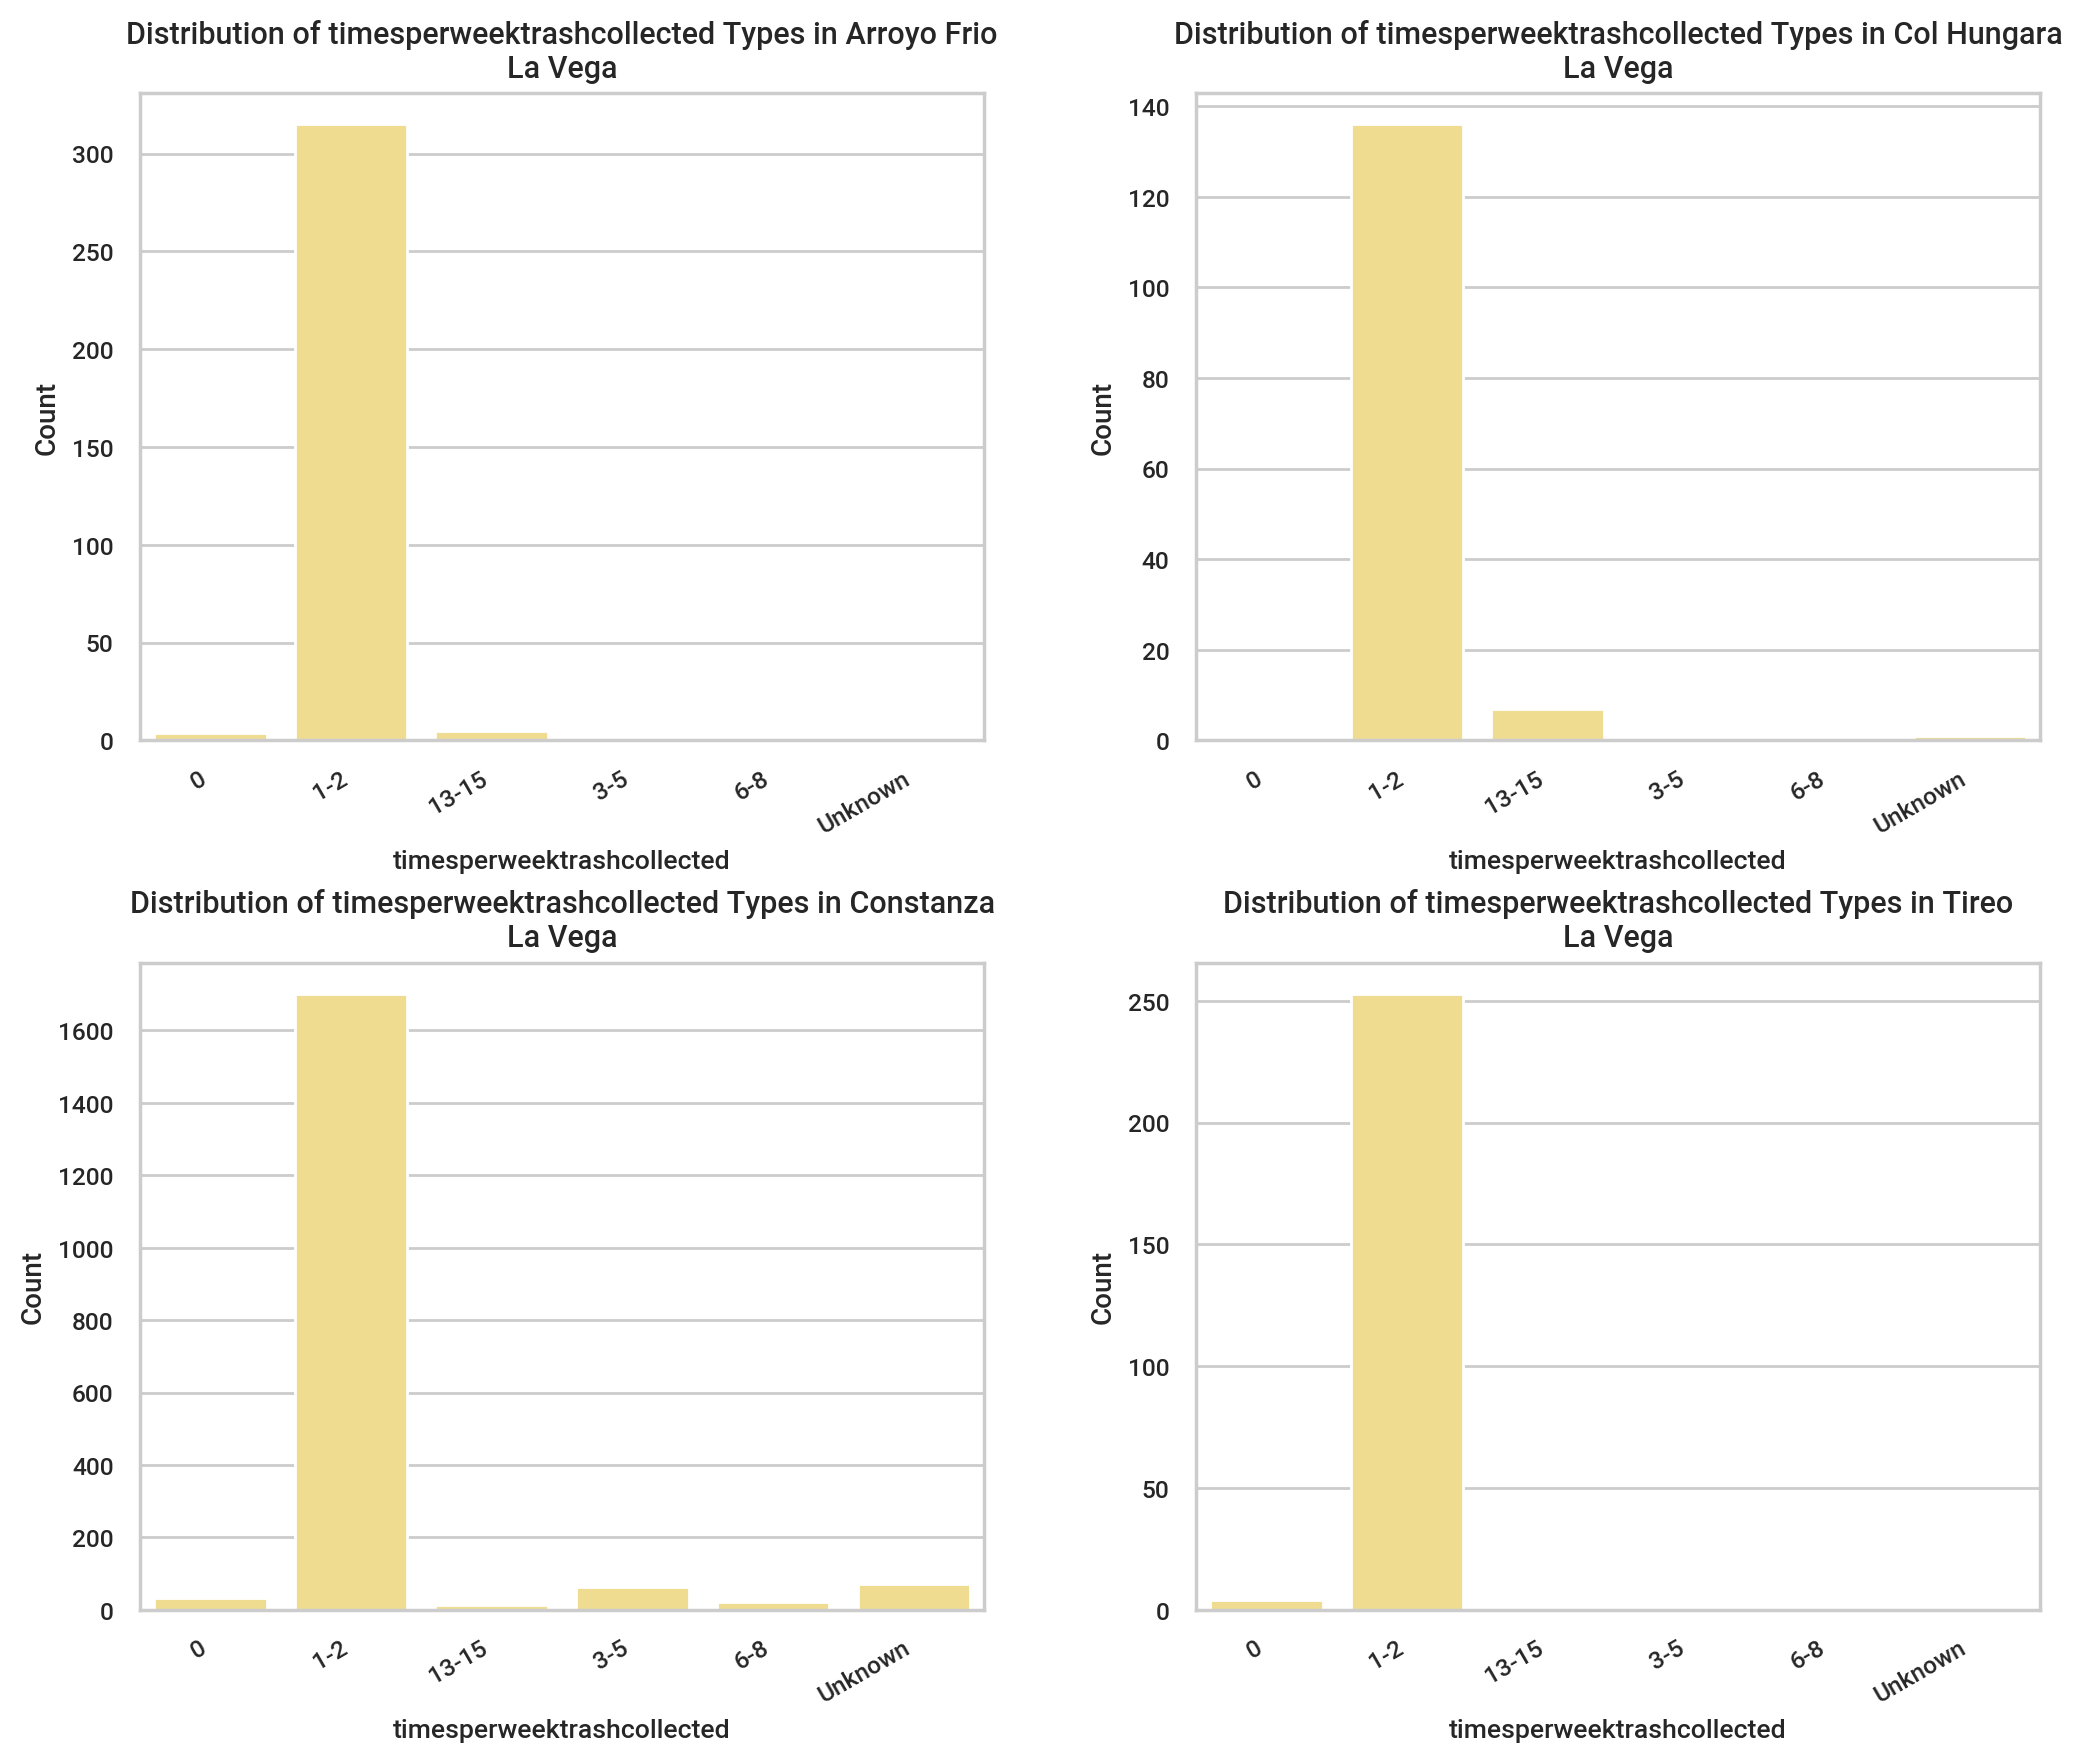

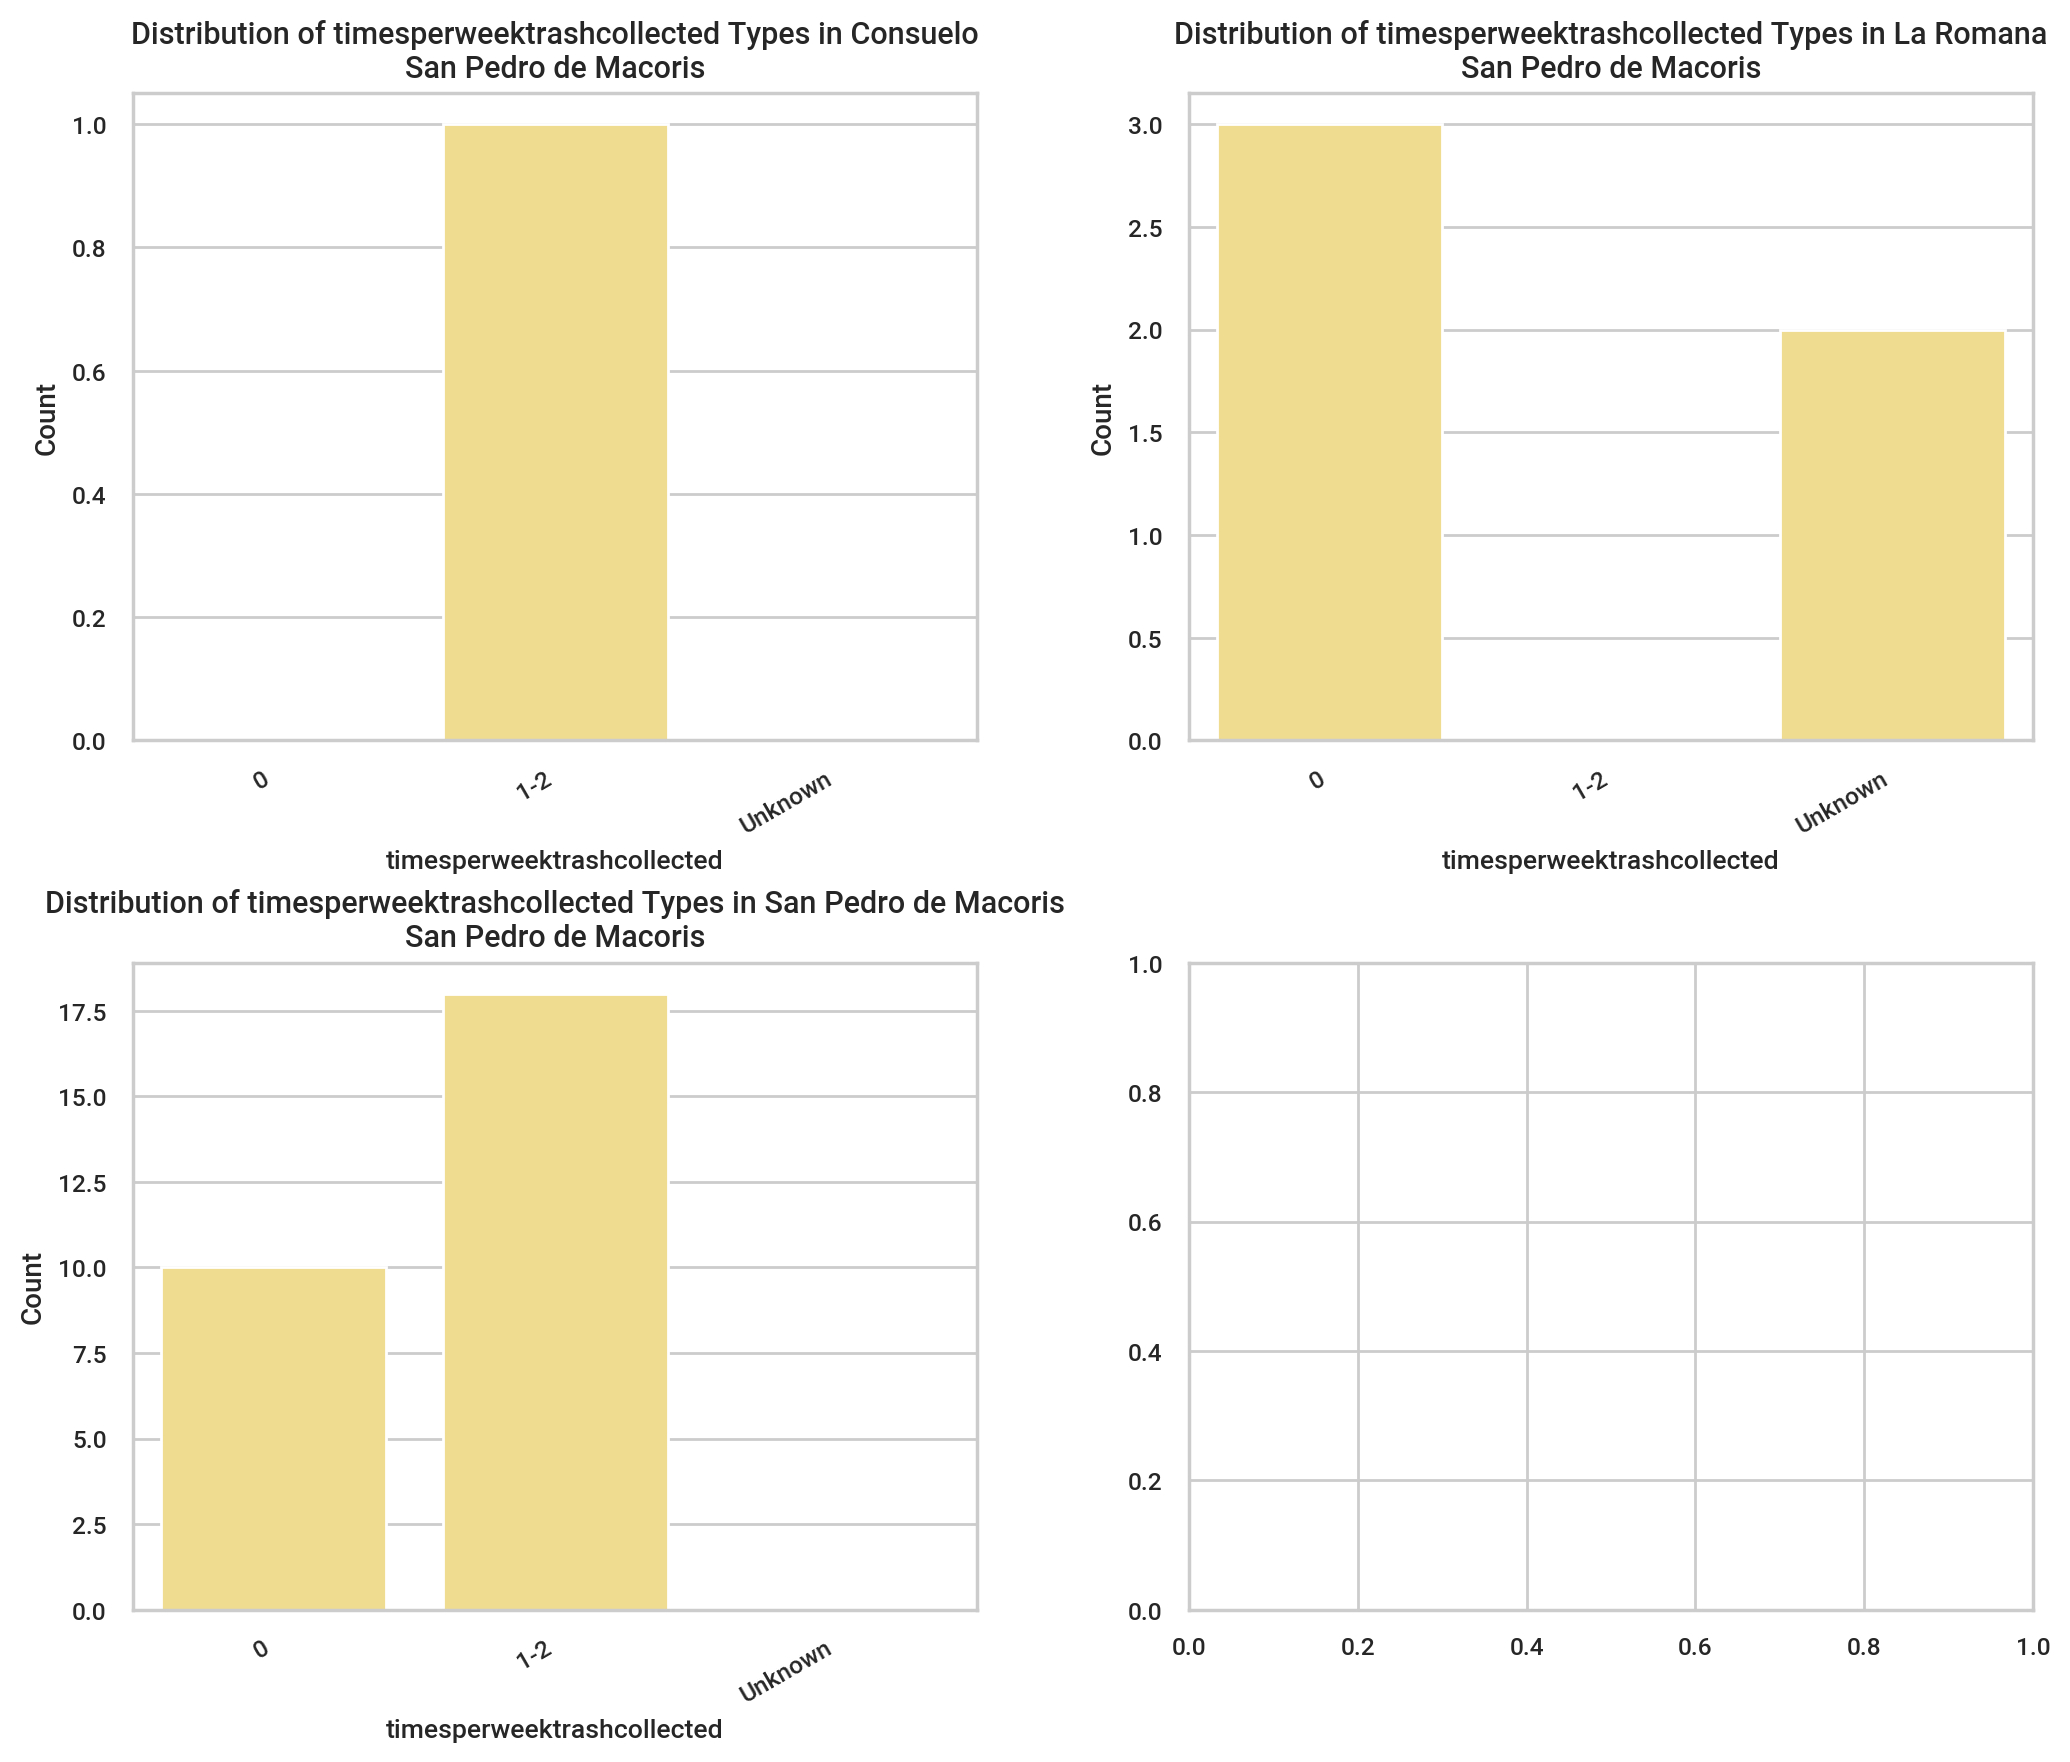

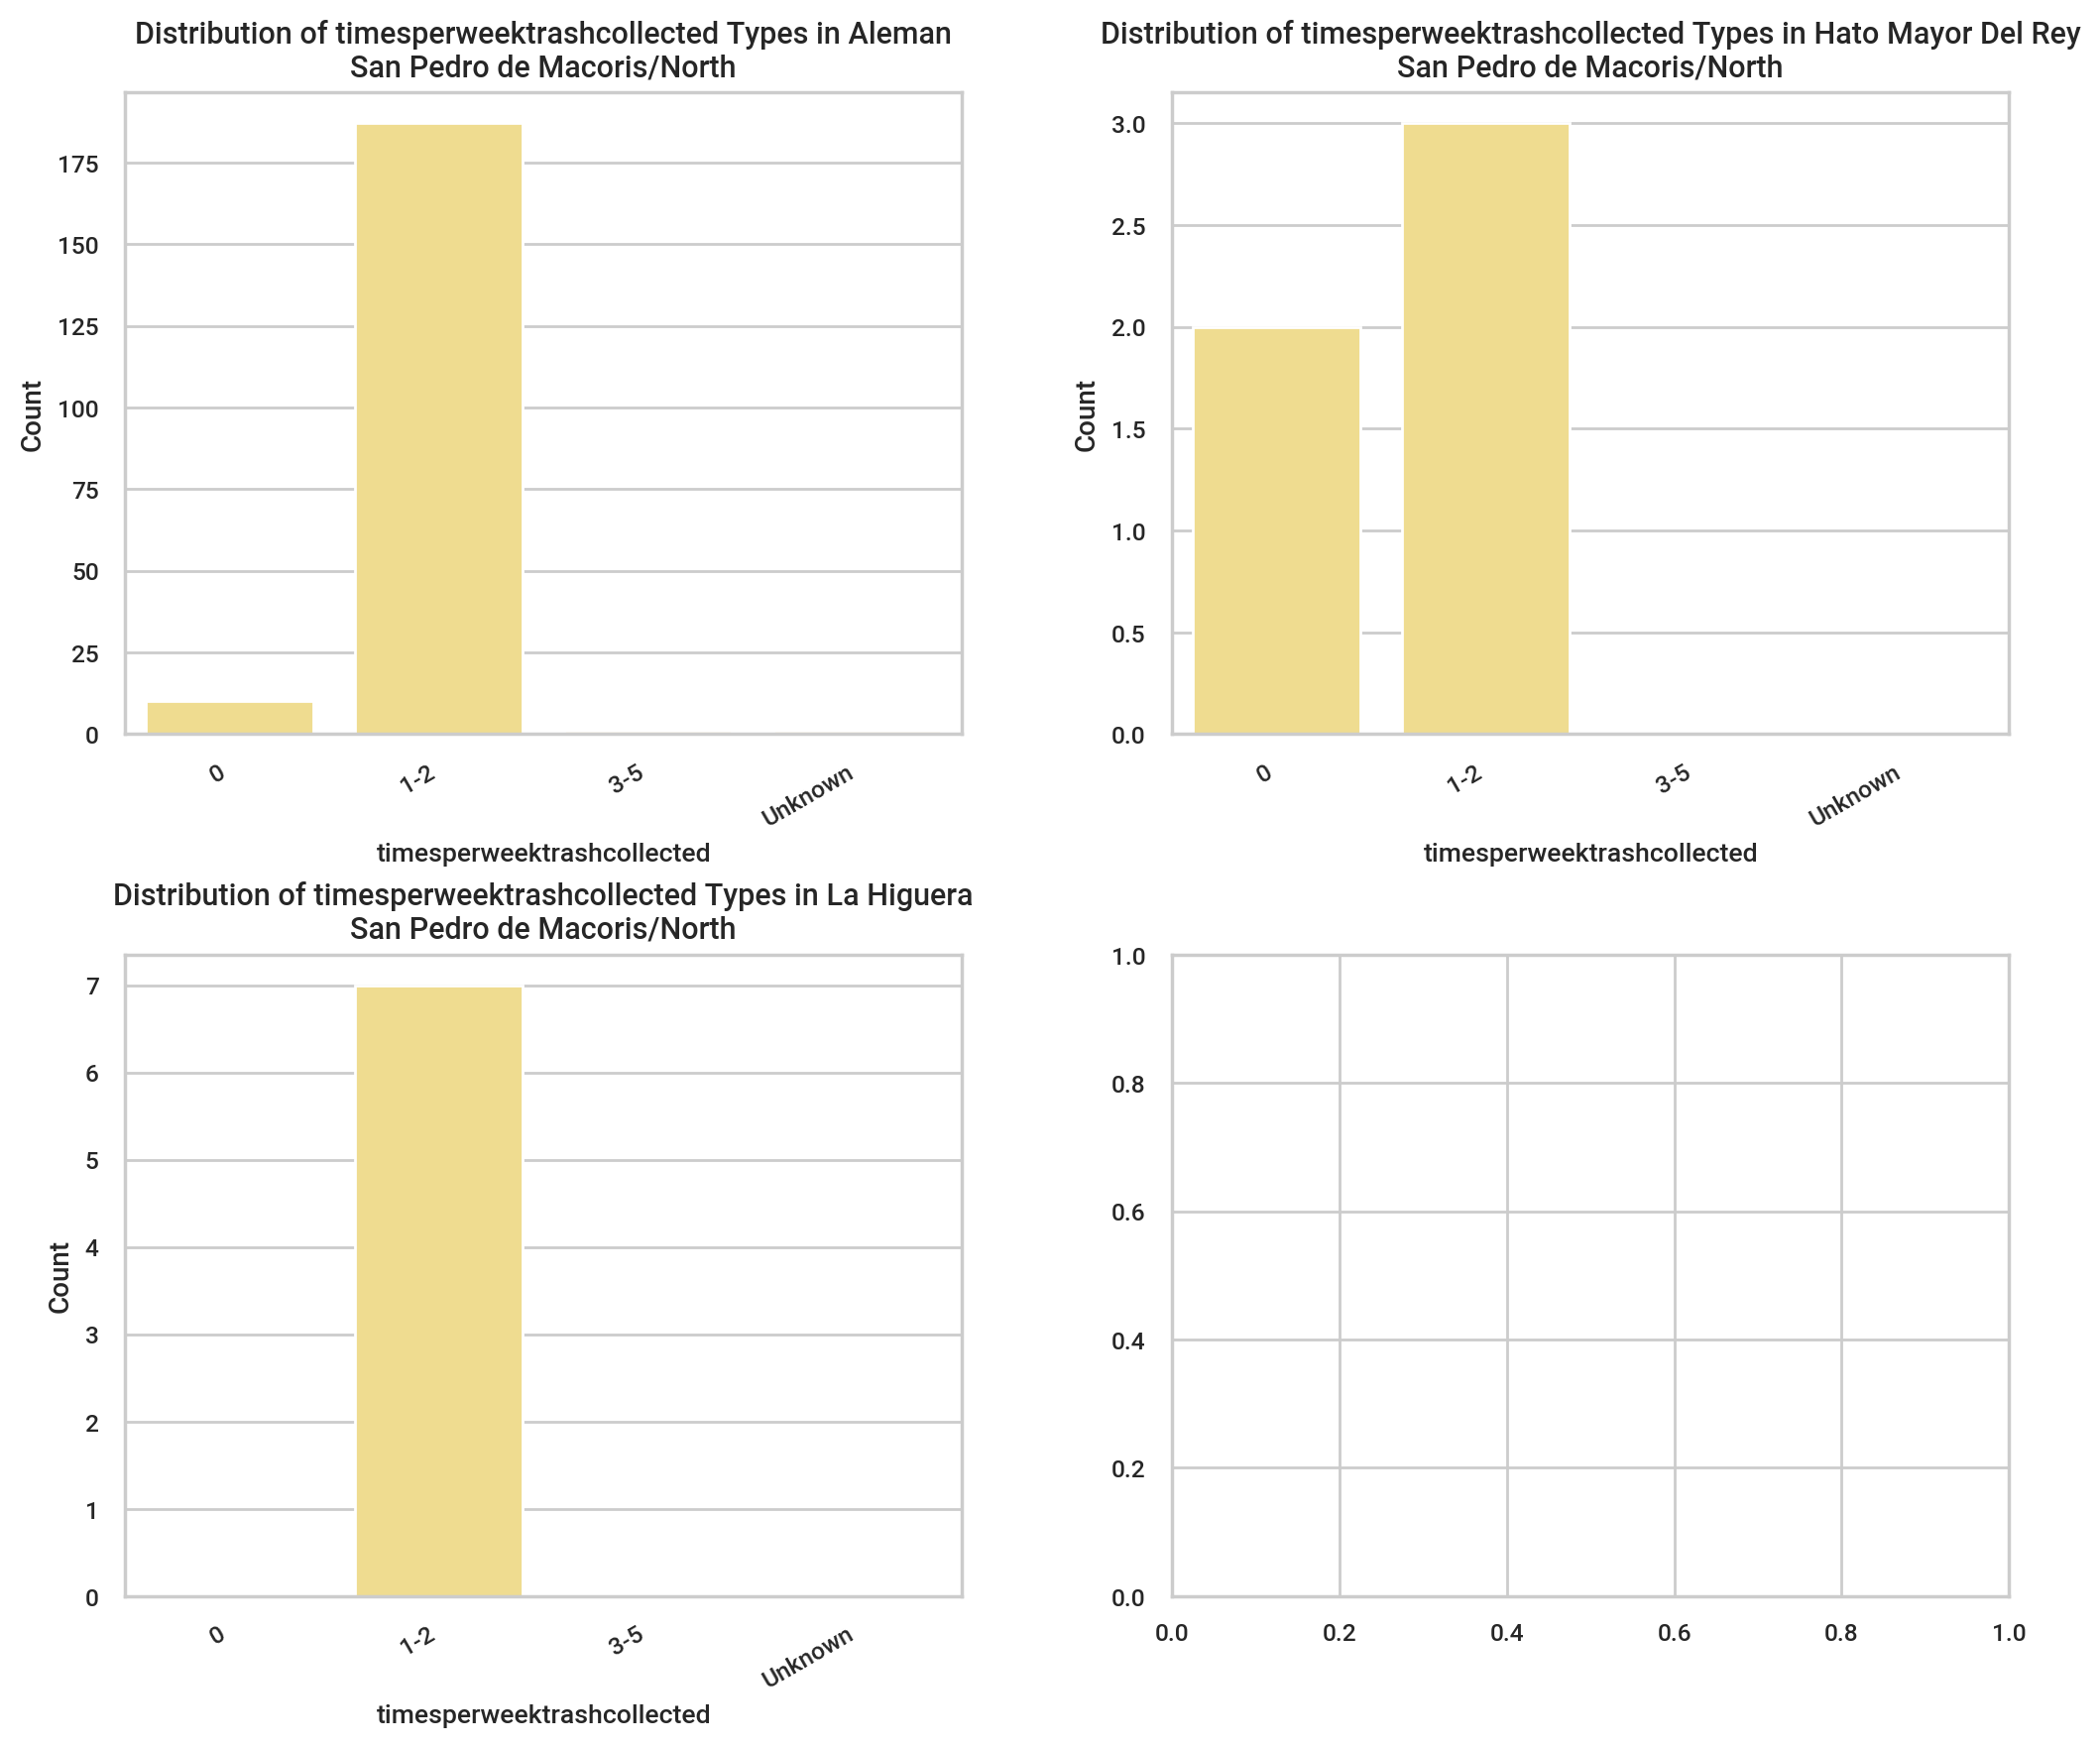

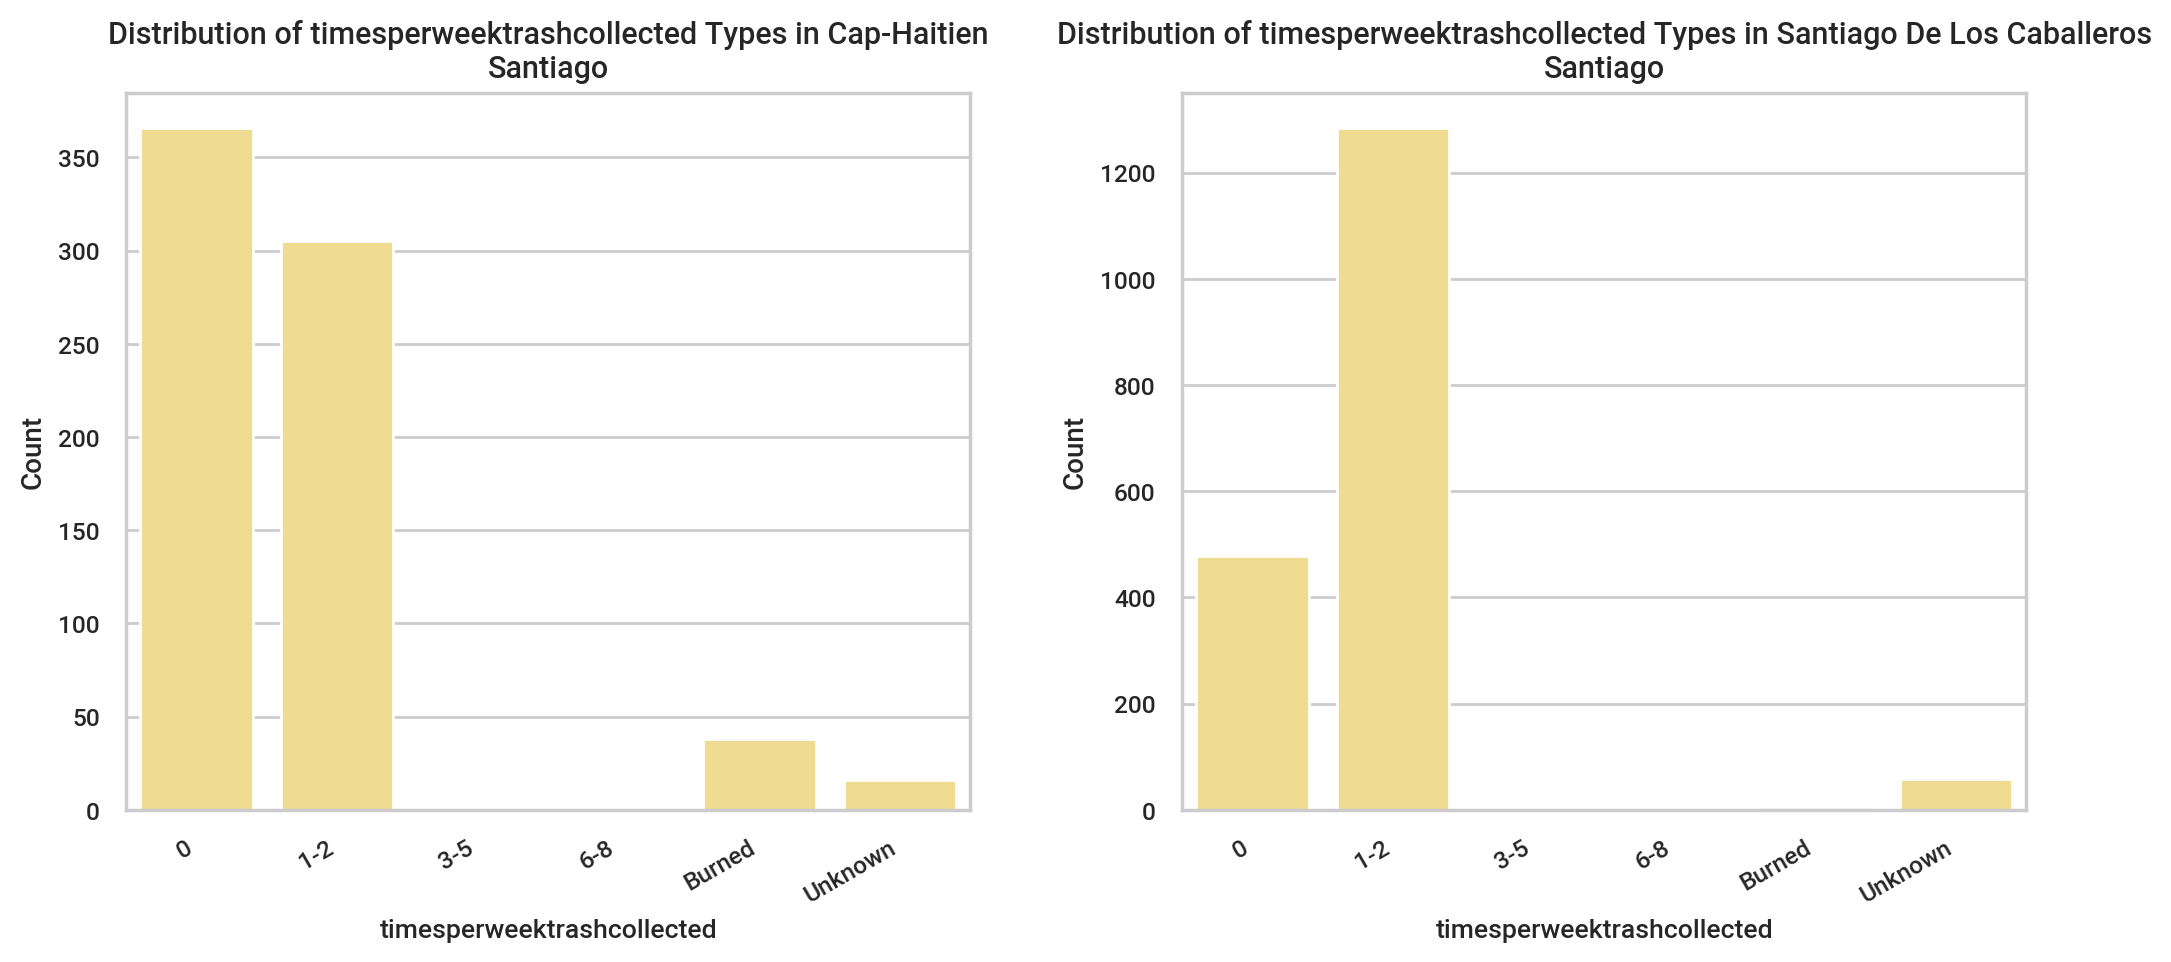

In [60]:
# ex. timesperweektrashcollected distribution by communities in each province
env_by_community('timesperweektrashcollected')

### 4.4 Merging Eval_med and Survey_vitals Datasets

We decided to merge Eval_med and Survey_vitals datasets in order to see if people from different communities have different medical conditions which might be caused by communities environment and living conditions. Survey_vitals dataset includes province and community data and Eval_med dataset has respondents' medical data. Unfortunately, many respondents who took the Survey_vitals survey did not complete Eval_med survey which means that we have medical data from limited number of provinces and communities.

In [61]:
survey_med = survey_clustered.merge(eval_med, how = "inner", on = "objectId")
survey_med.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  8BAdCPGEE1      concubine        Other  lessThanprimary  18.912805   
1  8BAdCPGEE1      concubine        Other  lessThanprimary  18.912805   
2  bWCqNwtKYL      concubine  Ama de casa  lessThanprimary  18.912537   
3  bWCqNwtKYL      concubine  Ama de casa  lessThanprimary  18.912537   
4  056xDPGU2U      concubine        Other  lessThanprimary  18.912727   

   longitude   age     sex province  community AssessmentandEvaluation  \
0 -70.744914  73.0    male  La Vega  Constanza                     Yes   
1 -70.744914  73.0    male  La Vega  Constanza                     Yes   
2 -70.744927  65.0  female  La Vega  Constanza                      No   
3 -70.744927  65.0  female  La Vega  Constanza                     Yes   
4 -70.745074  79.0    male  La Vega  Constanza                      No   

  planOfAction duration part_of_body trauma_induced condition_progression  
0         none      NaN          NaN            NaN                   NaN  
1        other      NaN          NaN            NaN                   NaN  
2         none      NaN          NaN            NaN                   NaN  
3        other      NaN          NaN            NaN                   NaN  
4         none      NaN          NaN            NaN                   NaN


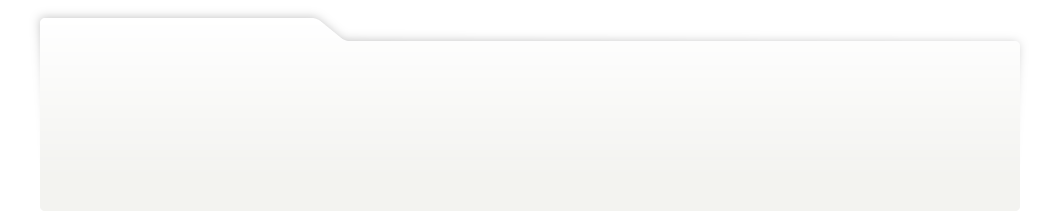
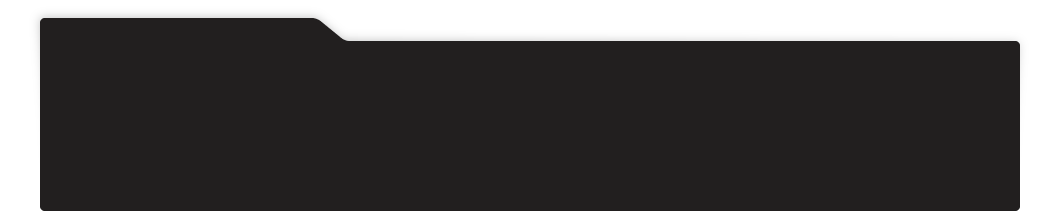
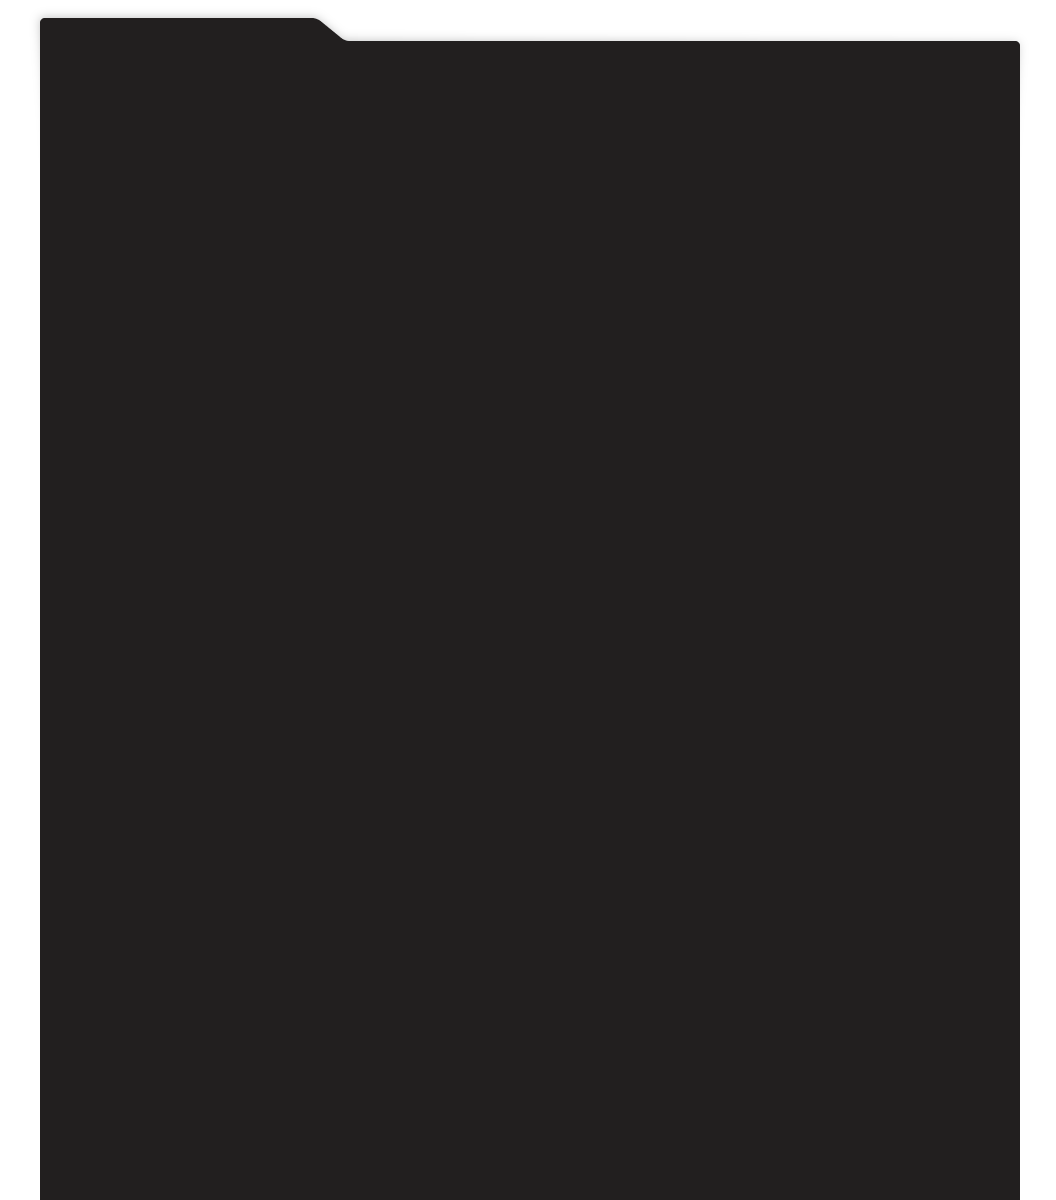
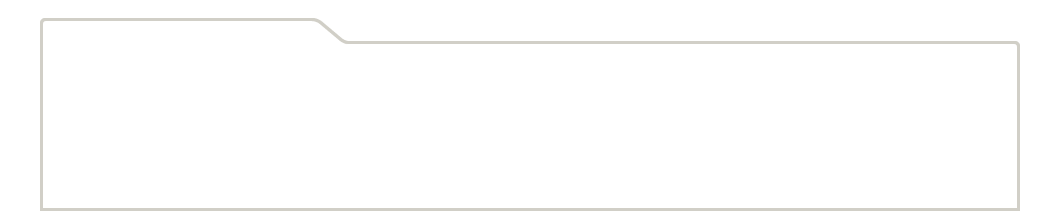
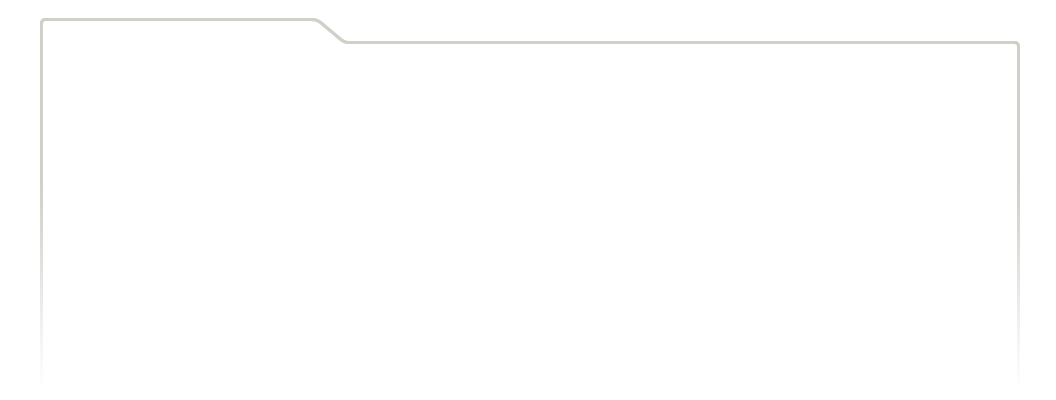
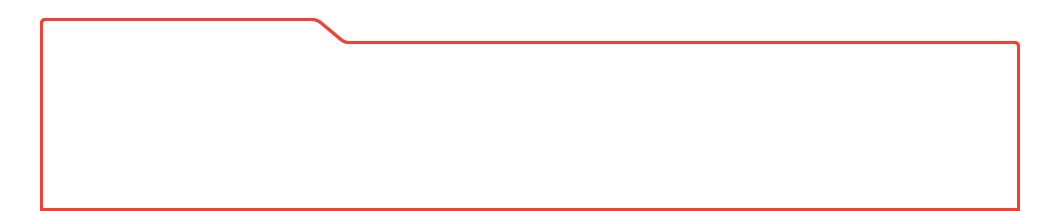
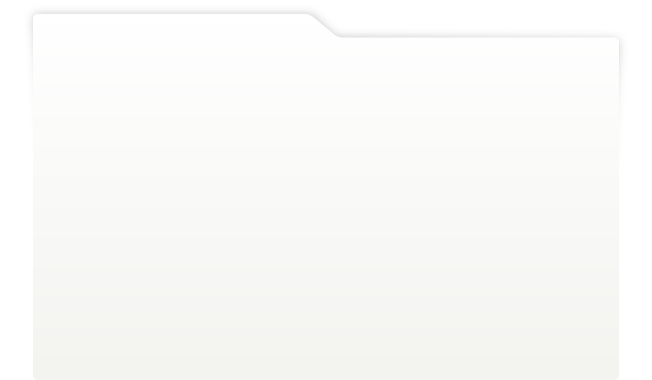
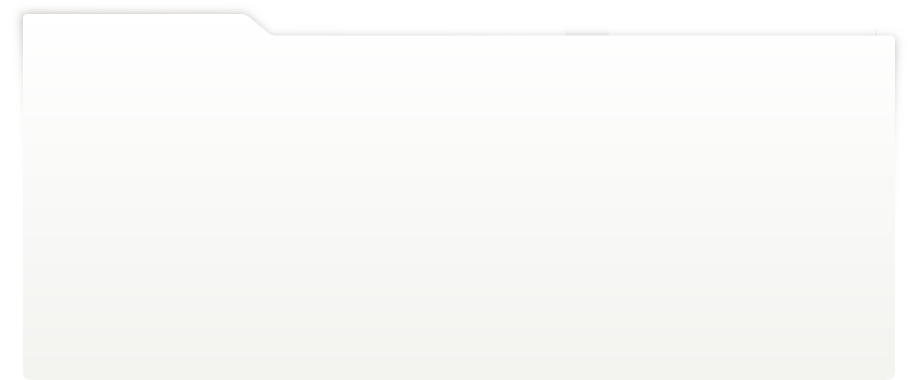
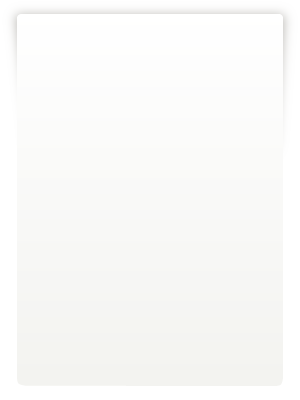
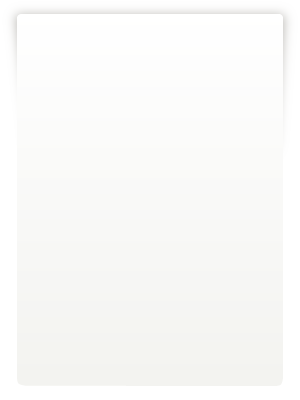
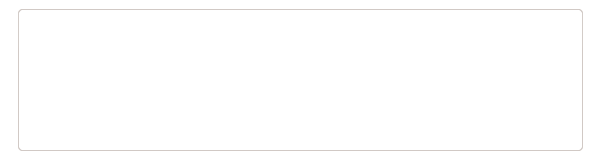
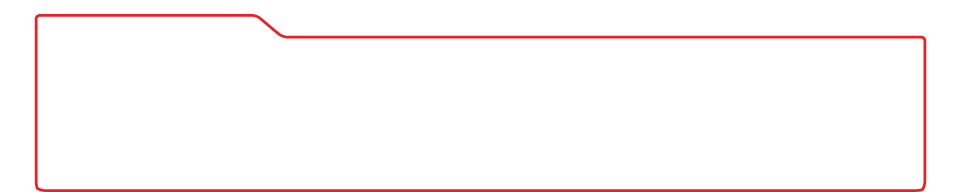
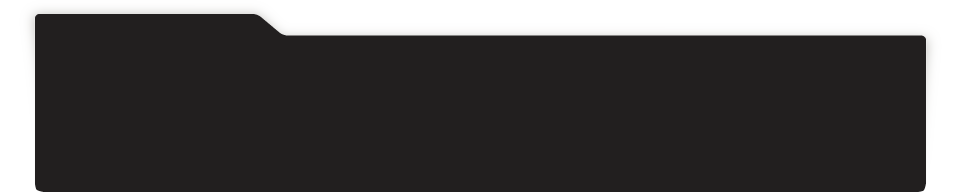
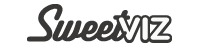
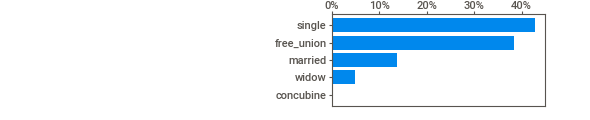
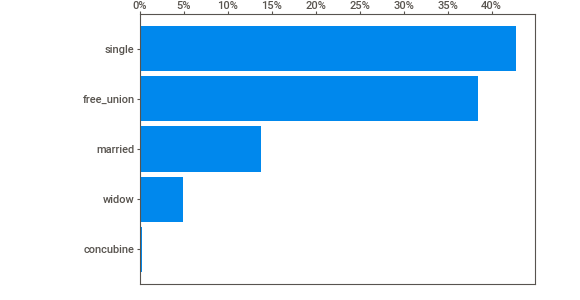
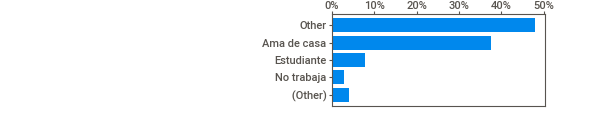
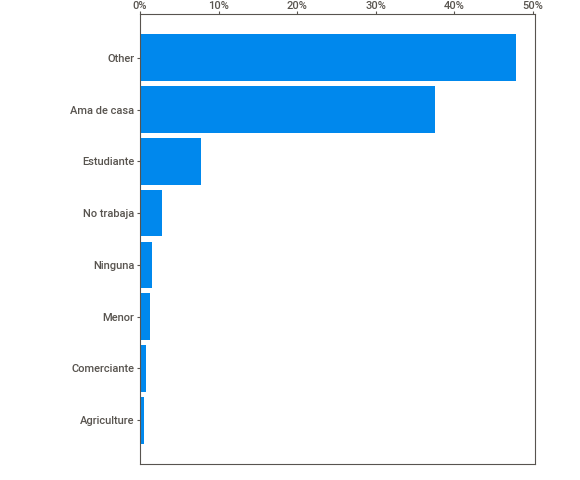
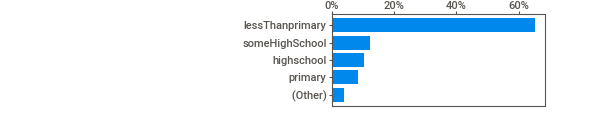
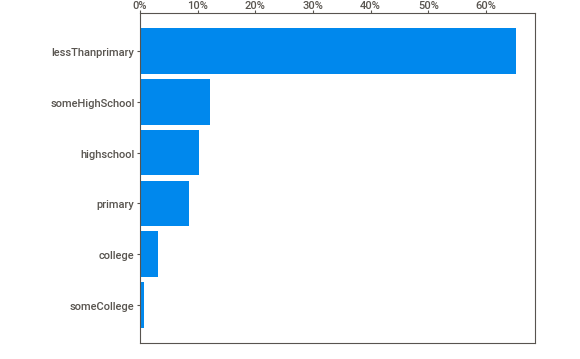
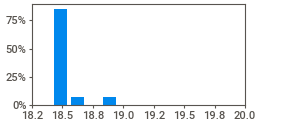
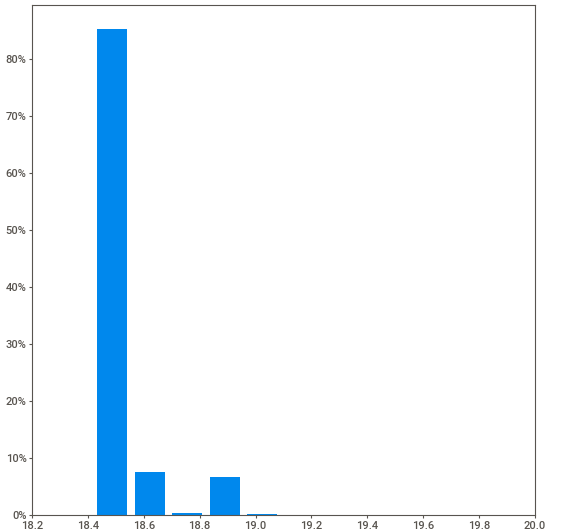
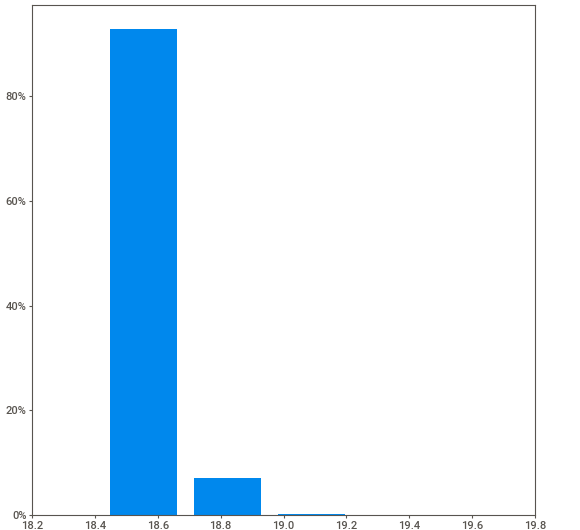
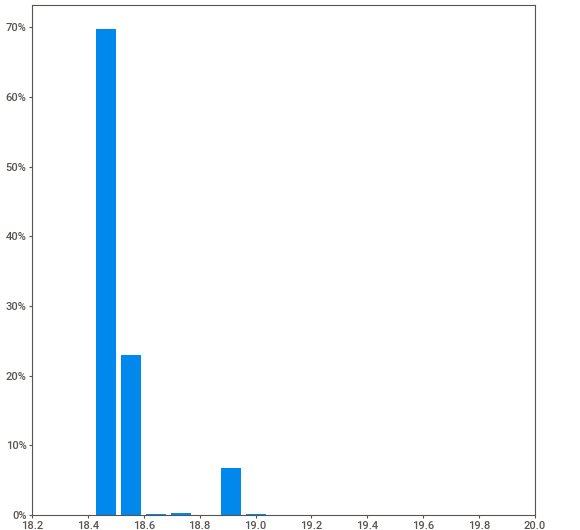
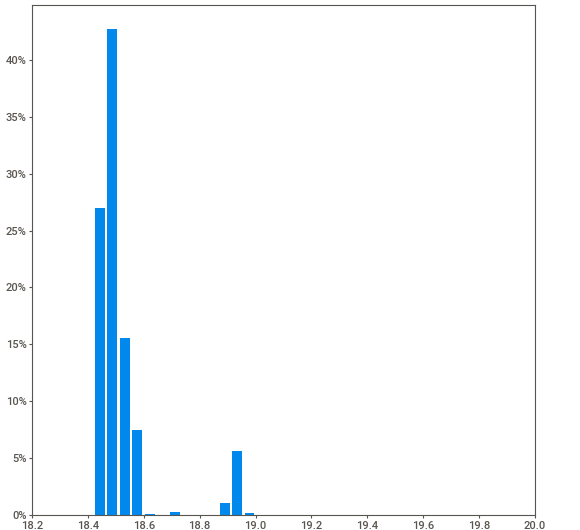
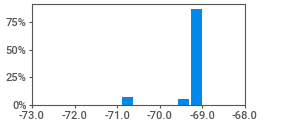
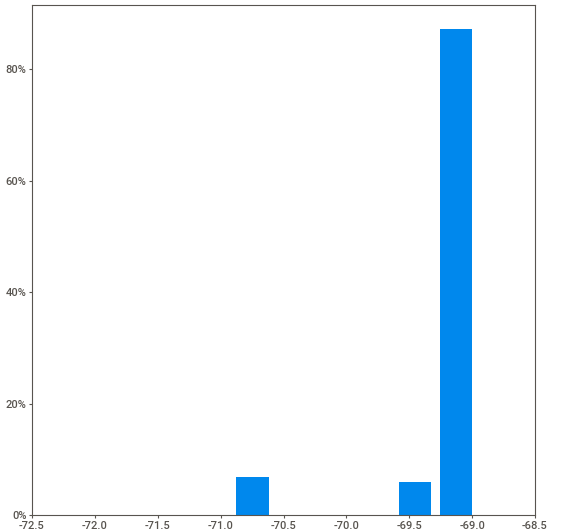
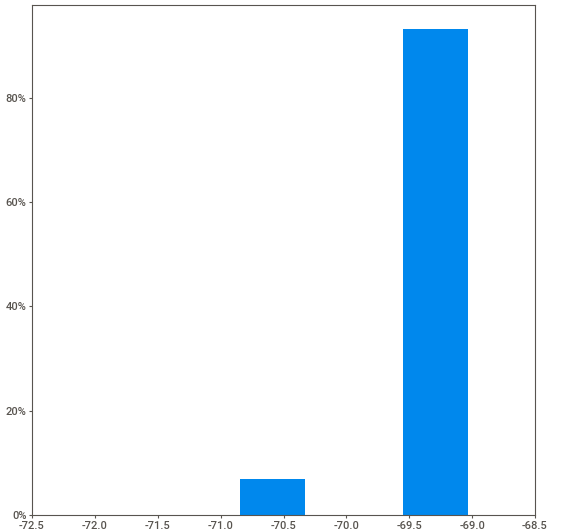
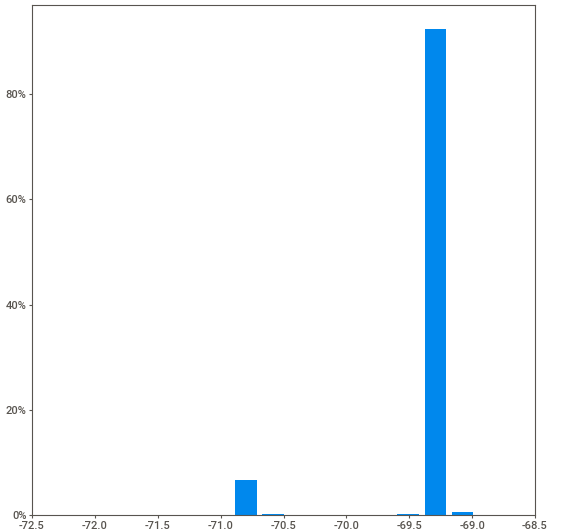
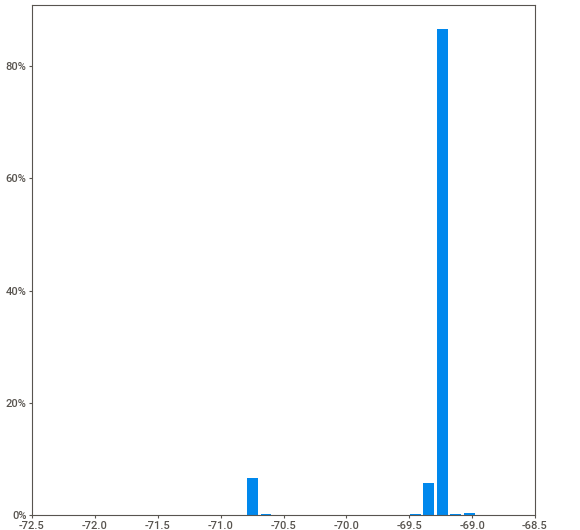
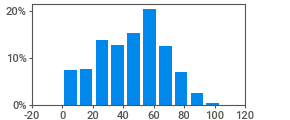
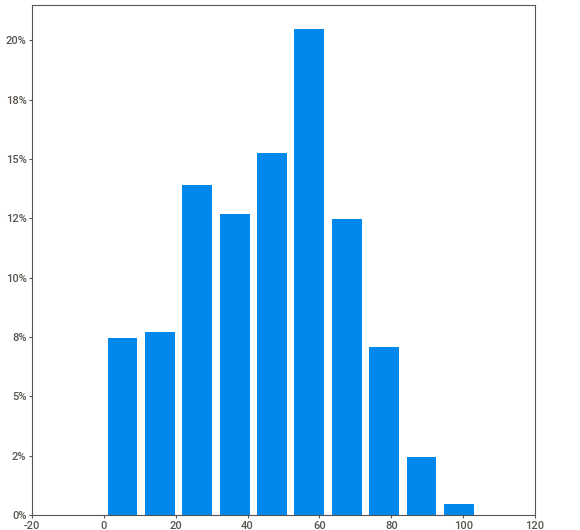
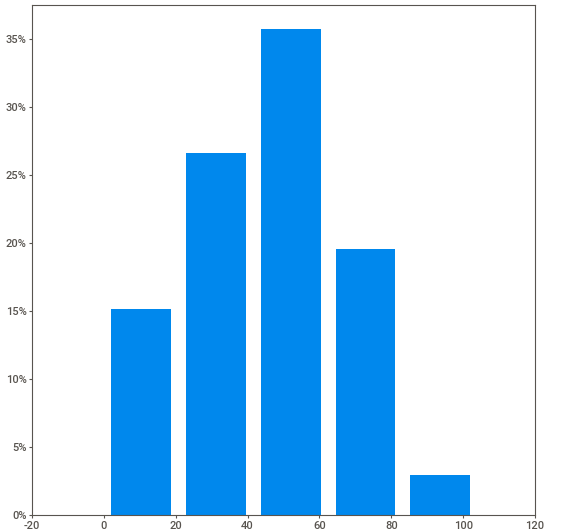
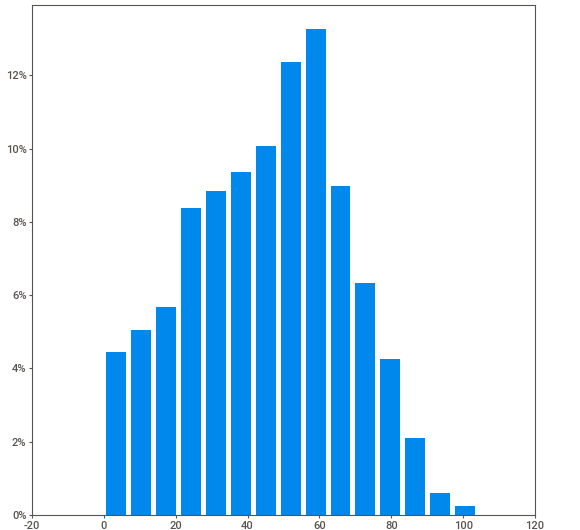
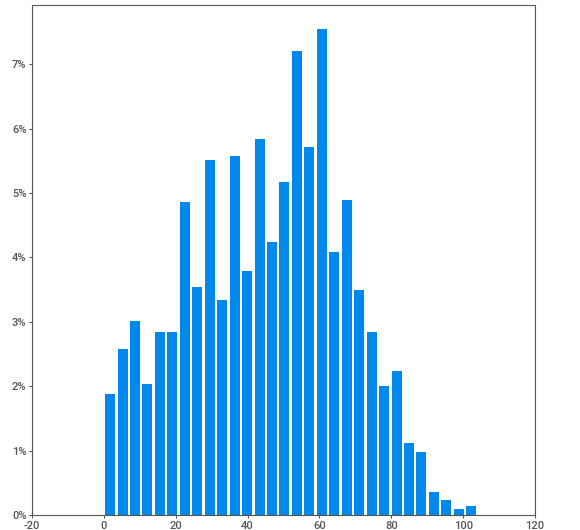
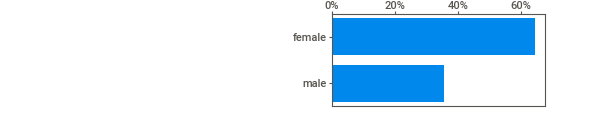
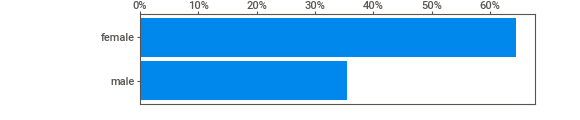
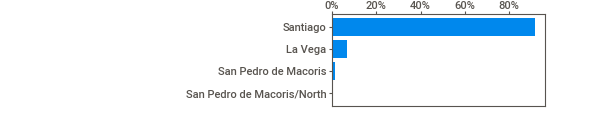
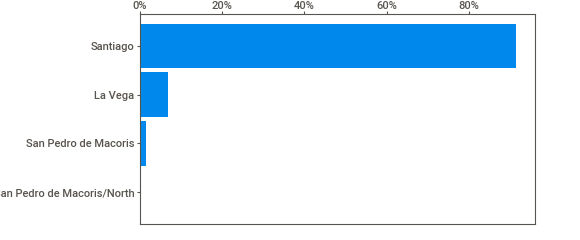
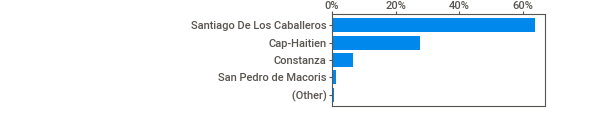
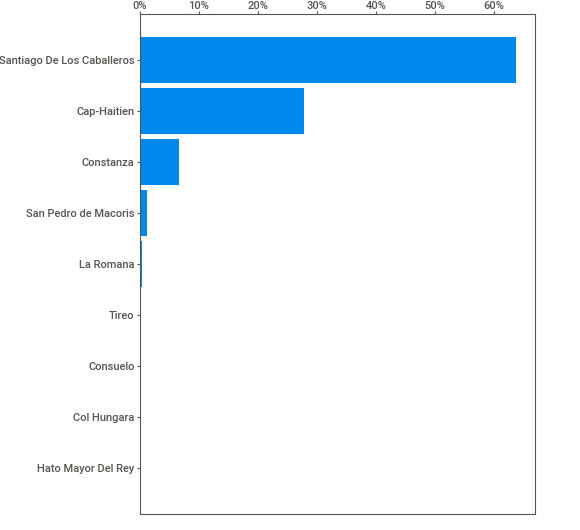
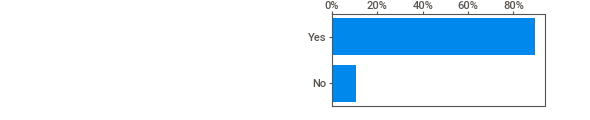
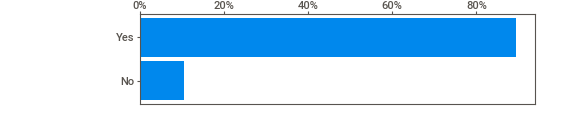
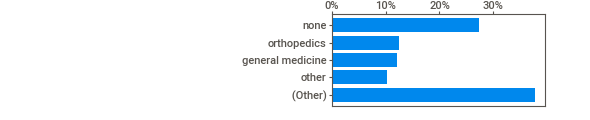
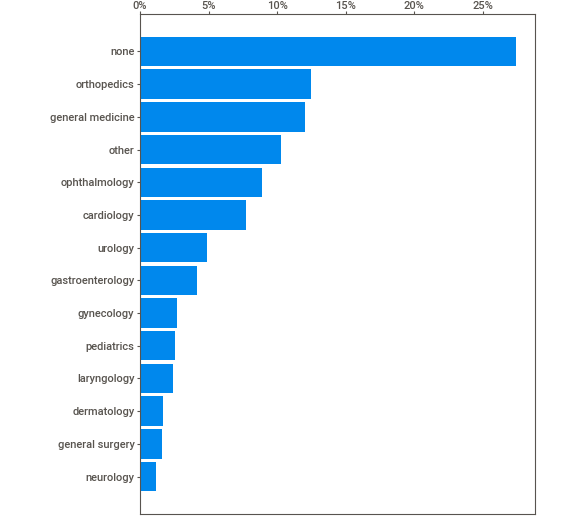
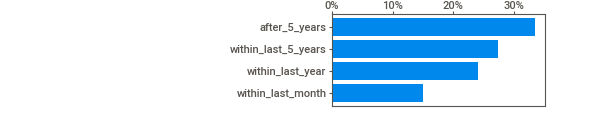
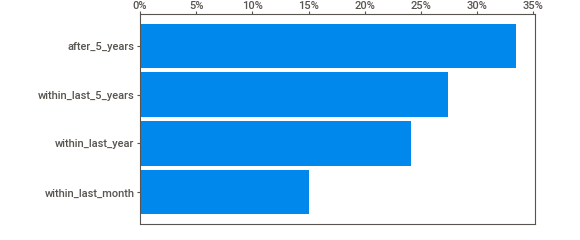
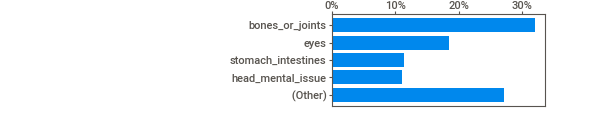
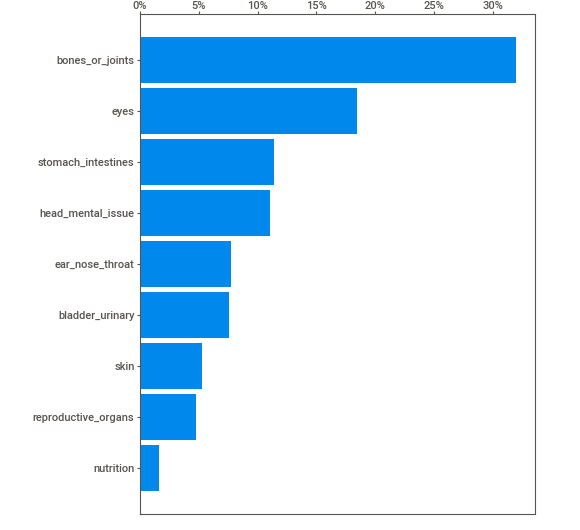
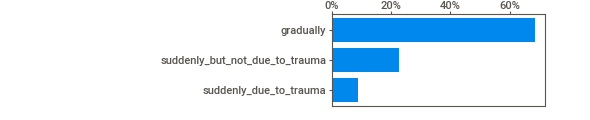
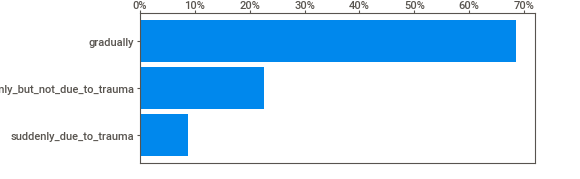
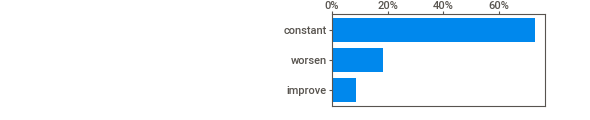
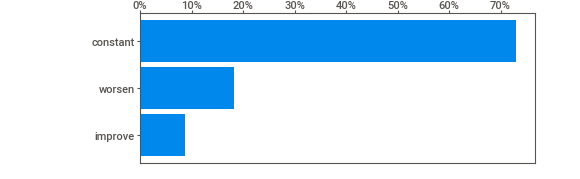
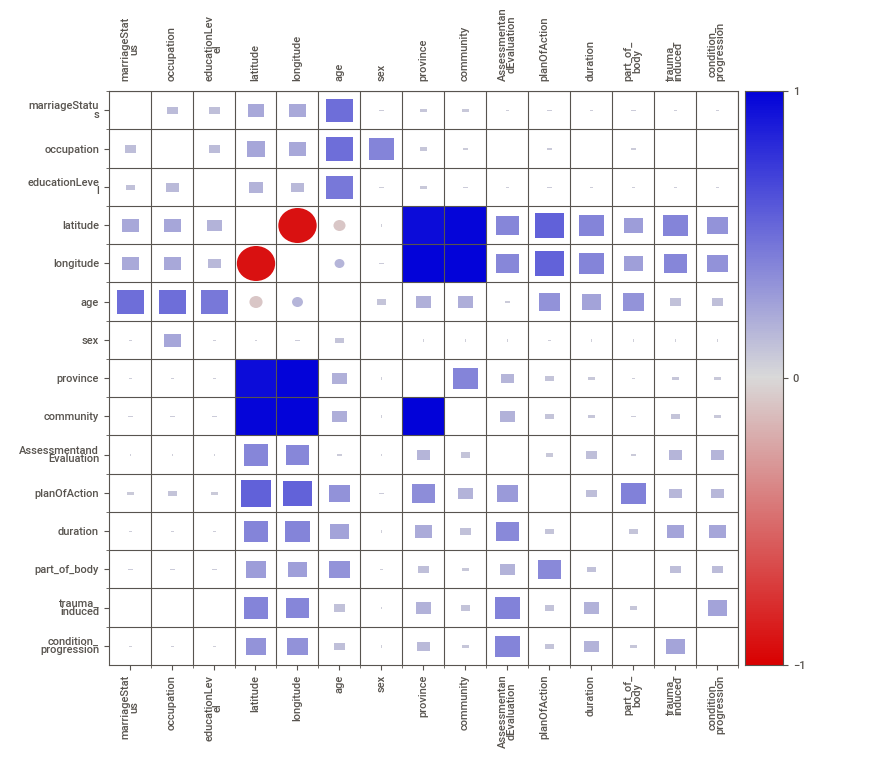
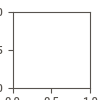

In [64]:
sv_report_survey_med = sv.analyze([survey_med, "Survey_med"])
sv_report_survey_med.show_notebook()

In [62]:
# number of respondents in each province
survey_med.province.value_counts()

Santiago                      7480
La Vega                        563
San Pedro de Macoris           125
San Pedro de Macoris/North       1
Name: province, dtype: int64

### 4.5 Community Level Medical Data Analysis

In [63]:
# creating separate dataframes for differenct provinces
# I chose on only two provinces because the other the provinces did not have enough data as seen above
Lavega = survey_med[survey_med["province"] == "La Vega"].groupby("part_of_body").count().objectId.reset_index()
san_pedro = survey_med[survey_med["province"] == "San Pedro de Macoris"].groupby("part_of_body").count().objectId.reset_index()

Text(402.0568181818181, 0.5, 'Count')

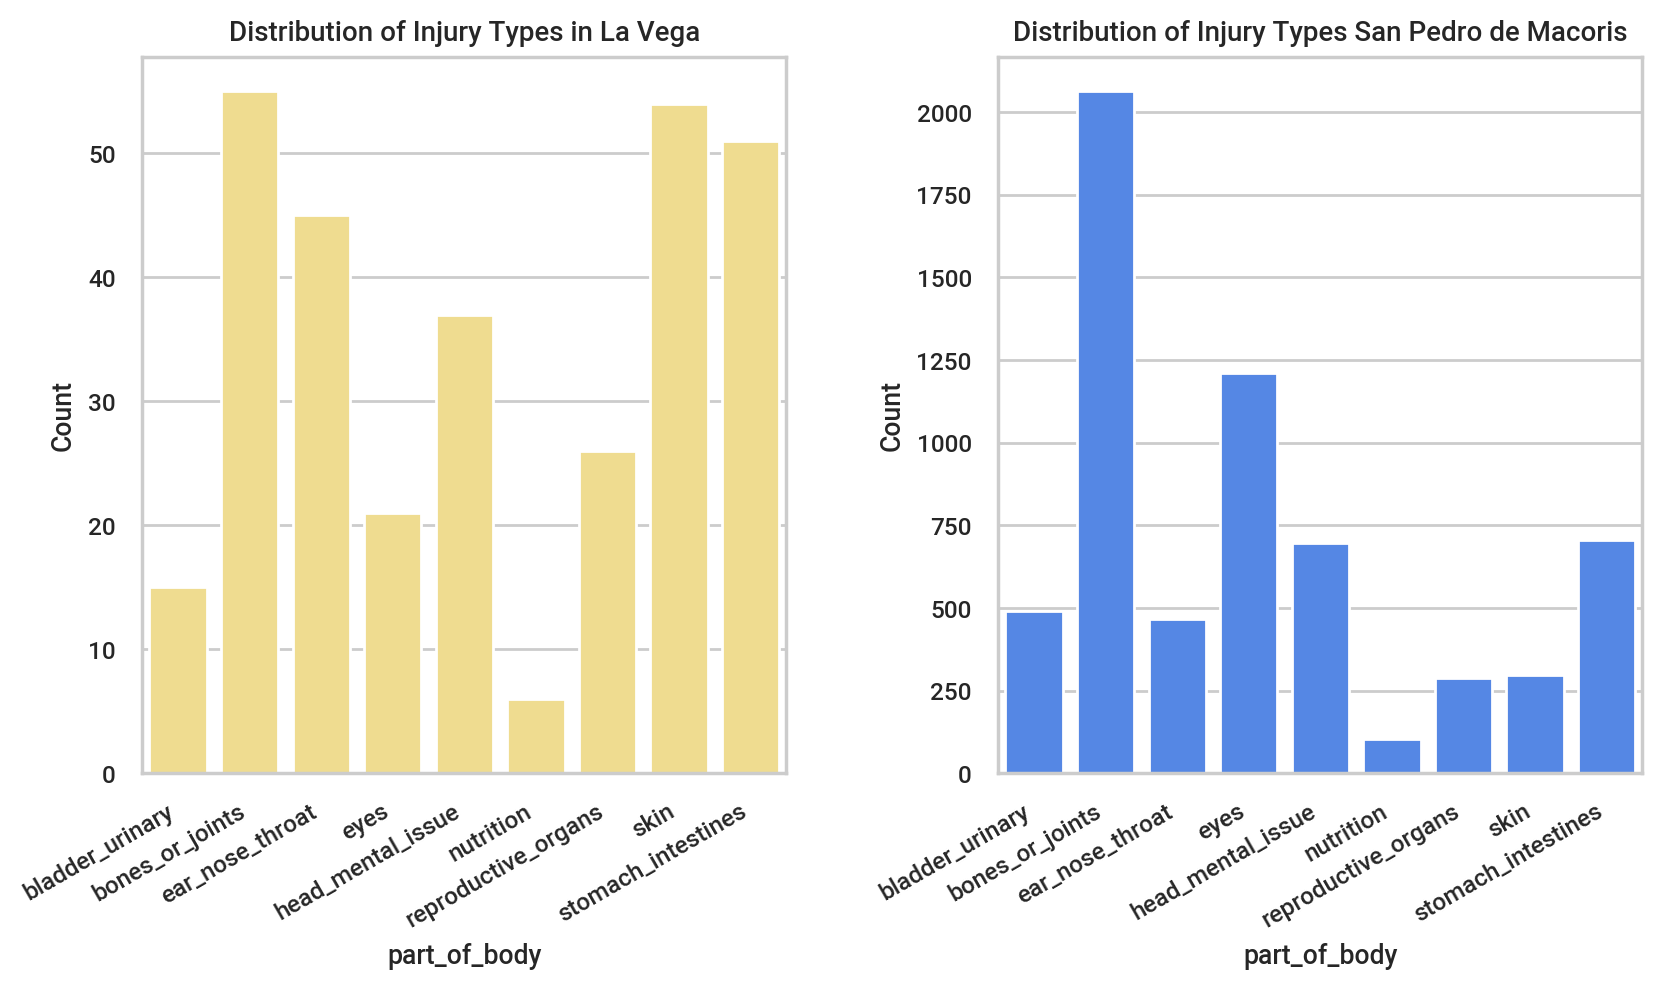

In [57]:
# graphing the distribution of injury types in La Vega and San Pedro de Macoris provinces
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
plt.tight_layout(pad=0.4, w_pad=5.0, h_pad=5.0)
ax1 = sns.barplot(x = "part_of_body", y = "objectId", data = Lavega, ax = ax1, color="#FFE680")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
ax1.set_title("Distribution of Injury Types in La Vega", fontsize = 10)
ax1.set_ylabel("Count")
    
ax2 = sns.barplot(x = "part_of_body", y = "objectId", data = san_pedro, ax = ax2, color="#3D80FC")
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
ax2.set_title("Distribution of Injury Types San Pedro de Macoris", fontsize = 10)
ax2.set_ylabel("Count")

In [59]:
# creating separate dataframes for differenct provinces
sp_med = survey_med[survey_med["province"] == "San Pedro de Macoris"]
Lavega_med = survey_med[survey_med["province"] == "La Vega"]
spn_med = survey_med[survey_med["province"] == "San Pedro de Macoris/North"]
santiago_med = survey_med[survey_med["province"] == "Santiago"]

In [60]:
# creating a function that shows the distribution of injury types in different communities
def injury_dist(df):
    sns.set(font="Roboto")
    sns.set_style("whitegrid", {'font.family':'Roboto'})
    order = list(df.part_of_body.value_counts().index)
    for community in list(df.community.unique()):
        if list(df.community.unique()).index(community) % 2 == 0:
            ax = sns.countplot(x = "part_of_body", data = df[df["community"] == community], order = order, color="#3D80FC")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
            ax.set_title("Distribution of Injuries in " + community)
            plt.show()
            ax.set_ylabel("Count")
        else: 
            ax = sns.countplot(x = "part_of_body", data = df[df["community"] == community], order = order, color="#FFE680")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
            ax.set_title("Distribution of Injuries in " + community)
            plt.show()
            ax.set_ylabel("Count")

### 4.5.1 Distribution of Injuries in San Pedro de Macoris Communities

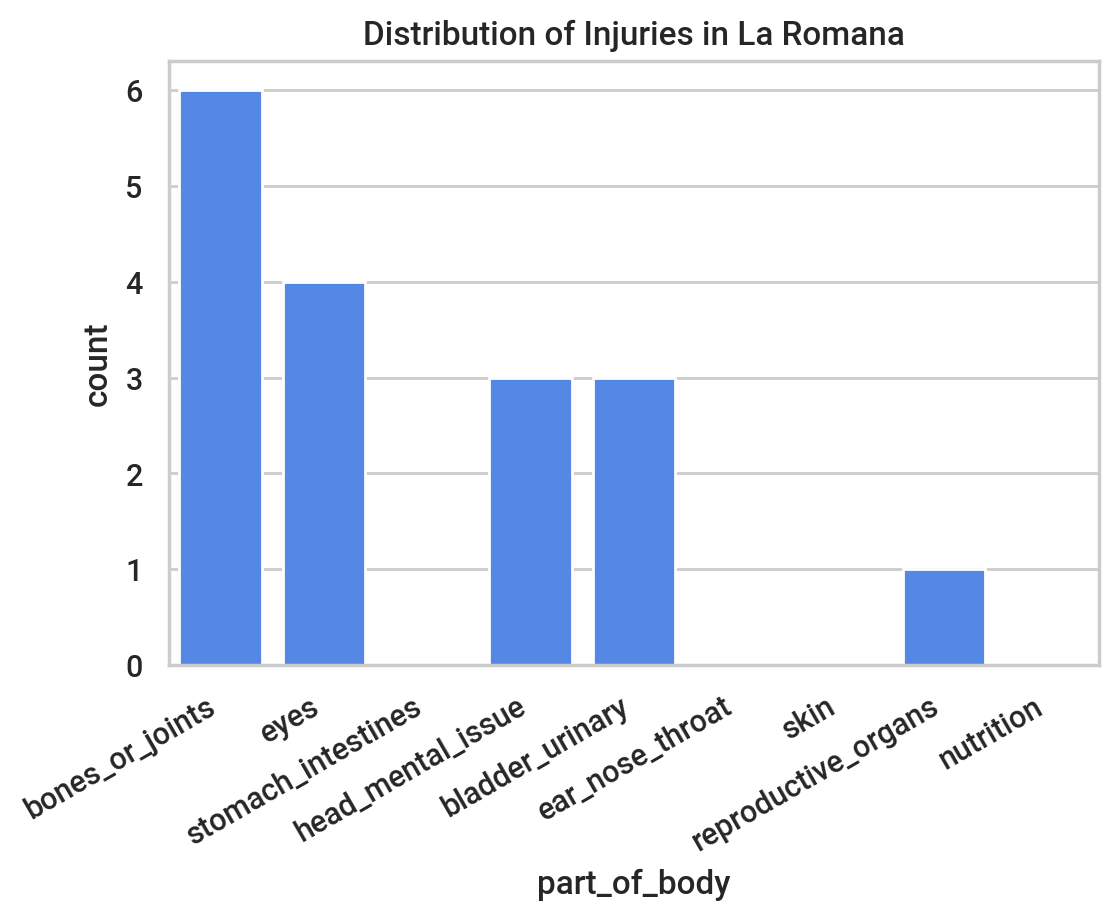

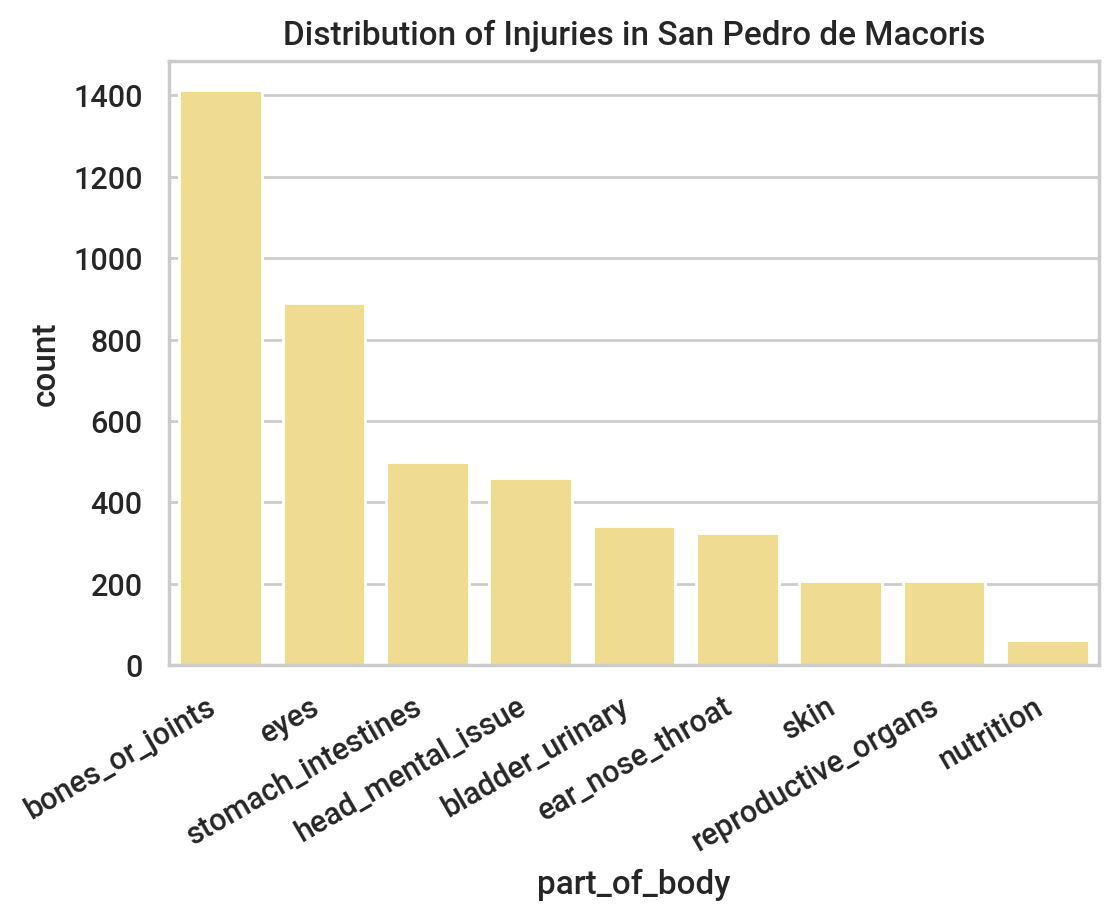

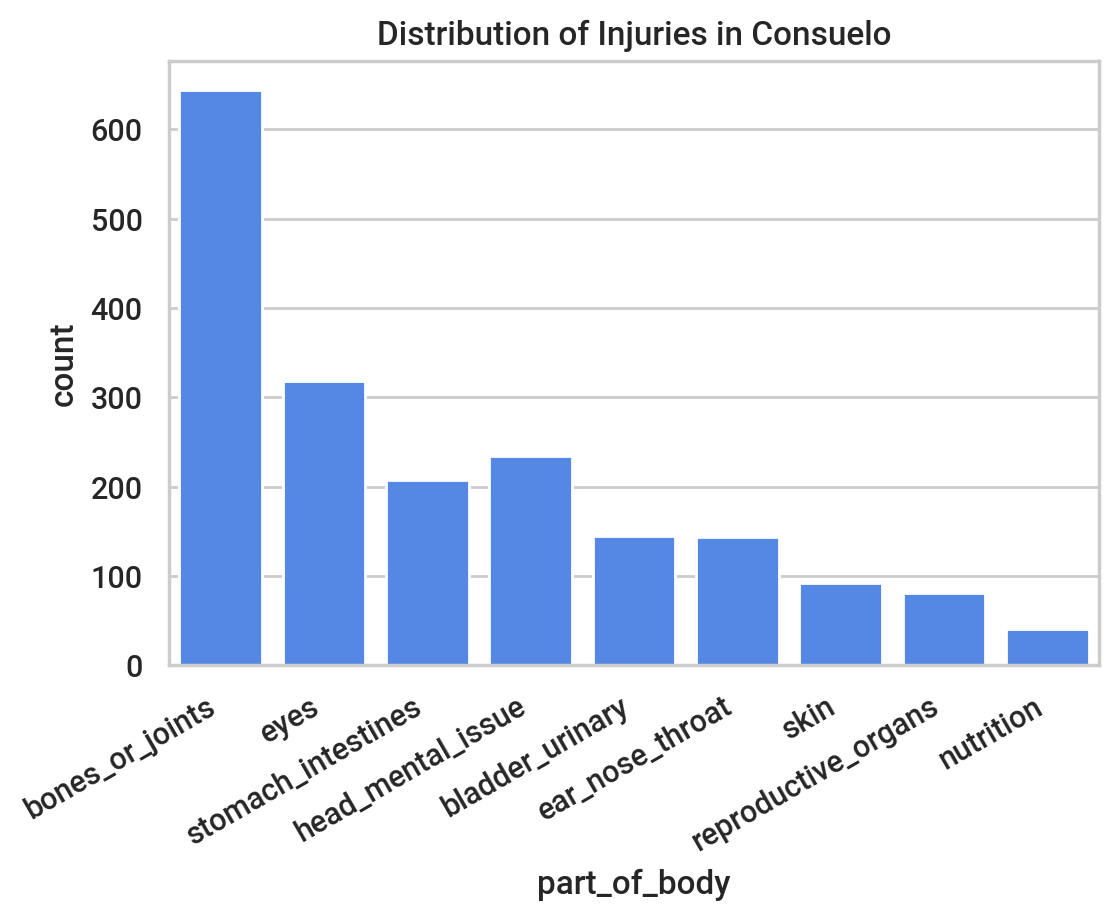

In [61]:
injury_dist(sp_med)

### 4.5.2 Distribution of Injuries in La Vega Communities

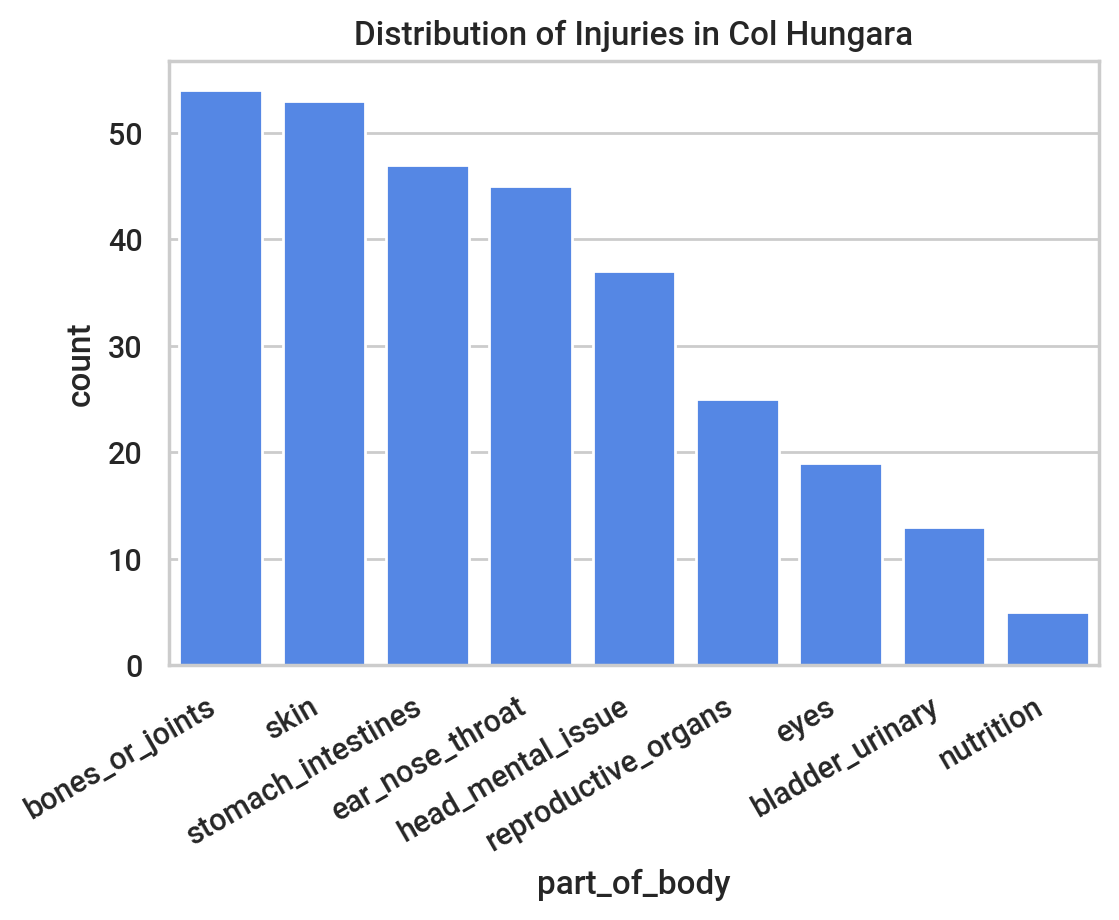

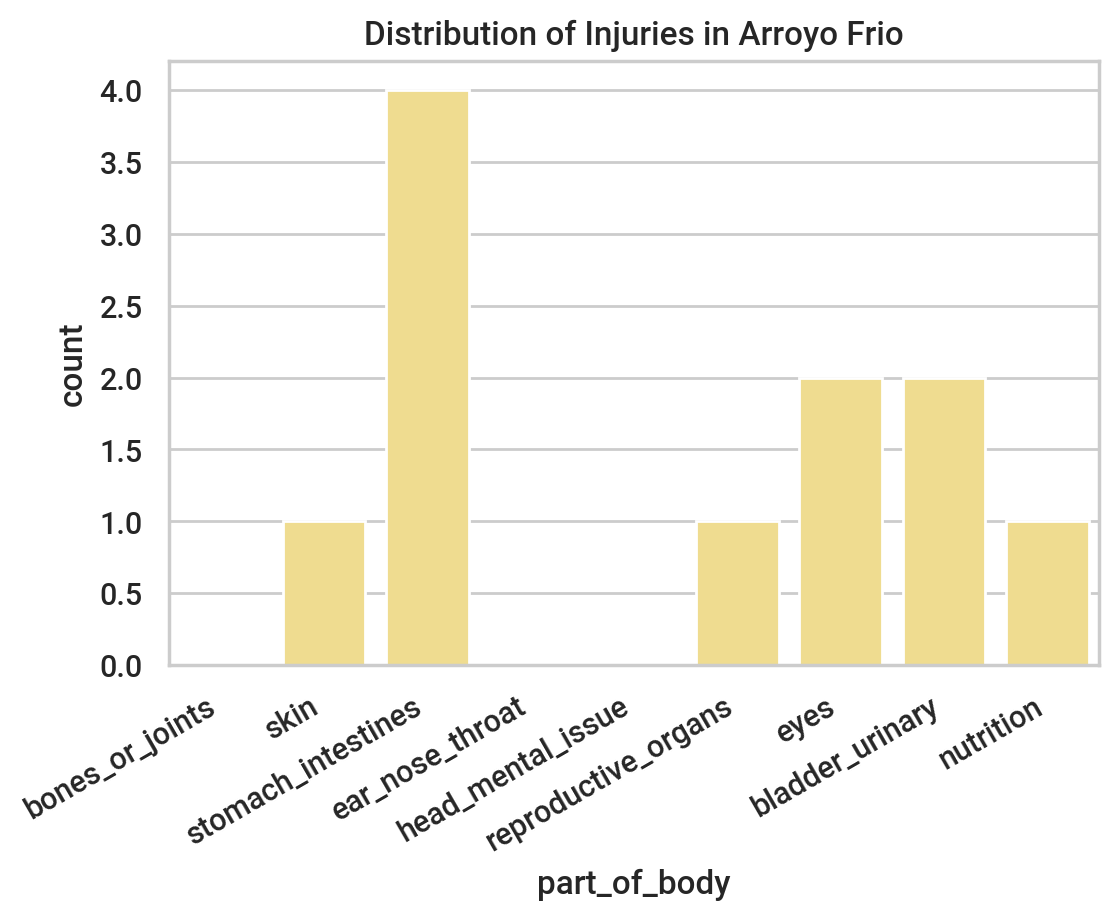

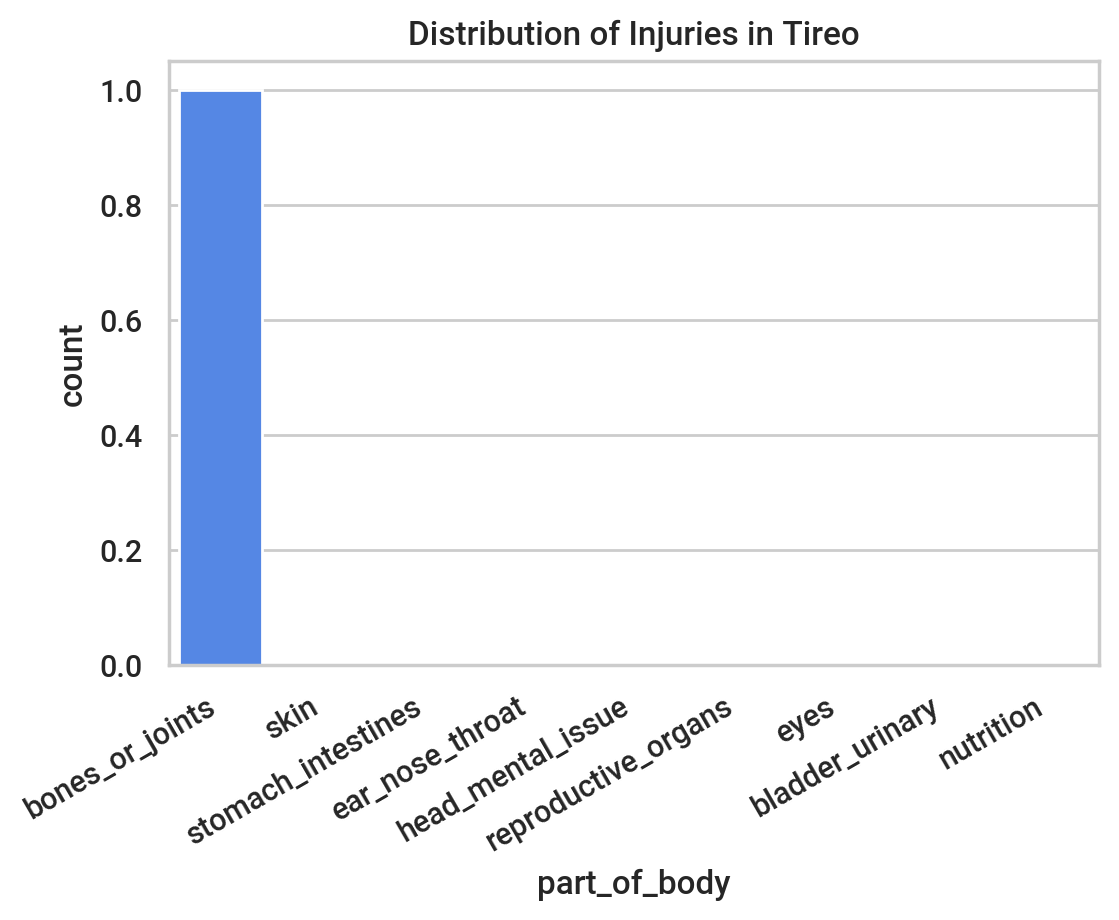

In [62]:
injury_dist(Lavega_med)

### 4.5.3 Distribution of Injuries in San Pedro de Macoris North Communities

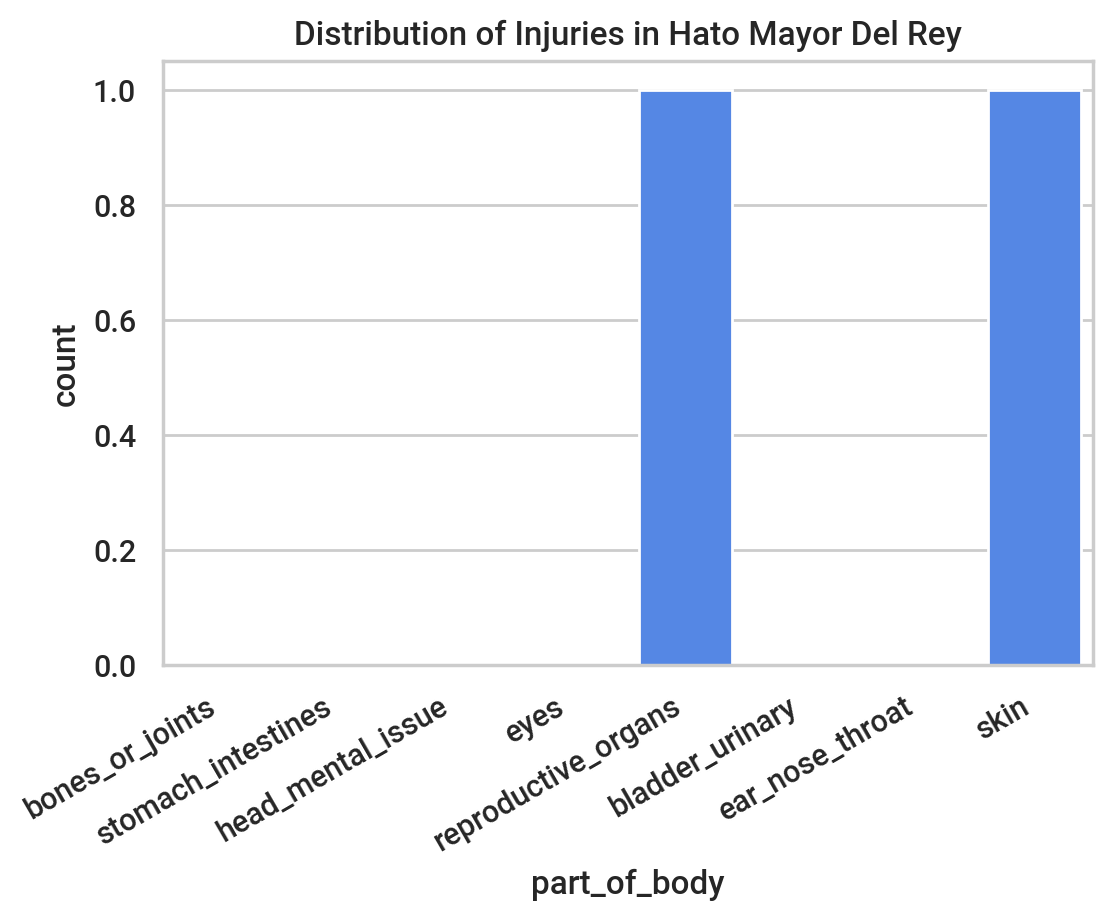

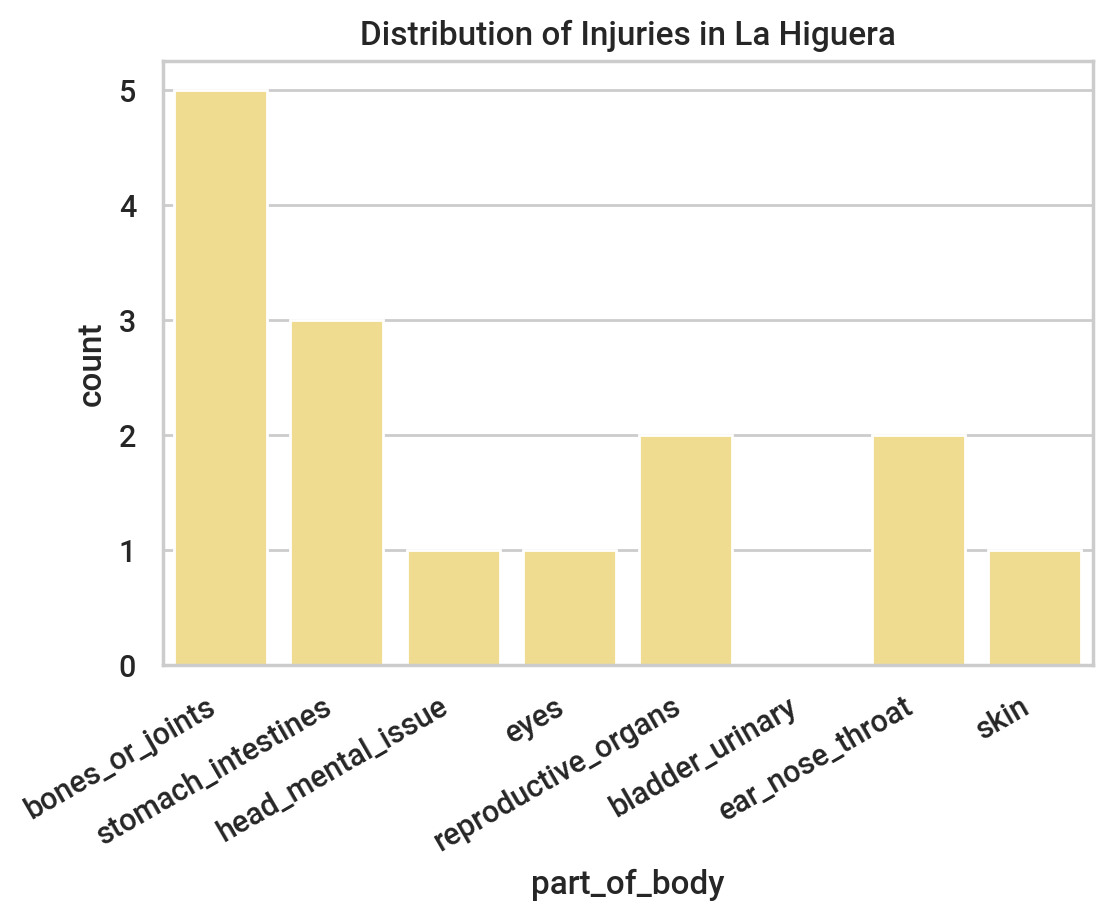

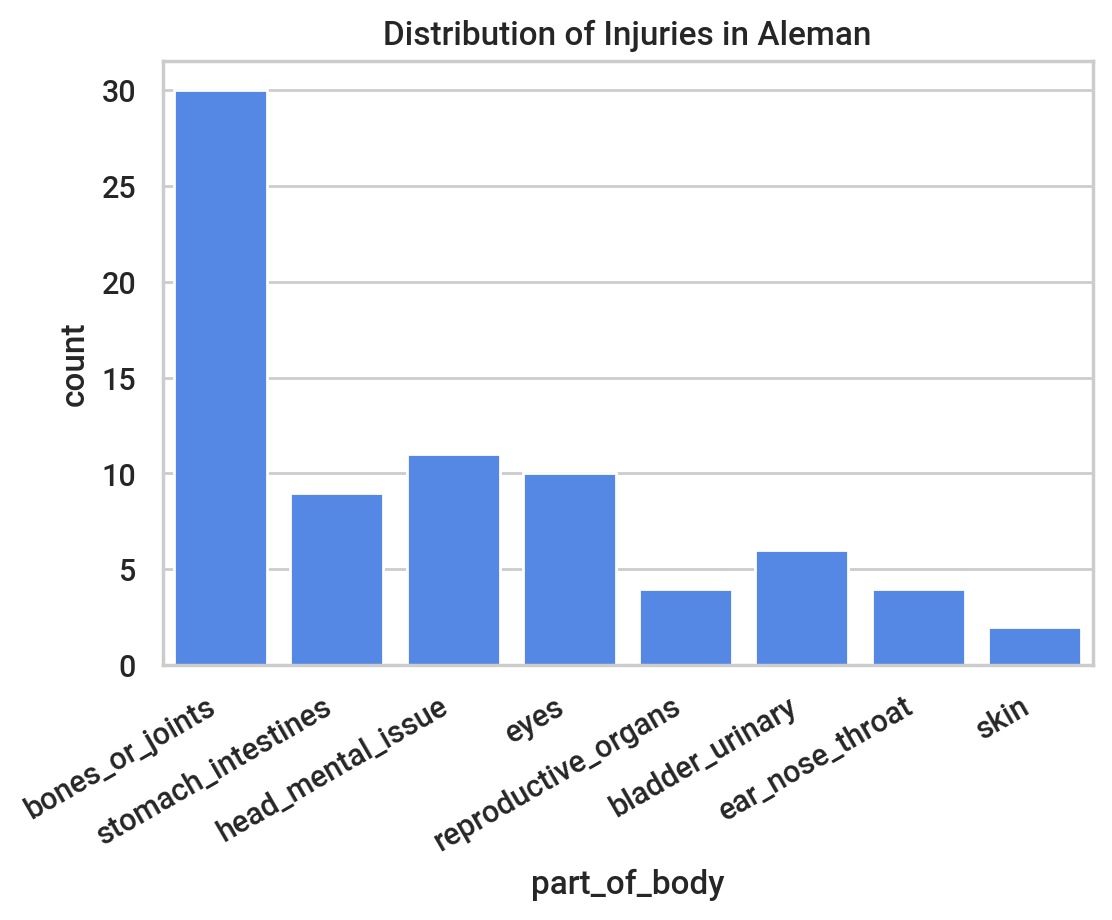

In [63]:
injury_dist(spn_med)

# Extra: Dealing with Survey_vitals missing values

In [66]:
print(survey_vitals.shape)
print()
print(survey_vitals.isna().sum())

(9458, 10)

objectId             0
marriageStatus    1597
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                482
sex                  0
clustersByLoc        0
province             0
dtype: int64


In [67]:
# filling missing values in marriageStatus column based on distribution
s = survey_vitals.marriageStatus.value_counts(normalize = True)
print(s)
print()
missing = survey_vitals["marriageStatus"].isnull()
survey_vitals.loc[missing, "marriageStatus"] = np.random.choice(s.index, size=len(survey_vitals[missing]),p=s.values)
age_dict = survey_vitals.groupby("marriageStatus")["age"].median().to_dict()
print(age_dict)
print()
unknown_age = survey_vitals["age"].isnull()
survey_vitals.loc[unknown_age, "age"] = survey_vitals.loc[unknown_age, "marriageStatus"].map(age_dict) # filling age column missing values based on each marriage status cohort
print(survey_vitals.isna().sum())

single        0.452487
free_union    0.340287
married       0.127465
widow         0.042743
concubine     0.037018
Name: marriageStatus, dtype: float64

{'concubine': 37.0, 'free_union': 37.0, 'married': 47.0, 'single': 29.0, 'widow': 66.0}

objectId             0
marriageStatus       0
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                  0
sex                  0
clustersByLoc        0
province             0
dtype: int64
